In [1]:
import gc
import os
from pathlib import Path
import random
import sys
from os.path import join as pjoin
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [2]:
RAW_DATA_DIR = os.path.join('..', 'input', 'ashrae-energy-prediction')

weather_dtypes = {
    'site_id': np.uint8,
    'air_temperature': np.float32,
    'cloud_coverage': np.float32,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float32,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float32,
    'wind_speed': np.float32,
}

weather_train = pd.read_csv(pjoin(RAW_DATA_DIR, 'weather_train.csv'),dtype=weather_dtypes,
    parse_dates=['timestamp'])
weather_test = pd.read_csv(pjoin(RAW_DATA_DIR, 'weather_test.csv'),dtype=weather_dtypes,
    parse_dates=['timestamp'])

weather = pd.concat([weather_train,weather_test],ignore_index=True)
del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather

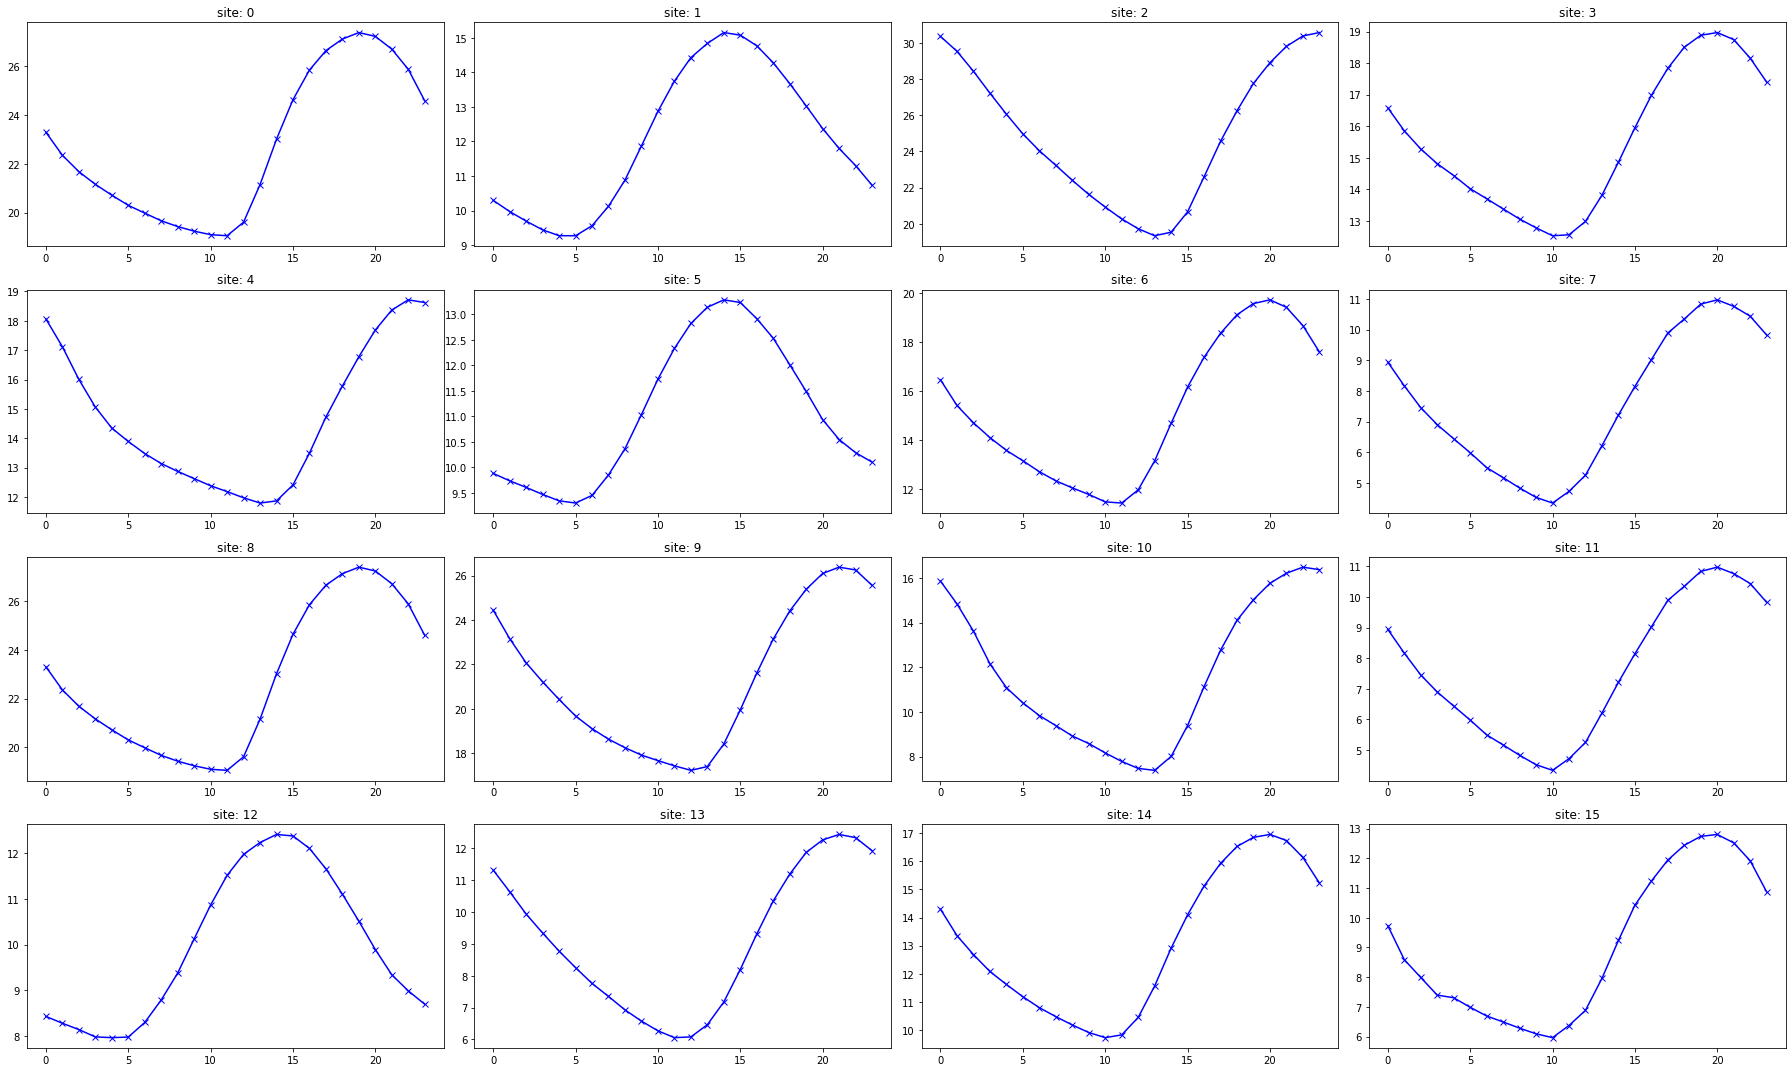

In [3]:
data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour
count = 1
plt.figure(figsize=(25, 15))
for site_id, data_by_site in data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del data_to_plot

In [4]:
# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [5]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
!ls ../input

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
%%time
#root = Path('../input/ashrae-feather-format-for-fast-loading')
root = os.path.join('..', 'output', 'ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(pjoin(root, 'train.feather'))
weather_train_df = pd.read_feather(pjoin(root, 'weather_train.feather'))
building_meta_df = pd.read_feather(pjoin(root, 'building_metadata.feather'))

print('loading...')
test_df = pd.read_feather(pjoin(root, 'test.feather'))
weather_test_df = pd.read_feather(pjoin(root, 'weather_test.feather'))

C:\Users\sbbpan\AppData\Local\Continuum\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



loading...
Wall time: 2.71 s


In [8]:
building_site_dict = dict(zip(building_meta_df['building_id'], building_meta_df['site_id']))
site_meter_raw = train_df[['building_id', 'meter', 'timestamp', 'meter_reading']].copy()
site_meter_raw['site_id'] = site_meter_raw.building_id.map(building_site_dict)
del site_meter_raw['building_id']
site_meter_to_plot = site_meter_raw.copy()
site_meter_to_plot["hour"] = site_meter_to_plot["timestamp"].dt.hour
elec_to_plot = site_meter_to_plot[site_meter_to_plot.meter == 0]

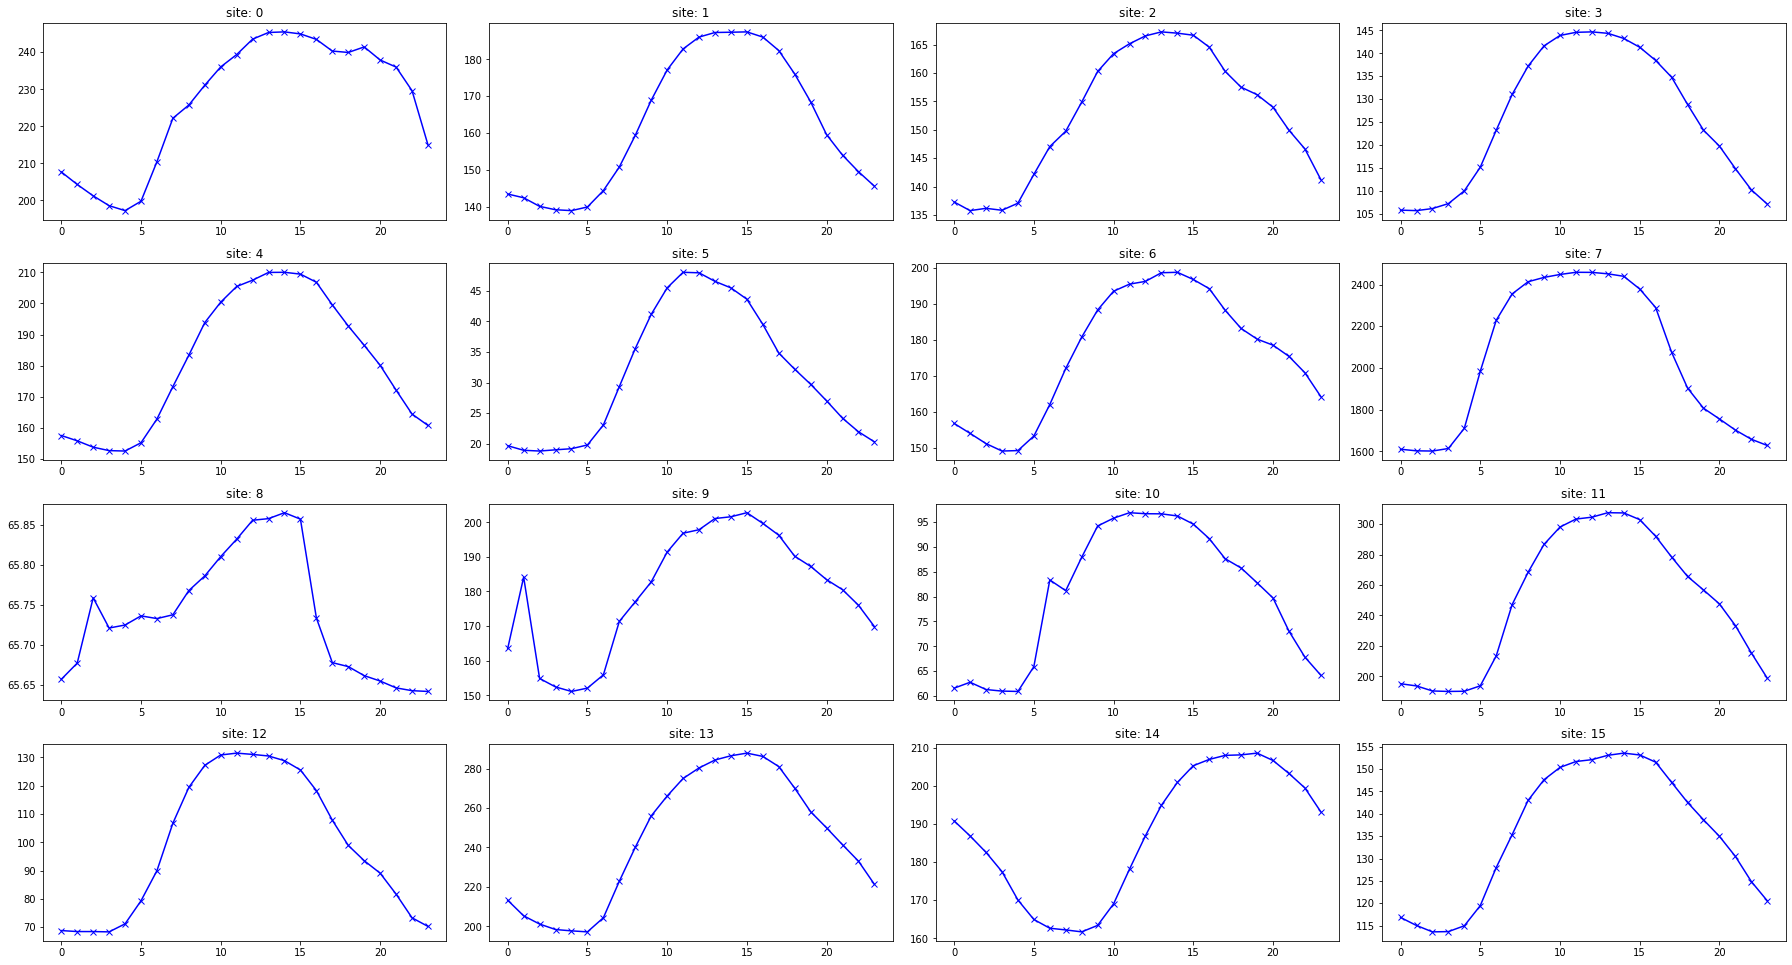

In [9]:
count = 1
plt.figure(figsize=(25, 50))
for site_id, data_by_site in elec_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(15, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['meter_reading'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del elec_to_plot, site_meter_to_plot, building_site_dict, site_meter_raw

In [10]:
train_exception = pd.read_pickle(os.path.join('..', 'output', 'fork-of-ashrae-eda-exception-label5', 'train_exception.pkl'))
train_df['exception'] = train_exception.exception.values
del train_exception
gc.collect()

65

In [11]:
########################### Building DF merge through concat 
#################################################################################
# Benefits of concat:
## Faster for huge datasets (columns number)
## No dtype change for dataset
## Consume less memmory 

temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df

In [12]:
########################### Weather DF merge over concat (to not lose type)
#################################################################################
# Benefits of concat:
## Faster for huge datasets (columns number)
## No dtype change for dataset
## Consume less memmory 
train_weather_df = timestamp_align(weather_train_df)

temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(train_weather_df, on=['site_id','timestamp'], how='left')
del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

del train_weather_df, temp_df
gc.collect()


test_weather_df = timestamp_align(weather_test_df)

test_temp_df = test_df[['site_id','timestamp']]
test_temp_df = test_temp_df.merge(test_weather_df, on=['site_id','timestamp'], how='left')
del test_temp_df['site_id'], test_temp_df['timestamp']
test_df = pd.concat([test_df, test_temp_df], axis=1)

del test_weather_df, test_temp_df
gc.collect()

0

In [13]:
# # 添加simplefe特征
# # 最后使用，验证强一点点，测试弱一点点，可忽略不计
# ########################### Smooth readings 单用，验证强点，测试弱一点
# #################################################################################
# TARGET = 'meter_reading'

# train_df['month'] = train_df["timestamp"].dt.month
# test_df['month'] = test_df["timestamp"].dt.month

# train_df['s_uid'] = train_df['site_id'].astype(str) +'_'+\
#                     train_df['month'].astype(str) +'_'+\
#                     train_df['meter'].astype(str) +'_'+\
#                     train_df['primary_use'].astype(str)

# temp_df = train_df.groupby(['s_uid'])[TARGET].apply(lambda x: int(np.percentile(x,99)))
# temp_df = temp_df.to_dict()

# train_df['s_uid'] = train_df['s_uid'].map(temp_df)
# train_df[TARGET] = np.where(train_df[TARGET]>train_df['s_uid'], train_df['s_uid'], train_df[TARGET])

# del train_df['s_uid'], temp_df

In [14]:
# Building and site id 
for enc_col in ['building_id', 'site_id']:
    # 该操作有重复
    temp_df = train_df.groupby([enc_col])['meter'].agg(['unique'])
    temp_df['unique'] = temp_df['unique'].apply(lambda x: '_'.join(str(x))).astype(str)

    le = LabelEncoder()
    temp_df['unique'] = le.fit_transform(temp_df['unique']).astype(np.int8)
    temp_df = temp_df['unique'].to_dict()

    train_df[enc_col+'_uid_enc'] = train_df[enc_col].map(temp_df)
    test_df[enc_col+'_uid_enc'] = test_df[enc_col].map(temp_df)
    
    # Nunique
    temp_dict = train_df.groupby([enc_col])['meter'].agg(['nunique'])['nunique'].to_dict()
    train_df[enc_col+'-m_nunique'] = train_df[enc_col].map(temp_dict).astype(np.int8)
    test_df[enc_col+'-m_nunique'] = test_df[enc_col].map(temp_dict).astype(np.int8)

del temp_df, temp_dict

In [15]:
train_df["hour"] = train_df["timestamp"].dt.hour
test_df["hour"] = test_df["timestamp"].dt.hour

train_df['DT_W'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['DT_W'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)

for df in [train_df, test_df]:
# for df in [train_df]:
    df['DT_w_hour'] = np.where((df['hour']>5)&(df['hour']<13),1,0)
    df['DT_w_hour'] = np.where((df['hour']>12)&(df['hour']<19),2,df['DT_w_hour'])
    df['DT_w_hour'] = np.where((df['hour']>18),3,df['DT_w_hour'])

    df['DT_w_temp'] = df.groupby(['site_id','DT_W','DT_w_hour'])['air_temperature'].transform('mean')
    df['DT_w_dew_temp'] = df.groupby(['site_id','DT_W','DT_w_hour'])['dew_temperature'].transform('mean')

i_cols = [
         'DT_w_hour',
        ]

for col in i_cols:
#     del train_df[col]
    del train_df[col], test_df[col]

In [16]:
# new_feature = ['building_id_uid_enc', 'building_id-m_nunique',
#        'site_id_uid_enc', 'site_id-m_nunique', 'DT_w_temp',
#        'DT_w_dew_temp']


new_feature = ['building_id_uid_enc', 'building_id-m_nunique',
       'site_id_uid_enc','DT_w_dew_temp']

In [17]:
# cut_target = np.copy(train_df.meter_reading.values)
train_nf = train_df[new_feature]
test_nf = test_df[new_feature]
del train_df, test_df, weather_test_df, weather_train_df, building_meta_df
gc.collect()

40

In [18]:
%%time
# root = Path('../input/ashrae-feather-format-for-fast-loading')

# train_df = pd.read_feather(root/'train.feather')
# weather_train_df = pd.read_feather(root/'weather_train.feather')
# building_meta_df = pd.read_feather(root/'building_metadata.feather')

root = os.path.join('..', 'output', 'ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(pjoin(root, 'train.feather'))
weather_train_df = pd.read_feather(pjoin(root, 'weather_train.feather'))
building_meta_df = pd.read_feather(pjoin(root, 'building_metadata.feather'))

C:\Users\sbbpan\AppData\Local\Continuum\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



Wall time: 274 ms


In [19]:
train_exception = pd.read_pickle(os.path.join('..', 'output', 'fork-of-ashrae-eda-exception-label5', 'train_exception.pkl'))
train_df['exception'] = train_exception.exception.values
del train_exception
gc.collect()

40

In [20]:
train_df.exception.value_counts(dropna=False)

 0    16258788
-1     1923669
-3     1051924
 3      452505
 1      365029
-2       85465
 2       78720
Name: exception, dtype: int64

In [21]:
# 验证强一点，测试弱一点
train_df.loc[(train_df.building_id == 1099) & (train_df.meter == 2) & (train_df.meter_reading > 30000), 'exception'] = 4

In [22]:
train_df.exception.value_counts(dropna=False)

 0    16255437
-1     1923669
-3     1051924
 3      452505
 1      365029
-2       85465
 2       78720
 4        3351
Name: exception, dtype: int64

In [23]:
train_df = pd.concat([train_df, train_nf], axis=1)
# test_df = pd.concat([test_df, test_nf], axis=1)
del train_nf
gc.collect()

0

In [24]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
#     df["month"] = df["timestamp"].dt.month
#     df["dayofweek"] = df["timestamp"].dt.dayofweek
#     df['DT_day_month'] = df['timestamp'].dt.day.astype(np.int8)
#     df['DT_W'] = df['timestamp'].dt.weekofyear.astype(np.int8)
    
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
#     cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    cols = ['air_temperature','dew_temperature']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
#     lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
#         weather_df[f'{col}_std_lag{window}'] = lag_std[col]
        
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

debug = False    
preprocess(train_df)

# https://www.kaggle.com/ryches/simple-lgbm-solution
df_group = train_df.groupby('building_id')['meter_reading_log1p']
# building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
# building_min = df_group.min().astype(np.float16)
# building_max = df_group.max().astype(np.float16)
# building_std = df_group.std().astype(np.float16)

# train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
# train_df['building_min'] = train_df['building_id'].map(building_min)
# train_df['building_max'] = train_df['building_id'].map(building_max)
# train_df['building_std'] = train_df['building_id'].map(building_std)

weather_train_df = timestamp_align(weather_train_df)
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

# weather_col = ['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
#        'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
#        'wind_direction', 'wind_speed', 'offset']

weather_col = ['site_id', 'timestamp', 'air_temperature','precip_depth_1_hr']

weather_col += ['air_temperature_mean_lag72','dew_temperature_mean_lag72','air_temperature_max_lag3','air_temperature_min_lag3','dew_temperature_mean_lag3']
weather_col += ['air_temperature_mean_lag3']

weather_train_df = weather_train_df[weather_col]
gc.collect()

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}
Memory usage of dataframe is 1426.69 MB
Memory usage after optimization is: 559.12 MB
Decreased by 60.8%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.1%
Memory usage of dataframe is 3.87 MB
Memory usage after optimization is: 3.33 MB
Decreased by 13.8%


,site_id,timestamp,air_temperature,precip_depth_1_hr,air_temperature_mean_lag72,dew_temperature_mean_lag72,air_temperature_max_lag3,air_temperature_min_lag3,dew_temperature_mean_lag3,air_temperature_mean_lag3
0,0,2015-12-31 19:00:00,25.000000,-1.0,25.000000,20.000000,25.000000,25.000000,20.000000,25.000000
1,0,2015-12-31 20:00:00,24.406250,-1.0,24.703125,20.546875,25.000000,24.406250,20.546875,24.703125
2,0,2015-12-31 21:00:00,22.796875,0.0,24.062500,20.734375,25.000000,22.796875,20.734375,24.062500
3,0,2015-12-31 22:00:00,21.093750,0.0,23.328125,20.703125,24.406250,21.093750,20.937500,22.765625
4,0,2015-12-31 23:00:00,20.000000,-1.0,22.656250,20.562500,22.796875,20.000000,20.562500,21.296875
...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 13:00:00,3.000000,-1.0,-1.548828,-5.218750,3.000000,2.199219,-7.867188,2.666016
139769,15,2016-12-31 14:00:00,2.800781,-1.0,-1.486328,-5.250000,3.000000,2.800781,-8.234375,2.867188
139770,15,2016-12-31 15:00:00,2.800781,-1.0,-1.438477,-5.250000,3.000000,2.800781,-8.031250,2.867188
139771,15,2016-12-31 16:00:00,2.199219,-1.0,-1.377930,-5.250000,2.800781,2.199219,-7.601562,2.599609


In [25]:
building_meta_df.primary_use = building_meta_df.primary_use.astype(np.int8)

In [26]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'exception',
       'building_id_uid_enc', 'building_id-m_nunique', 'site_id_uid_enc',
       'DT_w_dew_temp', 'date', 'meter_reading_log1p', 'hour', 'weekend',
       'building_median'],
      dtype='object')

In [27]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built', 'floor_count','hour','weekend','building_median','air_temperature']

# 强一点
feature_cols += ['precip_depth_1_hr']

# 有进步
feature_cols += ['air_temperature_mean_lag72','dew_temperature_mean_lag72','air_temperature_max_lag3','air_temperature_min_lag3','dew_temperature_mean_lag3']

# 添加验证弱，测试强, 这样的话，验证和测试的提升整体上就比较相关
# feature_cols += ['air_temperature_max_lag72','air_temperature_min_lag72','air_temperature_std_lag72',
#                 'cloud_coverage_mean_lag72','wind_speed_mean_lag3']

# 再加验证强点，测试弱点， 添加后，变为验证弱点，测试强点了
feature_cols += ['air_temperature_mean_lag3']

# 都弱一点
feature_cols += ['building_id_uid_enc']

# 验证强点,测试强多
feature_cols += ['building_id-m_nunique']

# 都弱点
feature_cols += ['site_id_uid_enc']

# 都强
feature_cols += ['DT_w_dew_temp']

In [28]:
T_RESULTS = train_df[['meter_reading']]
T_RESULTS['kfold'] = 0

In [29]:
# def create_X_y(train_df, target_meter):
#     target_train_df = train_df[train_df['meter'] == target_meter]
#     target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
#     target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
#     X_train = target_train_df[feature_cols + category_cols + ['exception']]
#     y_train = target_train_df['meter_reading_log1p'].values

#     del target_train_df
#     return X_train, y_train

def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    
    target_train_df.index = train_df[train_df['meter'] == target_meter].index
    
    X_train = target_train_df[feature_cols + category_cols + ['exception']]
    y_train = target_train_df['meter_reading_log1p']

    del target_train_df
    return X_train, y_train

def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

In [30]:
def fit_xgb(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
#     metric = 'l2'
#     params = {'num_leaves': 31,
#               'objective': 'regression',
# #               'max_depth': -1,
#               'learning_rate': lr,
#               "boosting": "gbdt",
#               "bagging_freq": 5,
#               "bagging_fraction": bf,
#               "feature_fraction": 0.9,
#               "metric": metric,
# #               "verbosity": -1,
# #               'reg_alpha': 0.1,
# #               'reg_lambda': 0.3
#               }
#     device = devices[0]
#     if device == -1:
#         # use cpu
#         pass
#     else:
#         # use gpu
#         print(f'using gpu device_id {device}...')
#         params.update({'device': 'gpu', 'gpu_device_id': device})

#     params['seed'] = seed
    
    
    model =  xgb.XGBRegressor(
                      n_estimators=6000,
                      max_depth=8,
#                       num_boost_round=500,
                      learning_rate=lr,
                      subsample=0.8,
                      colsample_bytree=0.4,
#                       missing=np.nan,
                      objective ='reg:squarederror',
                      tree_method='hist',
                      seed=seed
                      )
    
    print('training XGB:')
    model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train),(X_valid, y_valid)],
                verbose=20, early_stopping_rounds=50)
    
#     model.fit(X_train, y_train,
#                 eval_set=[train,val],
#                 verbose=20, early_stopping_rounds=50)
    
    

#     early_stop = 20
#     verbose_eval = 20

#     d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
#     d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
#     watchlist = [d_train, d_valid]

#     print('training LGB:')
#     model = lgb.train(params,
#                       train_set=d_train,
#                       num_boost_round=num_rounds,
#                       valid_sets=watchlist,
#                       verbose_eval=verbose_eval,
#                       early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid)
    
#     print('best_score', model.best_score)
#     log = {'train/mae': model.best_score['training']['l2'],
#            'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid

In [31]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)

del train_df, weather_train_df
gc.collect()

140

In [32]:
########################### Check memory usage
#################################################################################
import psutil

def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 


def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))
print('Memory in Gb', get_memory_usage())

                            df:   3.9GiB
                       test_nf: 835.1MiB
                       X_train: 529.1MiB
                     T_RESULTS: 231.4MiB
                       y_train: 115.0MiB
                  data_by_site:  29.7MiB
                 temp_skeleton:  11.5MiB
                           ___:   3.3MiB
                           _24:   3.3MiB
               building_median:  54.2KiB
Memory in Gb 7.77


In [33]:
del df
gc.collect()

20

In [34]:
# target_meter = 0
# X_train, y_train = create_X_y(train_df, target_meter=target_meter)

# del train_df, weather_train_df
# gc.collect()


# y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for fold_, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    if fold_ == 1:
        
        print(f'train_{fold_}')
    
    #     tr_x = X_train.iloc[train_idx,:]
    #     vl_x = X_train.iloc[valid_idx,:]
    #     tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)].index.values]
    #     v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)].index.values]

    #     tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)][feature_cols + category_cols]
    #     vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)][feature_cols + category_cols]


        tr_x = X_train.iloc[train_idx,:]
        vl_x = X_train.iloc[valid_idx,:]
        tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)].index.values]
        v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)].index.values]

        tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)][feature_cols + category_cols]
        vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)][feature_cols + category_cols]


        train_data = tr_x, tr_y
        valid_data = vl_x, v_y

        del tr_x, tr_y, vl_x, v_y
        gc.collect()
    #     train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    #     valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    #     model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
    #                                         num_rounds=1000, lr=0.05, bf=0.7)
    #     y_valid_pred_total[valid_idx] = y_pred_valid


        model, y_pred_valid = fit_xgb(train_data, valid_data, cat_features=category_cols,
                                            num_rounds=1000, lr=0.05, bf=0.7)


        del train_data, valid_data
        gc.collect()

        t_prediction = model.predict(X_train.iloc[valid_idx,:][feature_cols + category_cols])
        T_RESULTS.iloc[X_train.iloc[valid_idx,:].index, 1] = np.expm1(t_prediction)

        models0.append(model)
        del model
        gc.collect()
        if debug:
            break

# sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 0 (12060910, 22)
cat_features [18, 19, 20]
train_1
train 9648728 valid 2412182
training XGB:


C:\Users\sbbpan\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-rmse:3.77664	validation_1-rmse:3.6856
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:1.50448	validation_1-rmse:1.45426
[40]	validation_0-rmse:0.764477	validation_1-rmse:0.718554
[60]	validation_0-rmse:0.553457	validation_1-rmse:0.51137
[80]	validation_0-rmse:0.484309	validation_1-rmse:0.443903
[100]	validation_0-rmse:0.454563	validation_1-rmse:0.423568
[120]	validation_0-rmse:0.438649	validation_1-rmse:0.41356
[140]	validation_0-rmse:0.425686	validation_1-rmse:0.409918
[160]	validation_0-rmse:0.416964	validation_1-rmse:0.404604
[180]	validation_0-rmse:0.408678	validation_1-rmse:0.401164
[200]	validation_0-rmse:0.402351	validation_1-rmse:0.398955
[220]	validation_0-rmse:0.396179	validation_1-rmse:0.394988
[240]	validation_0-rmse:0.391814	validation_1-rmse:0.393081
[260]	validation_0-rmse:0.386823	validation_1-rmse:0.391539
[280]	validati

0

In [35]:
# target_meter = 1
# X_train, y_train = create_X_y(train_df, target_meter=target_meter)
# # y_valid_pred_total = np.zeros(X_train.shape[0])
# gc.collect()
# print('target_meter', target_meter, X_train.shape)

# cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
# print('cat_features', cat_features)

# models1 = []
# for train_idx, valid_idx in kf.split(X_train, y_train):
# #     tr_x = X_train.iloc[train_idx,:]
# #     vl_x = X_train.iloc[valid_idx,:]
# #     tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)].index.values]
# #     v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)].index.values]

# #     tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)][feature_cols + category_cols]
# #     vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)][feature_cols + category_cols]
    
    
#     tr_x = X_train.iloc[train_idx,:]
#     vl_x = X_train.iloc[valid_idx,:]
#     tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)].index.values]
#     v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)].index.values]

#     tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)][feature_cols + category_cols]
#     vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)][feature_cols + category_cols]
    
    
#     train_data = tr_x, tr_y
#     valid_data = vl_x, v_y
    
#     del tr_x, tr_y, vl_x, v_y
#     gc.collect()
    
# #     train_data = X_train.iloc[train_idx,:], y_train[train_idx]
# #     valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

#     print('train', len(train_idx), 'valid', len(valid_idx))
# #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
# #     model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
# #                                        lr=0.05, bf=0.5)
# #     y_valid_pred_total[valid_idx] = y_pred_valid


#     model, y_pred_valid = fit_xgb(train_data, valid_data, cat_features=category_cols,
#                                         num_rounds=1000, lr=0.05, bf=0.7)


#     del train_data, valid_data
#     gc.collect()
    
#     t_prediction = model.predict(X_train.iloc[valid_idx,:][feature_cols + category_cols])
#     T_RESULTS.iloc[X_train.iloc[valid_idx,:].index, 1] = np.expm1(t_prediction)
    
#     models1.append(model)
#     gc.collect()
#     if debug:
#         break

# sns.distplot(y_train)
# del X_train, y_train
# gc.collect()

In [36]:
# target_meter = 2
# X_train, y_train = create_X_y(train_df, target_meter=target_meter)
# # y_valid_pred_total = np.zeros(X_train.shape[0])

# gc.collect()
# print('target_meter', target_meter, X_train.shape)

# cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
# print('cat_features', cat_features)

# models2 = []
# for train_idx, valid_idx in kf.split(X_train, y_train):
    
# #     tr_x = X_train.iloc[train_idx,:]
# #     vl_x = X_train.iloc[valid_idx,:]
# #     tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)].index.values]
# #     v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)].index.values]

# #     tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)][feature_cols + category_cols]
# #     vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)][feature_cols + category_cols]
    
    
#     tr_x = X_train.iloc[train_idx,:]
#     vl_x = X_train.iloc[valid_idx,:]
#     tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)].index.values]
#     v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)].index.values]

#     tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)][feature_cols + category_cols]
#     vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)][feature_cols + category_cols]
    
    
#     train_data = tr_x, tr_y
#     valid_data = vl_x, v_y
    
#     del tr_x, tr_y, vl_x, v_y
#     gc.collect()
    
# #     train_data = X_train.iloc[train_idx,:], y_train[train_idx]
# #     valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

#     print('train', len(train_idx), 'valid', len(valid_idx))
# #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
# #     model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
# #                                         num_rounds=1000, lr=0.05, bf=0.8)
# #     y_valid_pred_total[valid_idx] = y_pred_valid



#     model, y_pred_valid = fit_xgb(train_data, valid_data, cat_features=category_cols,
#                                         num_rounds=1000, lr=0.05, bf=0.7)


#     del train_data, valid_data
#     gc.collect()

#     t_prediction = model.predict(X_train.iloc[valid_idx,:][feature_cols + category_cols])
#     T_RESULTS.iloc[X_train.iloc[valid_idx,:].index, 1] = np.expm1(t_prediction)
    
#     models2.append(model)
#     gc.collect()
#     if debug:
#         break

# sns.distplot(y_train)
# del X_train, y_train
# gc.collect()

In [37]:
# target_meter = 3
# X_train, y_train = create_X_y(train_df, target_meter=target_meter)
# # y_valid_pred_total = np.zeros(X_train.shape[0])

# gc.collect()
# print('target_meter', target_meter, X_train.shape)

# cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
# print('cat_features', cat_features)

# models3 = []
# for train_idx, valid_idx in kf.split(X_train, y_train):
    
# #     tr_x = X_train.iloc[train_idx,:]
# #     vl_x = X_train.iloc[valid_idx,:]
# #     tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)].index.values]
# #     v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)].index.values]

# #     tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1)][feature_cols + category_cols]
# #     vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1)][feature_cols + category_cols]
    
    
#     tr_x = X_train.iloc[train_idx,:]
#     vl_x = X_train.iloc[valid_idx,:]
#     tr_y = y_train[tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)].index.values]
#     v_y = y_train[vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)].index.values]

#     tr_x = tr_x[(tr_x.exception != 3) & (tr_x.exception != 1) & (tr_x.exception != 4)][feature_cols + category_cols]
#     vl_x = vl_x[(vl_x.exception != 3) & (vl_x.exception != 1) & (vl_x.exception != 4)][feature_cols + category_cols]
    
    
#     train_data = tr_x, tr_y
#     valid_data = vl_x, v_y
    
#     del tr_x, tr_y, vl_x, v_y
#     gc.collect()
    
# #     train_data = X_train.iloc[train_idx,:], y_train[train_idx]
# #     valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

#     print('train', len(train_idx), 'valid', len(valid_idx))
# #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
# #     model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
# #                                        lr=0.03, bf=0.9)
# #     y_valid_pred_total[valid_idx] = y_pred_valid


#     model, y_pred_valid = fit_xgb(train_data, valid_data, cat_features=category_cols,
#                                         num_rounds=1000, lr=0.03, bf=0.9)
    

#     del train_data, valid_data
#     gc.collect()
    
#     t_prediction = model.predict(X_train.iloc[valid_idx,:][feature_cols + category_cols])
#     T_RESULTS.iloc[X_train.iloc[valid_idx,:].index, 1] = np.expm1(t_prediction)
    
#     models3.append(model)
#     gc.collect()
#     if debug:
#         break

# sns.distplot(y_train)
# del X_train, y_train
# gc.collect()

In [38]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
TARGET = 'meter_reading'
T_RESULTS['kfold'] = T_RESULTS['kfold'].clip(0,None)
print('rmse score', np.sqrt(mean_squared_log_error(T_RESULTS[TARGET], T_RESULTS['kfold'])))
print('#'*20)

rmse score 4.471563153699682
####################


In [39]:
output_path = os.path.join('..', 'output', 'as-meter2-no-1099-xgb-meter0-fold1')
T_RESULTS.to_pickle(os.path.join(output_path, 'T_RESULTS.pkl'))
#T_RESULTS.to_pickle('T_RESULTS.pkl')

In [40]:
# print('rmse score', np.sqrt(mean_squared_log_error(T_RESULTS[TARGET], T_RESULTS['kfold'])))
# print('------------------------------------')

# cv_score_idx = train_df[train_df.exception != 1].index.values
# print('1全体非异常rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception == -1) | (train_df.exception == 1)].index.values
# print('1全体异常建筑rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[train_df.exception == -1].index.values
# print('1全体异常建筑正常部分rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[train_df.exception == 1].index.values
# print('1全体异常建筑异常部分rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception != 1) & (train_df.exception != -1)].index.values
# print('1全体正常建筑rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))
# print('------------------------------------')

# cv_score_idx = train_df[train_df.exception != 3].index.values
# print('3全体非异常rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception == -3) | (train_df.exception == 3)].index.values
# print('3全体异常建筑rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[train_df.exception == -3].index.values
# print('3全体异常建筑正常部分rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[train_df.exception == 3].index.values
# print('3全体异常建筑异常部分rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception != 3) & (train_df.exception != -3)].index.values
# print('3全体正常建筑rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))
# print('------------------------------------')

# cv_score_idx = train_df[(train_df.exception != 3) & (train_df.exception != 1)].index.values
# print('13全体非异常rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception == -3) | (train_df.exception == 3) | (train_df.exception == -1) | (train_df.exception == 1)].index.values
# print('13全体异常建筑rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception == -3) | (train_df.exception == -1)].index.values
# print('13全体异常建筑正常部分rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception == 3) | (train_df.exception == 1)].index.values
# print('13全体异常建筑异常部分rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))

# cv_score_idx = train_df[(train_df.exception != 3) & (train_df.exception != -3) & (train_df.exception != 1) & (train_df.exception != -1)].index.values
# print('13全体正常建筑rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[cv_score_idx, TARGET], T_RESULTS.loc[cv_score_idx, 'kfold'])))
# print('------------------------------------')

In [41]:
weather_nan_id = [20204274, 20204275, 20204276, 20204277, 20204278, 20204279, 20204280, 20204281, 20204282, 20204283, 20204284, 20204285, 20204286, 20204287, 20204288, 20204289, 20204290, 20204291, 20204292, 20204293, 20204294, 20204295, 20204296, 20204297, 20204298, 20204299, 20204300, 20204301, 20204302, 20204303, 20204304, 20204305, 20204306, 20204307, 20204308, 20204309, 20204310, 20204311, 20204312, 20204313, 20204314, 20204315, 20204316, 20204317, 20204318, 20204319, 20204320, 20204321, 20204322, 20204323, 20204324, 20204325, 20204326, 20204327, 20204328, 20204329, 20204330, 20204331, 20204332, 20204333, 20204334, 20204335, 20204336, 20204337, 20204338, 20204339, 20204340, 20204341, 20204342, 20204343, 20204344, 20204345, 20204346, 20204347, 20204348, 20204349, 20204350, 20204351, 20204352, 20204353, 20204354, 20204355, 20204356, 20204357, 20204358, 20204359, 20204360, 20204361, 20204362, 20204363, 20204364, 20204365, 20204366, 20204367, 20204368, 20204369, 20204370, 20204371, 20204372, 20204373, 20204374, 20204375, 20204376, 20204377, 20204378, 20204379, 20204380, 20204381, 20204382, 20204383, 20204384, 20204385, 20204386, 20204387, 20204388, 20204389, 20204390, 20204391, 20204392, 20204393, 20204394, 20204395, 20204396, 20204397, 20204398, 20204399, 20204400, 20204401, 20206637, 20206638, 20206639, 20206640, 20206641, 20206642, 20206643, 20206644, 20206645, 20206646, 20206647, 20206648, 20206649, 20206650, 20206651, 20206652, 20206653, 20206654, 20206655, 20206656, 20206657, 20206658, 20206659, 20206660, 20206661, 20206662, 20206663, 20206664, 20206665, 20206666, 20206667, 20206668, 20206669, 20206670, 20206671, 20206672, 20206673, 20206674, 20206675, 20206676, 20206677, 20206678, 20206679, 20206680, 20206681, 20206682, 20206683, 20206684, 20206685, 20206686, 20206687, 20206688, 20206689, 20206690, 20206691, 20206692, 20206693, 20206694, 20206695, 20206696, 20206697, 20206698, 20206699, 20206700, 20206701, 20206702, 20206703, 20206704, 20206705, 20206706, 20206707, 20206708, 20206709, 20206710, 20206711, 20206712, 20206713, 20206714, 20206715, 20206716, 20206717, 20206718, 20206719, 20206720, 20206721, 20206722, 20206723, 20206724, 20206725, 20206726, 20206727, 20206728, 20206729, 20206730, 20206731, 20206732, 20206733, 20206734, 20206735, 20206736, 20206737, 20206738, 20206739, 20206740, 20206741, 20206742, 20206743, 20206744, 20206745, 20206746, 20206747, 20206748, 20206749, 20206750, 20206751, 20206752, 20206753, 20206754, 20206755, 20206756, 20206757, 20206758, 20206759, 20206760, 20206761, 20206762, 20206763, 20206764, 20209003, 20209004, 20209005, 20209006, 20209007, 20209008, 20209009, 20209010, 20209011, 20209012, 20209013, 20209014, 20209015, 20209016, 20209017, 20209018, 20209019, 20209020, 20209021, 20209022, 20209023, 20209024, 20209025, 20209026, 20209027, 20209028, 20209029, 20209030, 20209031, 20209032, 20209033, 20209034, 20209035, 20209036, 20209037, 20209038, 20209039, 20209040, 20209041, 20209042, 20209043, 20209044, 20209045, 20209046, 20209047, 20209048, 20209049, 20209050, 20209051, 20209052, 20209053, 20209054, 20209055, 20209056, 20209057, 20209058, 20209059, 20209060, 20209061, 20209062, 20209063, 20209064, 20209065, 20209066, 20209067, 20209068, 20209069, 20209070, 20209071, 20209072, 20209073, 20209074, 20209075, 20209076, 20209077, 20209078, 20209079, 20209080, 20209081, 20209082, 20209083, 20209084, 20209085, 20209086, 20209087, 20209088, 20209089, 20209090, 20209091, 20209092, 20209093, 20209094, 20209095, 20209096, 20209097, 20209098, 20209099, 20209100, 20209101, 20209102, 20209103, 20209104, 20209105, 20209106, 20209107, 20209108, 20209109, 20209110, 20209111, 20209112, 20209113, 20209114, 20209115, 20209116, 20209117, 20209118, 20209119, 20209120, 20209121, 20209122, 20209123, 20209124, 20209125, 20209126, 20209127, 20209128, 20209129, 20209130, 20211368, 20211369, 20211370, 20211371, 20211372, 20211373, 20211374, 20211375, 20211376, 20211377, 20211378, 20211379, 20211380, 20211381, 20211382, 20211383, 20211384, 20211385, 20211386, 20211387, 20211388, 20211389, 20211390, 20211391, 20211392, 20211393, 20211394, 20211395, 20211396, 20211397, 20211398, 20211399, 20211400, 20211401, 20211402, 20211403, 20211404, 20211405, 20211406, 20211407, 20211408, 20211409, 20211410, 20211411, 20211412, 20211413, 20211414, 20211415, 20211416, 20211417, 20211418, 20211419, 20211420, 20211421, 20211422, 20211423, 20211424, 20211425, 20211426, 20211427, 20211428, 20211429, 20211430, 20211431, 20211432, 20211433, 20211434, 20211435, 20211436, 20211437, 20211438, 20211439, 20211440, 20211441, 20211442, 20211443, 20211444, 20211445, 20211446, 20211447, 20211448, 20211449, 20211450, 20211451, 20211452, 20211453, 20211454, 20211455, 20211456, 20211457, 20211458, 20211459, 20211460, 20211461, 20211462, 20211463, 20211464, 20211465, 20211466, 20211467, 20211468, 20211469, 20211470, 20211471, 20211472, 20211473, 20211474, 20211475, 20211476, 20211477, 20211478, 20211479, 20211480, 20211481, 20211482, 20211483, 20211484, 20211485, 20211486, 20211487, 20211488, 20211489, 20211490, 20211491, 20211492, 20211493, 20211494, 20211495, 20213734, 20213735, 20213736, 20213737, 20213738, 20213739, 20213740, 20213741, 20213742, 20213743, 20213744, 20213745, 20213746, 20213747, 20213748, 20213749, 20213750, 20213751, 20213752, 20213753, 20213754, 20213755, 20213756, 20213757, 20213758, 20213759, 20213760, 20213761, 20213762, 20213763, 20213764, 20213765, 20213766, 20213767, 20213768, 20213769, 20213770, 20213771, 20213772, 20213773, 20213774, 20213775, 20213776, 20213777, 20213778, 20213779, 20213780, 20213781, 20213782, 20213783, 20213784, 20213785, 20213786, 20213787, 20213788, 20213789, 20213790, 20213791, 20213792, 20213793, 20213794, 20213795, 20213796, 20213797, 20213798, 20213799, 20213800, 20213801, 20213802, 20213803, 20213804, 20213805, 20213806, 20213807, 20213808, 20213809, 20213810, 20213811, 20213812, 20213813, 20213814, 20213815, 20213816, 20213817, 20213818, 20213819, 20213820, 20213821, 20213822, 20213823, 20213824, 20213825, 20213826, 20213827, 20213828, 20213829, 20213830, 20213831, 20213832, 20213833, 20213834, 20213835, 20213836, 20213837, 20213838, 20213839, 20213840, 20213841, 20213842, 20213843, 20213844, 20213845, 20213846, 20213847, 20213848, 20213849, 20213850, 20213851, 20213852, 20213853, 20213854, 20213855, 20213856, 20213857, 20213858, 20213859, 20213860, 20213861, 20195011, 20195012, 20195013, 20195014, 20195015, 20195016, 20195017, 20195018, 20195019, 20195020, 20195021, 20195022, 20195023, 20195024, 20195025, 20195026, 20195027, 20195028, 20195029, 20195030, 20195031, 20195032, 20195033, 20195034, 20195035, 20195036, 20195037, 20195038, 20195039, 20195040, 20195041, 20195042, 20195043, 20195044, 20195045, 20195046, 20195047, 20195048, 20195049, 20195050, 20195051, 20195052, 20195053, 20195054, 20195055, 20195056, 20195057, 20195058, 20195059, 20195060, 20195061, 20195062, 20195063, 20195064, 20195065, 20195066, 20195067, 20195068, 20195069, 20195070, 20195071, 20195072, 20195073, 20195074, 20195075, 20195076, 20195077, 20195078, 20195079, 20195080, 20195081, 20195082, 20195083, 20195084, 20195085, 20195086, 20195087, 20195088, 20195089, 20195090, 20195091, 20195092, 20195093, 20195094, 20195095, 20195096, 20195097, 20195098, 20195099, 20195100, 20195101, 20195102, 20195103, 20195104, 20195105, 20195106, 20195107, 20195108, 20195109, 20195110, 20195111, 20195112, 20195113, 20195114, 20195115, 20195116, 20195117, 20195118, 20195119, 20195120, 20195121, 20195122, 20195123, 20195124, 20195125, 20195126, 20195127, 20195128, 20195129, 20195130, 20195131, 20195132, 20195133, 20195134, 20195135, 20195136, 20195137, 20195138, 20195139, 20195140, 20195141, 20195142, 20195143, 20195144, 20195145, 20195146, 20195147, 20195148, 20195149, 20195150, 20195151, 20195152, 20195153, 20195154, 20195155, 20195156, 20195157, 20195158, 20195159, 20195160, 20195161, 20195162, 20195163, 20195164, 20195165, 20195166, 20195167, 20195168, 20195169, 20195170, 20195171, 20195172, 20195173, 20195174, 20195175, 20195176, 20195177, 20195178, 20195179, 20195180, 20195181, 20195182, 20195183, 20195184, 20195185, 20195186, 20195187, 20195188, 20195189, 20195190, 20195191, 20195192, 20195193, 20195194, 20195195, 20195196, 20195197, 20195198, 20195199, 20195200, 20195201, 20195202, 20195203, 20195204, 20195205, 20195206, 20195207, 20195208, 20195209, 20195210, 20195211, 20195212, 20195213, 20195214, 20195215, 20195216, 20195217, 20195218, 20195219, 20195220, 20195221, 20195222, 20195223, 20195224, 20195225, 20195226, 20195227, 20195228, 20195229, 20195230, 20195231, 20195232, 20195233, 20195234, 20195235, 20195236, 20195237, 20195238, 20195239, 20195240, 20195241, 20195242, 20195243, 20195244, 20195245, 20195246, 20195247, 20195248, 20195249, 20195250, 20195251, 20195252, 20195253, 20195254, 20195255, 20195256, 20195257, 20195258, 20195259, 20195260, 20195261, 20195262, 20195263, 20195264, 20195265, 20195266, 20195267, 20195268, 20195269, 20195270, 20195271, 20195272, 20195273, 20195274, 20195275, 20195276, 20195277, 20195278, 20195279, 20195280, 20195281, 20195282, 20195283, 20195284, 20195285, 20195286, 20195287, 20195288, 20195289, 20195290, 20195291, 20195292, 20195293, 20195294, 20195295, 20195296, 20195297, 20195298, 20197376, 20197377, 20197378, 20197379, 20197380, 20197381, 20197382, 20197383, 20197384, 20197385, 20197386, 20197387, 20197388, 20197389, 20197390, 20197391, 20197392, 20197393, 20197394, 20197395, 20197396, 20197397, 20197398, 20197399, 20197400, 20197401, 20197402, 20197403, 20197404, 20197405, 20197406, 20197407, 20197408, 20197409, 20197410, 20197411, 20197412, 20197413, 20197414, 20197415, 20197416, 20197417, 20197418, 20197419, 20197420, 20197421, 20197422, 20197423, 20197424, 20197425, 20197426, 20197427, 20197428, 20197429, 20197430, 20197431, 20197432, 20197433, 20197434, 20197435, 20197436, 20197437, 20197438, 20197439, 20197440, 20197441, 20197442, 20197443, 20197444, 20197445, 20197446, 20197447, 20197448, 20197449, 20197450, 20197451, 20197452, 20197453, 20197454, 20197455, 20197456, 20197457, 20197458, 20197459, 20197460, 20197461, 20197462, 20197463, 20197464, 20197465, 20197466, 20197467, 20197468, 20197469, 20197470, 20197471, 20197472, 20197473, 20197474, 20197475, 20197476, 20197477, 20197478, 20197479, 20197480, 20197481, 20197482, 20197483, 20197484, 20197485, 20197486, 20197487, 20197488, 20197489, 20197490, 20197491, 20197492, 20197493, 20197494, 20197495, 20197496, 20197497, 20197498, 20197499, 20197500, 20197501, 20197502, 20197503, 20197504, 20197505, 20197506, 20197507, 20197508, 20197509, 20197510, 20197511, 20197512, 20197513, 20197514, 20197515, 20197516, 20197517, 20197518, 20197519, 20197520, 20197521, 20197522, 20197523, 20197524, 20197525, 20197526, 20197527, 20197528, 20197529, 20197530, 20197531, 20197532, 20197533, 20197534, 20197535, 20197536, 20197537, 20197538, 20197539, 20197540, 20197541, 20197542, 20197543, 20197544, 20197545, 20197546, 20197547, 20197548, 20197549, 20197550, 20197551, 20197552, 20197553, 20197554, 20197555, 20197556, 20197557, 20197558, 20197559, 20197560, 20197561, 20197562, 20197563, 20197564, 20197565, 20197566, 20197567, 20197568, 20197569, 20197570, 20197571, 20197572, 20197573, 20197574, 20197575, 20197576, 20197577, 20197578, 20197579, 20197580, 20197581, 20197582, 20197583, 20197584, 20197585, 20197586, 20197587, 20197588, 20197589, 20197590, 20197591, 20197592, 20197593, 20197594, 20197595, 20197596, 20197597, 20197598, 20197599, 20197600, 20197601, 20197602, 20197603, 20197604, 20197605, 20197606, 20197607, 20197608, 20197609, 20197610, 20197611, 20197612, 20197613, 20197614, 20197615, 20197616, 20197617, 20197618, 20197619, 20197620, 20197621, 20197622, 20197623, 20197624, 20197625, 20197626, 20197627, 20197628, 20197629, 20197630, 20197631, 20197632, 20197633, 20197634, 20197635, 20197636, 20197637, 20197638, 20197639, 20197640, 20197641, 20197642, 20197643, 20197644, 20197645, 20197646, 20197647, 20197648, 20197649, 20197650, 20197651, 20197652, 20197653, 20197654, 20197655, 20197656, 20197657, 20197658, 20197659, 20197660, 20197661, 20197662, 20197663, 20199740, 20199741, 20199742, 20199743, 20199744, 20199745, 20199746, 20199747, 20199748, 20199749, 20199750, 20199751, 20199752, 20199753, 20199754, 20199755, 20199756, 20199757, 20199758, 20199759, 20199760, 20199761, 20199762, 20199763, 20199764, 20199765, 20199766, 20199767, 20199768, 20199769, 20199770, 20199771, 20199772, 20199773, 20199774, 20199775, 20199776, 20199777, 20199778, 20199779, 20199780, 20199781, 20199782, 20199783, 20199784, 20199785, 20199786, 20199787, 20199788, 20199789, 20199790, 20199791, 20199792, 20199793, 20199794, 20199795, 20199796, 20199797, 20199798, 20199799, 20199800, 20199801, 20199802, 20199803, 20199804, 20199805, 20199806, 20199807, 20199808, 20199809, 20199810, 20199811, 20199812, 20199813, 20199814, 20199815, 20199816, 20199817, 20199818, 20199819, 20199820, 20199821, 20199822, 20199823, 20199824, 20199825, 20199826, 20199827, 20199828, 20199829, 20199830, 20199831, 20199832, 20199833, 20199834, 20199835, 20199836, 20199837, 20199838, 20199839, 20199840, 20199841, 20199842, 20199843, 20199844, 20199845, 20199846, 20199847, 20199848, 20199849, 20199850, 20199851, 20199852, 20199853, 20199854, 20199855, 20199856, 20199857, 20199858, 20199859, 20199860, 20199861, 20199862, 20199863, 20199864, 20199865, 20199866, 20199867, 20199868, 20199869, 20199870, 20199871, 20199872, 20199873, 20199874, 20199875, 20199876, 20199877, 20199878, 20199879, 20199880, 20199881, 20199882, 20199883, 20199884, 20199885, 20199886, 20199887, 20199888, 20199889, 20199890, 20199891, 20199892, 20199893, 20199894, 20199895, 20199896, 20199897, 20199898, 20199899, 20199900, 20199901, 20199902, 20199903, 20199904, 20199905, 20199906, 20199907, 20199908, 20199909, 20199910, 20199911, 20199912, 20199913, 20199914, 20199915, 20199916, 20199917, 20199918, 20199919, 20199920, 20199921, 20199922, 20199923, 20199924, 20199925, 20199926, 20199927, 20199928, 20199929, 20199930, 20199931, 20199932, 20199933, 20199934, 20199935, 20199936, 20199937, 20199938, 20199939, 20199940, 20199941, 20199942, 20199943, 20199944, 20199945, 20199946, 20199947, 20199948, 20199949, 20199950, 20199951, 20199952, 20199953, 20199954, 20199955, 20199956, 20199957, 20199958, 20199959, 20199960, 20199961, 20199962, 20199963, 20199964, 20199965, 20199966, 20199967, 20199968, 20199969, 20199970, 20199971, 20199972, 20199973, 20199974, 20199975, 20199976, 20199977, 20199978, 20199979, 20199980, 20199981, 20199982, 20199983, 20199984, 20199985, 20199986, 20199987, 20199988, 20199989, 20199990, 20199991, 20199992, 20199993, 20199994, 20199995, 20199996, 20199997, 20199998, 20199999, 20200000, 20200001, 20200002, 20200003, 20200004, 20200005, 20200006, 20200007, 20200008, 20200009, 20200010, 20200011, 20200012, 20200013, 20200014, 20200015, 20200016, 20200017, 20200018, 20200019, 20200020, 20200021, 20200022, 20200023, 20200024, 20200025, 20200026, 20200027, 20202102, 20202103, 20202104, 20202105, 20202106, 20202107, 20202108, 20202109, 20202110, 20202111, 20202112, 20202113, 20202114, 20202115, 20202116, 20202117, 20202118, 20202119, 20202120, 20202121, 20202122, 20202123, 20202124, 20202125, 20202126, 20202127, 20202128, 20202129, 20202130, 20202131, 20202132, 20202133, 20202134, 20202135, 20202136, 20202137, 20202138, 20202139, 20202140, 20202141, 20202142, 20202143, 20202144, 20202145, 20202146, 20202147, 20202148, 20202149, 20202150, 20202151, 20202152, 20202153, 20202154, 20202155, 20202156, 20202157, 20202158, 20202159, 20202160, 20202161, 20202162, 20202163, 20202164, 20202165, 20202166, 20202167, 20202168, 20202169, 20202170, 20202171, 20202172, 20202173, 20202174, 20202175, 20202176, 20202177, 20202178, 20202179, 20202180, 20202181, 20202182, 20202183, 20202184, 20202185, 20202186, 20202187, 20202188, 20202189, 20202190, 20202191, 20202192, 20202193, 20202194, 20202195, 20202196, 20202197, 20202198, 20202199, 20202200, 20202201, 20202202, 20202203, 20202204, 20202205, 20202206, 20202207, 20202208, 20202209, 20202210, 20202211, 20202212, 20202213, 20202214, 20202215, 20202216, 20202217, 20202218, 20202219, 20202220, 20202221, 20202222, 20202223, 20202224, 20202225, 20202226, 20202227, 20202228, 20202229, 20202230, 20202231, 20202232, 20202233, 20202234, 20202235, 20202236, 20202237, 20202238, 20202239, 20202240, 20202241, 20202242, 20202243, 20202244, 20202245, 20202246, 20202247, 20202248, 20202249, 20202250, 20202251, 20202252, 20202253, 20202254, 20202255, 20202256, 20202257, 20202258, 20202259, 20202260, 20202261, 20202262, 20202263, 20202264, 20202265, 20202266, 20202267, 20202268, 20202269, 20202270, 20202271, 20202272, 20202273, 20202274, 20202275, 20202276, 20202277, 20202278, 20202279, 20202280, 20202281, 20202282, 20202283, 20202284, 20202285, 20202286, 20202287, 20202288, 20202289, 20202290, 20202291, 20202292, 20202293, 20202294, 20202295, 20202296, 20202297, 20202298, 20202299, 20202300, 20202301, 20202302, 20202303, 20202304, 20202305, 20202306, 20202307, 20202308, 20202309, 20202310, 20202311, 20202312, 20202313, 20202314, 20202315, 20202316, 20202317, 20202318, 20202319, 20202320, 20202321, 20202322, 20202323, 20202324, 20202325, 20202326, 20202327, 20202328, 20202329, 20202330, 20202331, 20202332, 20202333, 20202334, 20202335, 20202336, 20202337, 20202338, 20202339, 20202340, 20202341, 20202342, 20202343, 20202344, 20202345, 20202346, 20202347, 20202348, 20202349, 20202350, 20202351, 20202352, 20202353, 20202354, 20202355, 20202356, 20202357, 20202358, 20202359, 20202360, 20202361, 20202362, 20202363, 20202364, 20202365, 20202366, 20202367, 20202368, 20202369, 20202370, 20202371, 20202372, 20202373, 20202374, 20202375, 20202376, 20202377, 20202378, 20202379, 20202380, 20202381, 20202382, 20202383, 20202384, 20202385, 20202386, 20202387, 20202388, 20202389, 20204465, 20204466, 20204467, 20204468, 20204469, 20204470, 20204471, 20204472, 20204473, 20204474, 20204475, 20204476, 20204477, 20204478, 20204479, 20204480, 20204481, 20204482, 20204483, 20204484, 20204485, 20204486, 20204487, 20204488, 20204489, 20204490, 20204491, 20204492, 20204493, 20204494, 20204495, 20204496, 20204497, 20204498, 20204499, 20204500, 20204501, 20204502, 20204503, 20204504, 20204505, 20204506, 20204507, 20204508, 20204509, 20204510, 20204511, 20204512, 20204513, 20204514, 20204515, 20204516, 20204517, 20204518, 20204519, 20204520, 20204521, 20204522, 20204523, 20204524, 20204525, 20204526, 20204527, 20204528, 20204529, 20204530, 20204531, 20204532, 20204533, 20204534, 20204535, 20204536, 20204537, 20204538, 20204539, 20204540, 20204541, 20204542, 20204543, 20204544, 20204545, 20204546, 20204547, 20204548, 20204549, 20204550, 20204551, 20204552, 20204553, 20204554, 20204555, 20204556, 20204557, 20204558, 20204559, 20204560, 20204561, 20204562, 20204563, 20204564, 20204565, 20204566, 20204567, 20204568, 20204569, 20204570, 20204571, 20204572, 20204573, 20204574, 20204575, 20204576, 20204577, 20204578, 20204579, 20204580, 20204581, 20204582, 20204583, 20204584, 20204585, 20204586, 20204587, 20204588, 20204589, 20204590, 20204591, 20204592, 20204593, 20204594, 20204595, 20204596, 20204597, 20204598, 20204599, 20204600, 20204601, 20204602, 20204603, 20204604, 20204605, 20204606, 20204607, 20204608, 20204609, 20204610, 20204611, 20204612, 20204613, 20204614, 20204615, 20204616, 20204617, 20204618, 20204619, 20204620, 20204621, 20204622, 20204623, 20204624, 20204625, 20204626, 20204627, 20204628, 20204629, 20204630, 20204631, 20204632, 20204633, 20204634, 20204635, 20204636, 20204637, 20204638, 20204639, 20204640, 20204641, 20204642, 20204643, 20204644, 20204645, 20204646, 20204647, 20204648, 20204649, 20204650, 20204651, 20204652, 20204653, 20204654, 20204655, 20204656, 20204657, 20204658, 20204659, 20204660, 20204661, 20204662, 20204663, 20204664, 20204665, 20204666, 20204667, 20204668, 20204669, 20204670, 20204671, 20204672, 20204673, 20204674, 20204675, 20204676, 20204677, 20204678, 20204679, 20204680, 20204681, 20204682, 20204683, 20204684, 20204685, 20204686, 20204687, 20204688, 20204689, 20204690, 20204691, 20204692, 20204693, 20204694, 20204695, 20204696, 20204697, 20204698, 20204699, 20204700, 20204701, 20204702, 20204703, 20204704, 20204705, 20204706, 20204707, 20204708, 20204709, 20204710, 20204711, 20204712, 20204713, 20204714, 20204715, 20204716, 20204717, 20204718, 20204719, 20204720, 20204721, 20204722, 20204723, 20204724, 20204725, 20204726, 20204727, 20204728, 20204729, 20204730, 20204731, 20204732, 20204733, 20204734, 20204735, 20204736, 20204737, 20204738, 20204739, 20204740, 20204741, 20204742, 20204743, 20204744, 20204745, 20204746, 20204747, 20204748, 20204749, 20204750, 20204751, 20204752, 20206828, 20206829, 20206830, 20206831, 20206832, 20206833, 20206834, 20206835, 20206836, 20206837, 20206838, 20206839, 20206840, 20206841, 20206842, 20206843, 20206844, 20206845, 20206846, 20206847, 20206848, 20206849, 20206850, 20206851, 20206852, 20206853, 20206854, 20206855, 20206856, 20206857, 20206858, 20206859, 20206860, 20206861, 20206862, 20206863, 20206864, 20206865, 20206866, 20206867, 20206868, 20206869, 20206870, 20206871, 20206872, 20206873, 20206874, 20206875, 20206876, 20206877, 20206878, 20206879, 20206880, 20206881, 20206882, 20206883, 20206884, 20206885, 20206886, 20206887, 20206888, 20206889, 20206890, 20206891, 20206892, 20206893, 20206894, 20206895, 20206896, 20206897, 20206898, 20206899, 20206900, 20206901, 20206902, 20206903, 20206904, 20206905, 20206906, 20206907, 20206908, 20206909, 20206910, 20206911, 20206912, 20206913, 20206914, 20206915, 20206916, 20206917, 20206918, 20206919, 20206920, 20206921, 20206922, 20206923, 20206924, 20206925, 20206926, 20206927, 20206928, 20206929, 20206930, 20206931, 20206932, 20206933, 20206934, 20206935, 20206936, 20206937, 20206938, 20206939, 20206940, 20206941, 20206942, 20206943, 20206944, 20206945, 20206946, 20206947, 20206948, 20206949, 20206950, 20206951, 20206952, 20206953, 20206954, 20206955, 20206956, 20206957, 20206958, 20206959, 20206960, 20206961, 20206962, 20206963, 20206964, 20206965, 20206966, 20206967, 20206968, 20206969, 20206970, 20206971, 20206972, 20206973, 20206974, 20206975, 20206976, 20206977, 20206978, 20206979, 20206980, 20206981, 20206982, 20206983, 20206984, 20206985, 20206986, 20206987, 20206988, 20206989, 20206990, 20206991, 20206992, 20206993, 20206994, 20206995, 20206996, 20206997, 20206998, 20206999, 20207000, 20207001, 20207002, 20207003, 20207004, 20207005, 20207006, 20207007, 20207008, 20207009, 20207010, 20207011, 20207012, 20207013, 20207014, 20207015, 20207016, 20207017, 20207018, 20207019, 20207020, 20207021, 20207022, 20207023, 20207024, 20207025, 20207026, 20207027, 20207028, 20207029, 20207030, 20207031, 20207032, 20207033, 20207034, 20207035, 20207036, 20207037, 20207038, 20207039, 20207040, 20207041, 20207042, 20207043, 20207044, 20207045, 20207046, 20207047, 20207048, 20207049, 20207050, 20207051, 20207052, 20207053, 20207054, 20207055, 20207056, 20207057, 20207058, 20207059, 20207060, 20207061, 20207062, 20207063, 20207064, 20207065, 20207066, 20207067, 20207068, 20207069, 20207070, 20207071, 20207072, 20207073, 20207074, 20207075, 20207076, 20207077, 20207078, 20207079, 20207080, 20207081, 20207082, 20207083, 20207084, 20207085, 20207086, 20207087, 20207088, 20207089, 20207090, 20207091, 20207092, 20207093, 20207094, 20207095, 20207096, 20207097, 20207098, 20207099, 20207100, 20207101, 20207102, 20207103, 20207104, 20207105, 20207106, 20207107, 20207108, 20207109, 20207110, 20207111, 20207112, 20207113, 20207114, 20207115, 20209194, 20209195, 20209196, 20209197, 20209198, 20209199, 20209200, 20209201, 20209202, 20209203, 20209204, 20209205, 20209206, 20209207, 20209208, 20209209, 20209210, 20209211, 20209212, 20209213, 20209214, 20209215, 20209216, 20209217, 20209218, 20209219, 20209220, 20209221, 20209222, 20209223, 20209224, 20209225, 20209226, 20209227, 20209228, 20209229, 20209230, 20209231, 20209232, 20209233, 20209234, 20209235, 20209236, 20209237, 20209238, 20209239, 20209240, 20209241, 20209242, 20209243, 20209244, 20209245, 20209246, 20209247, 20209248, 20209249, 20209250, 20209251, 20209252, 20209253, 20209254, 20209255, 20209256, 20209257, 20209258, 20209259, 20209260, 20209261, 20209262, 20209263, 20209264, 20209265, 20209266, 20209267, 20209268, 20209269, 20209270, 20209271, 20209272, 20209273, 20209274, 20209275, 20209276, 20209277, 20209278, 20209279, 20209280, 20209281, 20209282, 20209283, 20209284, 20209285, 20209286, 20209287, 20209288, 20209289, 20209290, 20209291, 20209292, 20209293, 20209294, 20209295, 20209296, 20209297, 20209298, 20209299, 20209300, 20209301, 20209302, 20209303, 20209304, 20209305, 20209306, 20209307, 20209308, 20209309, 20209310, 20209311, 20209312, 20209313, 20209314, 20209315, 20209316, 20209317, 20209318, 20209319, 20209320, 20209321, 20209322, 20209323, 20209324, 20209325, 20209326, 20209327, 20209328, 20209329, 20209330, 20209331, 20209332, 20209333, 20209334, 20209335, 20209336, 20209337, 20209338, 20209339, 20209340, 20209341, 20209342, 20209343, 20209344, 20209345, 20209346, 20209347, 20209348, 20209349, 20209350, 20209351, 20209352, 20209353, 20209354, 20209355, 20209356, 20209357, 20209358, 20209359, 20209360, 20209361, 20209362, 20209363, 20209364, 20209365, 20209366, 20209367, 20209368, 20209369, 20209370, 20209371, 20209372, 20209373, 20209374, 20209375, 20209376, 20209377, 20209378, 20209379, 20209380, 20209381, 20209382, 20209383, 20209384, 20209385, 20209386, 20209387, 20209388, 20209389, 20209390, 20209391, 20209392, 20209393, 20209394, 20209395, 20209396, 20209397, 20209398, 20209399, 20209400, 20209401, 20209402, 20209403, 20209404, 20209405, 20209406, 20209407, 20209408, 20209409, 20209410, 20209411, 20209412, 20209413, 20209414, 20209415, 20209416, 20209417, 20209418, 20209419, 20209420, 20209421, 20209422, 20209423, 20209424, 20209425, 20209426, 20209427, 20209428, 20209429, 20209430, 20209431, 20209432, 20209433, 20209434, 20209435, 20209436, 20209437, 20209438, 20209439, 20209440, 20209441, 20209442, 20209443, 20209444, 20209445, 20209446, 20209447, 20209448, 20209449, 20209450, 20209451, 20209452, 20209453, 20209454, 20209455, 20209456, 20209457, 20209458, 20209459, 20209460, 20209461, 20209462, 20209463, 20209464, 20209465, 20209466, 20209467, 20209468, 20209469, 20209470, 20209471, 20209472, 20209473, 20209474, 20209475, 20209476, 20209477, 20209478, 20209479, 20209480, 20209481, 20211559, 20211560, 20211561, 20211562, 20211563, 20211564, 20211565, 20211566, 20211567, 20211568, 20211569, 20211570, 20211571, 20211572, 20211573, 20211574, 20211575, 20211576, 20211577, 20211578, 20211579, 20211580, 20211581, 20211582, 20211583, 20211584, 20211585, 20211586, 20211587, 20211588, 20211589, 20211590, 20211591, 20211592, 20211593, 20211594, 20211595, 20211596, 20211597, 20211598, 20211599, 20211600, 20211601, 20211602, 20211603, 20211604, 20211605, 20211606, 20211607, 20211608, 20211609, 20211610, 20211611, 20211612, 20211613, 20211614, 20211615, 20211616, 20211617, 20211618, 20211619, 20211620, 20211621, 20211622, 20211623, 20211624, 20211625, 20211626, 20211627, 20211628, 20211629, 20211630, 20211631, 20211632, 20211633, 20211634, 20211635, 20211636, 20211637, 20211638, 20211639, 20211640, 20211641, 20211642, 20211643, 20211644, 20211645, 20211646, 20211647, 20211648, 20211649, 20211650, 20211651, 20211652, 20211653, 20211654, 20211655, 20211656, 20211657, 20211658, 20211659, 20211660, 20211661, 20211662, 20211663, 20211664, 20211665, 20211666, 20211667, 20211668, 20211669, 20211670, 20211671, 20211672, 20211673, 20211674, 20211675, 20211676, 20211677, 20211678, 20211679, 20211680, 20211681, 20211682, 20211683, 20211684, 20211685, 20211686, 20211687, 20211688, 20211689, 20211690, 20211691, 20211692, 20211693, 20211694, 20211695, 20211696, 20211697, 20211698, 20211699, 20211700, 20211701, 20211702, 20211703, 20211704, 20211705, 20211706, 20211707, 20211708, 20211709, 20211710, 20211711, 20211712, 20211713, 20211714, 20211715, 20211716, 20211717, 20211718, 20211719, 20211720, 20211721, 20211722, 20211723, 20211724, 20211725, 20211726, 20211727, 20211728, 20211729, 20211730, 20211731, 20211732, 20211733, 20211734, 20211735, 20211736, 20211737, 20211738, 20211739, 20211740, 20211741, 20211742, 20211743, 20211744, 20211745, 20211746, 20211747, 20211748, 20211749, 20211750, 20211751, 20211752, 20211753, 20211754, 20211755, 20211756, 20211757, 20211758, 20211759, 20211760, 20211761, 20211762, 20211763, 20211764, 20211765, 20211766, 20211767, 20211768, 20211769, 20211770, 20211771, 20211772, 20211773, 20211774, 20211775, 20211776, 20211777, 20211778, 20211779, 20211780, 20211781, 20211782, 20211783, 20211784, 20211785, 20211786, 20211787, 20211788, 20211789, 20211790, 20211791, 20211792, 20211793, 20211794, 20211795, 20211796, 20211797, 20211798, 20211799, 20211800, 20211801, 20211802, 20211803, 20211804, 20211805, 20211806, 20211807, 20211808, 20211809, 20211810, 20211811, 20211812, 20211813, 20211814, 20211815, 20211816, 20211817, 20211818, 20211819, 20211820, 20211821, 20211822, 20211823, 20211824, 20211825, 20211826, 20211827, 20211828, 20211829, 20211830, 20211831, 20211832, 20211833, 20211834, 20211835, 20211836, 20211837, 20211838, 20211839, 20211840, 20211841, 20211842, 20211843, 20211844, 20211845, 20211846, 20213925, 20213926, 20213927, 20213928, 20213929, 20213930, 20213931, 20213932, 20213933, 20213934, 20213935, 20213936, 20213937, 20213938, 20213939, 20213940, 20213941, 20213942, 20213943, 20213944, 20213945, 20213946, 20213947, 20213948, 20213949, 20213950, 20213951, 20213952, 20213953, 20213954, 20213955, 20213956, 20213957, 20213958, 20213959, 20213960, 20213961, 20213962, 20213963, 20213964, 20213965, 20213966, 20213967, 20213968, 20213969, 20213970, 20213971, 20213972, 20213973, 20213974, 20213975, 20213976, 20213977, 20213978, 20213979, 20213980, 20213981, 20213982, 20213983, 20213984, 20213985, 20213986, 20213987, 20213988, 20213989, 20213990, 20213991, 20213992, 20213993, 20213994, 20213995, 20213996, 20213997, 20213998, 20213999, 20214000, 20214001, 20214002, 20214003, 20214004, 20214005, 20214006, 20214007, 20214008, 20214009, 20214010, 20214011, 20214012, 20214013, 20214014, 20214015, 20214016, 20214017, 20214018, 20214019, 20214020, 20214021, 20214022, 20214023, 20214024, 20214025, 20214026, 20214027, 20214028, 20214029, 20214030, 20214031, 20214032, 20214033, 20214034, 20214035, 20214036, 20214037, 20214038, 20214039, 20214040, 20214041, 20214042, 20214043, 20214044, 20214045, 20214046, 20214047, 20214048, 20214049, 20214050, 20214051, 20214052, 20214053, 20214054, 20214055, 20214056, 20214057, 20214058, 20214059, 20214060, 20214061, 20214062, 20214063, 20214064, 20214065, 20214066, 20214067, 20214068, 20214069, 20214070, 20214071, 20214072, 20214073, 20214074, 20214075, 20214076, 20214077, 20214078, 20214079, 20214080, 20214081, 20214082, 20214083, 20214084, 20214085, 20214086, 20214087, 20214088, 20214089, 20214090, 20214091, 20214092, 20214093, 20214094, 20214095, 20214096, 20214097, 20214098, 20214099, 20214100, 20214101, 20214102, 20214103, 20214104, 20214105, 20214106, 20214107, 20214108, 20214109, 20214110, 20214111, 20214112, 20214113, 20214114, 20214115, 20214116, 20214117, 20214118, 20214119, 20214120, 20214121, 20214122, 20214123, 20214124, 20214125, 20214126, 20214127, 20214128, 20214129, 20214130, 20214131, 20214132, 20214133, 20214134, 20214135, 20214136, 20214137, 20214138, 20214139, 20214140, 20214141, 20214142, 20214143, 20214144, 20214145, 20214146, 20214147, 20214148, 20214149, 20214150, 20214151, 20214152, 20214153, 20214154, 20214155, 20214156, 20214157, 20214158, 20214159, 20214160, 20214161, 20214162, 20214163, 20214164, 20214165, 20214166, 20214167, 20214168, 20214169, 20214170, 20214171, 20214172, 20214173, 20214174, 20214175, 20214176, 20214177, 20214178, 20214179, 20214180, 20214181, 20214182, 20214183, 20214184, 20214185, 20214186, 20214187, 20214188, 20214189, 20214190, 20214191, 20214192, 20214193, 20214194, 20214195, 20214196, 20214197, 20214198, 20214199, 20214200, 20214201, 20214202, 20214203, 20214204, 20214205, 20214206, 20214207, 20214208, 20214209, 20214210, 20214211, 20214212, 20202390, 20202391, 20202392, 20202393, 20202394, 20202395, 20202396, 20202397, 20202398, 20202399, 20202400, 20202401, 20202402, 20202403, 20202404, 20202405, 20202406, 20202407, 20202408, 20202409, 20202410, 20202411, 20202412, 20202413, 20202414, 20202415, 20202416, 20202417, 20202418, 20202419, 20202420, 20202421, 20202422, 20202423, 20202424, 20202425, 20202426, 20202427, 20202428, 20202429, 20202430, 20202431, 20202432, 20202433, 20202434, 20202435, 20202436, 20202437, 20202438, 20202439, 20202440, 20202441, 20202442, 20202443, 20202444, 20202445, 20202446, 20202447, 20202448, 20202449, 20202450, 20202451, 20202452, 20202453, 20202454, 20202455, 20202456, 20202457, 20202458, 20202459, 20202460, 20202461, 20202462, 20202463, 20202464, 20202465, 20202466, 20202467, 20202468, 20202469, 20202470, 20202471, 20202472, 20202473, 20202474, 20202475, 20202476, 20202477, 20202478, 20202479, 20202480, 20202481, 20202482, 20202483, 20202484, 20202485, 20202486, 20202487, 20202488, 20202489, 20202490, 20202491, 20202492, 20202493, 20202494, 20202495, 20202496, 20202497, 20202498, 20202499, 20202500, 20202501, 20202502, 20202503, 20202504, 20202505, 20202506, 20202507, 20202508, 20202509, 20202510, 20202511, 20202512, 20202513, 20202514, 20202515, 20202516, 20202517, 20202518, 20202519, 20202520, 20202521, 20202522, 20202523, 20202524, 20202525, 20202526, 20202527, 20202528, 20202529, 20202530, 20202531, 20202532, 20202533, 20202534, 20202535, 20202536, 20202537, 20202538, 20202539, 20202540, 20202541, 20202542, 20202543, 20202544, 20202545, 20202546, 20202547, 20202548, 20202549, 20202550, 20202551, 20202552, 20202553, 20202554, 20202555, 20202556, 20202557, 20202558, 20202559, 20202560, 20202561, 20202562, 20202563, 20202564, 20202565, 20202566, 20202567, 20202568, 20202569, 20202570, 20202571, 20202572, 20202573, 20202574, 20202575, 20202576, 20202577, 20202578, 20202579, 20202580, 20202581, 20202582, 20202583, 20202584, 20202585, 20202586, 20202587, 20202588, 20202589, 20202590, 20202591, 20202592, 20202593, 20202594, 20202595, 20202596, 20202597, 20202598, 20202599, 20202600, 20202601, 20202602, 20202603, 20202604, 20202605, 20202606, 20202607, 20202608, 20202609, 20202610, 20202611, 20202612, 20202613, 20202614, 20202615, 20202616, 20202617, 20202618, 20202619, 20202620, 20202621, 20202622, 20202623, 20202624, 20202625, 20202626, 20202627, 20202628, 20202629, 20202630, 20202631, 20202632, 20202633, 20202634, 20202635, 20202636, 20202637, 20202638, 20202639, 20202640, 20202641, 20202642, 20202643, 20202644, 20202645, 20202646, 20202647, 20202648, 20202649, 20202650, 20202651, 20202652, 20202653, 20202654, 20202655, 20202656, 20202657, 20202658, 20202659, 20202660, 20204753, 20204754, 20204755, 20204756, 20204757, 20204758, 20204759, 20204760, 20204761, 20204762, 20204763, 20204764, 20204765, 20204766, 20204767, 20204768, 20204769, 20204770, 20204771, 20204772, 20204773, 20204774, 20204775, 20204776, 20204777, 20204778, 20204779, 20204780, 20204781, 20204782, 20204783, 20204784, 20204785, 20204786, 20204787, 20204788, 20204789, 20204790, 20204791, 20204792, 20204793, 20204794, 20204795, 20204796, 20204797, 20204798, 20204799, 20204800, 20204801, 20204802, 20204803, 20204804, 20204805, 20204806, 20204807, 20204808, 20204809, 20204810, 20204811, 20204812, 20204813, 20204814, 20204815, 20204816, 20204817, 20204818, 20204819, 20204820, 20204821, 20204822, 20204823, 20204824, 20204825, 20204826, 20204827, 20204828, 20204829, 20204830, 20204831, 20204832, 20204833, 20204834, 20204835, 20204836, 20204837, 20204838, 20204839, 20204840, 20204841, 20204842, 20204843, 20204844, 20204845, 20204846, 20204847, 20204848, 20204849, 20204850, 20204851, 20204852, 20204853, 20204854, 20204855, 20204856, 20204857, 20204858, 20204859, 20204860, 20204861, 20204862, 20204863, 20204864, 20204865, 20204866, 20204867, 20204868, 20204869, 20204870, 20204871, 20204872, 20204873, 20204874, 20204875, 20204876, 20204877, 20204878, 20204879, 20204880, 20204881, 20204882, 20204883, 20204884, 20204885, 20204886, 20204887, 20204888, 20204889, 20204890, 20204891, 20204892, 20204893, 20204894, 20204895, 20204896, 20204897, 20204898, 20204899, 20204900, 20204901, 20204902, 20204903, 20204904, 20204905, 20204906, 20204907, 20204908, 20204909, 20204910, 20204911, 20204912, 20204913, 20204914, 20204915, 20204916, 20204917, 20204918, 20204919, 20204920, 20204921, 20204922, 20204923, 20204924, 20204925, 20204926, 20204927, 20204928, 20204929, 20204930, 20204931, 20204932, 20204933, 20204934, 20204935, 20204936, 20204937, 20204938, 20204939, 20204940, 20204941, 20204942, 20204943, 20204944, 20204945, 20204946, 20204947, 20204948, 20204949, 20204950, 20204951, 20204952, 20204953, 20204954, 20204955, 20204956, 20204957, 20204958, 20204959, 20204960, 20204961, 20204962, 20204963, 20204964, 20204965, 20204966, 20204967, 20204968, 20204969, 20204970, 20204971, 20204972, 20204973, 20204974, 20204975, 20204976, 20204977, 20204978, 20204979, 20204980, 20204981, 20204982, 20204983, 20204984, 20204985, 20204986, 20204987, 20204988, 20204989, 20204990, 20204991, 20204992, 20204993, 20204994, 20204995, 20204996, 20204997, 20204998, 20204999, 20205000, 20205001, 20205002, 20205003, 20205004, 20205005, 20205006, 20205007, 20205008, 20205009, 20205010, 20205011, 20205012, 20205013, 20205014, 20205015, 20205016, 20205017, 20205018, 20205019, 20205020, 20205021, 20205022, 20205023, 20207116, 20207117, 20207118, 20207119, 20207120, 20207121, 20207122, 20207123, 20207124, 20207125, 20207126, 20207127, 20207128, 20207129, 20207130, 20207131, 20207132, 20207133, 20207134, 20207135, 20207136, 20207137, 20207138, 20207139, 20207140, 20207141, 20207142, 20207143, 20207144, 20207145, 20207146, 20207147, 20207148, 20207149, 20207150, 20207151, 20207152, 20207153, 20207154, 20207155, 20207156, 20207157, 20207158, 20207159, 20207160, 20207161, 20207162, 20207163, 20207164, 20207165, 20207166, 20207167, 20207168, 20207169, 20207170, 20207171, 20207172, 20207173, 20207174, 20207175, 20207176, 20207177, 20207178, 20207179, 20207180, 20207181, 20207182, 20207183, 20207184, 20207185, 20207186, 20207187, 20207188, 20207189, 20207190, 20207191, 20207192, 20207193, 20207194, 20207195, 20207196, 20207197, 20207198, 20207199, 20207200, 20207201, 20207202, 20207203, 20207204, 20207205, 20207206, 20207207, 20207208, 20207209, 20207210, 20207211, 20207212, 20207213, 20207214, 20207215, 20207216, 20207217, 20207218, 20207219, 20207220, 20207221, 20207222, 20207223, 20207224, 20207225, 20207226, 20207227, 20207228, 20207229, 20207230, 20207231, 20207232, 20207233, 20207234, 20207235, 20207236, 20207237, 20207238, 20207239, 20207240, 20207241, 20207242, 20207243, 20207244, 20207245, 20207246, 20207247, 20207248, 20207249, 20207250, 20207251, 20207252, 20207253, 20207254, 20207255, 20207256, 20207257, 20207258, 20207259, 20207260, 20207261, 20207262, 20207263, 20207264, 20207265, 20207266, 20207267, 20207268, 20207269, 20207270, 20207271, 20207272, 20207273, 20207274, 20207275, 20207276, 20207277, 20207278, 20207279, 20207280, 20207281, 20207282, 20207283, 20207284, 20207285, 20207286, 20207287, 20207288, 20207289, 20207290, 20207291, 20207292, 20207293, 20207294, 20207295, 20207296, 20207297, 20207298, 20207299, 20207300, 20207301, 20207302, 20207303, 20207304, 20207305, 20207306, 20207307, 20207308, 20207309, 20207310, 20207311, 20207312, 20207313, 20207314, 20207315, 20207316, 20207317, 20207318, 20207319, 20207320, 20207321, 20207322, 20207323, 20207324, 20207325, 20207326, 20207327, 20207328, 20207329, 20207330, 20207331, 20207332, 20207333, 20207334, 20207335, 20207336, 20207337, 20207338, 20207339, 20207340, 20207341, 20207342, 20207343, 20207344, 20207345, 20207346, 20207347, 20207348, 20207349, 20207350, 20207351, 20207352, 20207353, 20207354, 20207355, 20207356, 20207357, 20207358, 20207359, 20207360, 20207361, 20207362, 20207363, 20207364, 20207365, 20207366, 20207367, 20207368, 20207369, 20207370, 20207371, 20207372, 20207373, 20207374, 20207375, 20207376, 20207377, 20207378, 20207379, 20207380, 20207381, 20207382, 20207383, 20207384, 20207385, 20207386, 20209482, 20209483, 20209484, 20209485, 20209486, 20209487, 20209488, 20209489, 20209490, 20209491, 20209492, 20209493, 20209494, 20209495, 20209496, 20209497, 20209498, 20209499, 20209500, 20209501, 20209502, 20209503, 20209504, 20209505, 20209506, 20209507, 20209508, 20209509, 20209510, 20209511, 20209512, 20209513, 20209514, 20209515, 20209516, 20209517, 20209518, 20209519, 20209520, 20209521, 20209522, 20209523, 20209524, 20209525, 20209526, 20209527, 20209528, 20209529, 20209530, 20209531, 20209532, 20209533, 20209534, 20209535, 20209536, 20209537, 20209538, 20209539, 20209540, 20209541, 20209542, 20209543, 20209544, 20209545, 20209546, 20209547, 20209548, 20209549, 20209550, 20209551, 20209552, 20209553, 20209554, 20209555, 20209556, 20209557, 20209558, 20209559, 20209560, 20209561, 20209562, 20209563, 20209564, 20209565, 20209566, 20209567, 20209568, 20209569, 20209570, 20209571, 20209572, 20209573, 20209574, 20209575, 20209576, 20209577, 20209578, 20209579, 20209580, 20209581, 20209582, 20209583, 20209584, 20209585, 20209586, 20209587, 20209588, 20209589, 20209590, 20209591, 20209592, 20209593, 20209594, 20209595, 20209596, 20209597, 20209598, 20209599, 20209600, 20209601, 20209602, 20209603, 20209604, 20209605, 20209606, 20209607, 20209608, 20209609, 20209610, 20209611, 20209612, 20209613, 20209614, 20209615, 20209616, 20209617, 20209618, 20209619, 20209620, 20209621, 20209622, 20209623, 20209624, 20209625, 20209626, 20209627, 20209628, 20209629, 20209630, 20209631, 20209632, 20209633, 20209634, 20209635, 20209636, 20209637, 20209638, 20209639, 20209640, 20209641, 20209642, 20209643, 20209644, 20209645, 20209646, 20209647, 20209648, 20209649, 20209650, 20209651, 20209652, 20209653, 20209654, 20209655, 20209656, 20209657, 20209658, 20209659, 20209660, 20209661, 20209662, 20209663, 20209664, 20209665, 20209666, 20209667, 20209668, 20209669, 20209670, 20209671, 20209672, 20209673, 20209674, 20209675, 20209676, 20209677, 20209678, 20209679, 20209680, 20209681, 20209682, 20209683, 20209684, 20209685, 20209686, 20209687, 20209688, 20209689, 20209690, 20209691, 20209692, 20209693, 20209694, 20209695, 20209696, 20209697, 20209698, 20209699, 20209700, 20209701, 20209702, 20209703, 20209704, 20209705, 20209706, 20209707, 20209708, 20209709, 20209710, 20209711, 20209712, 20209713, 20209714, 20209715, 20209716, 20209717, 20209718, 20209719, 20209720, 20209721, 20209722, 20209723, 20209724, 20209725, 20209726, 20209727, 20209728, 20209729, 20209730, 20209731, 20209732, 20209733, 20209734, 20209735, 20209736, 20209737, 20209738, 20209739, 20209740, 20209741, 20209742, 20209743, 20209744, 20209745, 20209746, 20209747, 20209748, 20209749, 20209750, 20209751, 20209752, 20211847, 20211848, 20211849, 20211850, 20211851, 20211852, 20211853, 20211854, 20211855, 20211856, 20211857, 20211858, 20211859, 20211860, 20211861, 20211862, 20211863, 20211864, 20211865, 20211866, 20211867, 20211868, 20211869, 20211870, 20211871, 20211872, 20211873, 20211874, 20211875, 20211876, 20211877, 20211878, 20211879, 20211880, 20211881, 20211882, 20211883, 20211884, 20211885, 20211886, 20211887, 20211888, 20211889, 20211890, 20211891, 20211892, 20211893, 20211894, 20211895, 20211896, 20211897, 20211898, 20211899, 20211900, 20211901, 20211902, 20211903, 20211904, 20211905, 20211906, 20211907, 20211908, 20211909, 20211910, 20211911, 20211912, 20211913, 20211914, 20211915, 20211916, 20211917, 20211918, 20211919, 20211920, 20211921, 20211922, 20211923, 20211924, 20211925, 20211926, 20211927, 20211928, 20211929, 20211930, 20211931, 20211932, 20211933, 20211934, 20211935, 20211936, 20211937, 20211938, 20211939, 20211940, 20211941, 20211942, 20211943, 20211944, 20211945, 20211946, 20211947, 20211948, 20211949, 20211950, 20211951, 20211952, 20211953, 20211954, 20211955, 20211956, 20211957, 20211958, 20211959, 20211960, 20211961, 20211962, 20211963, 20211964, 20211965, 20211966, 20211967, 20211968, 20211969, 20211970, 20211971, 20211972, 20211973, 20211974, 20211975, 20211976, 20211977, 20211978, 20211979, 20211980, 20211981, 20211982, 20211983, 20211984, 20211985, 20211986, 20211987, 20211988, 20211989, 20211990, 20211991, 20211992, 20211993, 20211994, 20211995, 20211996, 20211997, 20211998, 20211999, 20212000, 20212001, 20212002, 20212003, 20212004, 20212005, 20212006, 20212007, 20212008, 20212009, 20212010, 20212011, 20212012, 20212013, 20212014, 20212015, 20212016, 20212017, 20212018, 20212019, 20212020, 20212021, 20212022, 20212023, 20212024, 20212025, 20212026, 20212027, 20212028, 20212029, 20212030, 20212031, 20212032, 20212033, 20212034, 20212035, 20212036, 20212037, 20212038, 20212039, 20212040, 20212041, 20212042, 20212043, 20212044, 20212045, 20212046, 20212047, 20212048, 20212049, 20212050, 20212051, 20212052, 20212053, 20212054, 20212055, 20212056, 20212057, 20212058, 20212059, 20212060, 20212061, 20212062, 20212063, 20212064, 20212065, 20212066, 20212067, 20212068, 20212069, 20212070, 20212071, 20212072, 20212073, 20212074, 20212075, 20212076, 20212077, 20212078, 20212079, 20212080, 20212081, 20212082, 20212083, 20212084, 20212085, 20212086, 20212087, 20212088, 20212089, 20212090, 20212091, 20212092, 20212093, 20212094, 20212095, 20212096, 20212097, 20212098, 20212099, 20212100, 20212101, 20212102, 20212103, 20212104, 20212105, 20212106, 20212107, 20212108, 20212109, 20212110, 20212111, 20212112, 20212113, 20212114, 20212115, 20212116, 20212117, 20214213, 20214214, 20214215, 20214216, 20214217, 20214218, 20214219, 20214220, 20214221, 20214222, 20214223, 20214224, 20214225, 20214226, 20214227, 20214228, 20214229, 20214230, 20214231, 20214232, 20214233, 20214234, 20214235, 20214236, 20214237, 20214238, 20214239, 20214240, 20214241, 20214242, 20214243, 20214244, 20214245, 20214246, 20214247, 20214248, 20214249, 20214250, 20214251, 20214252, 20214253, 20214254, 20214255, 20214256, 20214257, 20214258, 20214259, 20214260, 20214261, 20214262, 20214263, 20214264, 20214265, 20214266, 20214267, 20214268, 20214269, 20214270, 20214271, 20214272, 20214273, 20214274, 20214275, 20214276, 20214277, 20214278, 20214279, 20214280, 20214281, 20214282, 20214283, 20214284, 20214285, 20214286, 20214287, 20214288, 20214289, 20214290, 20214291, 20214292, 20214293, 20214294, 20214295, 20214296, 20214297, 20214298, 20214299, 20214300, 20214301, 20214302, 20214303, 20214304, 20214305, 20214306, 20214307, 20214308, 20214309, 20214310, 20214311, 20214312, 20214313, 20214314, 20214315, 20214316, 20214317, 20214318, 20214319, 20214320, 20214321, 20214322, 20214323, 20214324, 20214325, 20214326, 20214327, 20214328, 20214329, 20214330, 20214331, 20214332, 20214333, 20214334, 20214335, 20214336, 20214337, 20214338, 20214339, 20214340, 20214341, 20214342, 20214343, 20214344, 20214345, 20214346, 20214347, 20214348, 20214349, 20214350, 20214351, 20214352, 20214353, 20214354, 20214355, 20214356, 20214357, 20214358, 20214359, 20214360, 20214361, 20214362, 20214363, 20214364, 20214365, 20214366, 20214367, 20214368, 20214369, 20214370, 20214371, 20214372, 20214373, 20214374, 20214375, 20214376, 20214377, 20214378, 20214379, 20214380, 20214381, 20214382, 20214383, 20214384, 20214385, 20214386, 20214387, 20214388, 20214389, 20214390, 20214391, 20214392, 20214393, 20214394, 20214395, 20214396, 20214397, 20214398, 20214399, 20214400, 20214401, 20214402, 20214403, 20214404, 20214405, 20214406, 20214407, 20214408, 20214409, 20214410, 20214411, 20214412, 20214413, 20214414, 20214415, 20214416, 20214417, 20214418, 20214419, 20214420, 20214421, 20214422, 20214423, 20214424, 20214425, 20214426, 20214427, 20214428, 20214429, 20214430, 20214431, 20214432, 20214433, 20214434, 20214435, 20214436, 20214437, 20214438, 20214439, 20214440, 20214441, 20214442, 20214443, 20214444, 20214445, 20214446, 20214447, 20214448, 20214449, 20214450, 20214451, 20214452, 20214453, 20214454, 20214455, 20214456, 20214457, 20214458, 20214459, 20214460, 20214461, 20214462, 20214463, 20214464, 20214465, 20214466, 20214467, 20214468, 20214469, 20214470, 20214471, 20214472, 20214473, 20214474, 20214475, 20214476, 20214477, 20214478, 20214479, 20214480, 20214481, 20214482, 20214483, 20197935, 20197936, 20197937, 20197938, 20197939, 20197940, 20197941, 20197942, 20197943, 20197944, 20197945, 20197946, 20197947, 20197948, 20197949, 20197950, 20197951, 20197952, 20197953, 20197954, 20197955, 20197956, 20197957, 20197958, 20197959, 20197960, 20197961, 20197962, 20197963, 20197964, 20197965, 20197966, 20197967, 20197968, 20197969, 20197970, 20197971, 20197972, 20197973, 20197974, 20197975, 20197976, 20197977, 20197978, 20197979, 20197980, 20197981, 20197982, 20197983, 20197984, 20197985, 20197986, 20197987, 20197988, 20197989, 20197990, 20197991, 20197992, 20197993, 20197994, 20197995, 20197996, 20197997, 20197998, 20197999, 20198000, 20198001, 20198002, 20198003, 20198004, 20198005, 20198006, 20198007, 20198008, 20198009, 20198010, 20198011, 20198012, 20198013, 20198014, 20198015, 20198016, 20198017, 20198018, 20198019, 20198020, 20198021, 20198022, 20198023, 20198024, 20198025, 20200299, 20200300, 20200301, 20200302, 20200303, 20200304, 20200305, 20200306, 20200307, 20200308, 20200309, 20200310, 20200311, 20200312, 20200313, 20200314, 20200315, 20200316, 20200317, 20200318, 20200319, 20200320, 20200321, 20200322, 20200323, 20200324, 20200325, 20200326, 20200327, 20200328, 20200329, 20200330, 20200331, 20200332, 20200333, 20200334, 20200335, 20200336, 20200337, 20200338, 20200339, 20200340, 20200341, 20200342, 20200343, 20200344, 20200345, 20200346, 20200347, 20200348, 20200349, 20200350, 20200351, 20200352, 20200353, 20200354, 20200355, 20200356, 20200357, 20200358, 20200359, 20200360, 20200361, 20200362, 20200363, 20200364, 20200365, 20200366, 20200367, 20200368, 20200369, 20200370, 20200371, 20200372, 20200373, 20200374, 20200375, 20200376, 20200377, 20200378, 20200379, 20200380, 20200381, 20200382, 20200383, 20200384, 20200385, 20200386, 20200387, 20200388, 20200389, 20202661, 20202662, 20202663, 20202664, 20202665, 20202666, 20202667, 20202668, 20202669, 20202670, 20202671, 20202672, 20202673, 20202674, 20202675, 20202676, 20202677, 20202678, 20202679, 20202680, 20202681, 20202682, 20202683, 20202684, 20202685, 20202686, 20202687, 20202688, 20202689, 20202690, 20202691, 20202692, 20202693, 20202694, 20202695, 20202696, 20202697, 20202698, 20202699, 20202700, 20202701, 20202702, 20202703, 20202704, 20202705, 20202706, 20202707, 20202708, 20202709, 20202710, 20202711, 20202712, 20202713, 20202714, 20202715, 20202716, 20202717, 20202718, 20202719, 20202720, 20202721, 20202722, 20202723, 20202724, 20202725, 20202726, 20202727, 20202728, 20202729, 20202730, 20202731, 20202732, 20202733, 20202734, 20202735, 20202736, 20202737, 20202738, 20202739, 20202740, 20202741, 20202742, 20202743, 20202744, 20202745, 20202746, 20202747, 20202748, 20202749, 20202750, 20202751, 20205024, 20205025, 20205026, 20205027, 20205028, 20205029, 20205030, 20205031, 20205032, 20205033, 20205034, 20205035, 20205036, 20205037, 20205038, 20205039, 20205040, 20205041, 20205042, 20205043, 20205044, 20205045, 20205046, 20205047, 20205048, 20205049, 20205050, 20205051, 20205052, 20205053, 20205054, 20205055, 20205056, 20205057, 20205058, 20205059, 20205060, 20205061, 20205062, 20205063, 20205064, 20205065, 20205066, 20205067, 20205068, 20205069, 20205070, 20205071, 20205072, 20205073, 20205074, 20205075, 20205076, 20205077, 20205078, 20205079, 20205080, 20205081, 20205082, 20205083, 20205084, 20205085, 20205086, 20205087, 20205088, 20205089, 20205090, 20205091, 20205092, 20205093, 20205094, 20205095, 20205096, 20205097, 20205098, 20205099, 20205100, 20205101, 20205102, 20205103, 20205104, 20205105, 20205106, 20205107, 20205108, 20205109, 20205110, 20205111, 20205112, 20205113, 20205114, 20207387, 20207388, 20207389, 20207390, 20207391, 20207392, 20207393, 20207394, 20207395, 20207396, 20207397, 20207398, 20207399, 20207400, 20207401, 20207402, 20207403, 20207404, 20207405, 20207406, 20207407, 20207408, 20207409, 20207410, 20207411, 20207412, 20207413, 20207414, 20207415, 20207416, 20207417, 20207418, 20207419, 20207420, 20207421, 20207422, 20207423, 20207424, 20207425, 20207426, 20207427, 20207428, 20207429, 20207430, 20207431, 20207432, 20207433, 20207434, 20207435, 20207436, 20207437, 20207438, 20207439, 20207440, 20207441, 20207442, 20207443, 20207444, 20207445, 20207446, 20207447, 20207448, 20207449, 20207450, 20207451, 20207452, 20207453, 20207454, 20207455, 20207456, 20207457, 20207458, 20207459, 20207460, 20207461, 20207462, 20207463, 20207464, 20207465, 20207466, 20207467, 20207468, 20207469, 20207470, 20207471, 20207472, 20207473, 20207474, 20207475, 20207476, 20207477, 20209753, 20209754, 20209755, 20209756, 20209757, 20209758, 20209759, 20209760, 20209761, 20209762, 20209763, 20209764, 20209765, 20209766, 20209767, 20209768, 20209769, 20209770, 20209771, 20209772, 20209773, 20209774, 20209775, 20209776, 20209777, 20209778, 20209779, 20209780, 20209781, 20209782, 20209783, 20209784, 20209785, 20209786, 20209787, 20209788, 20209789, 20209790, 20209791, 20209792, 20209793, 20209794, 20209795, 20209796, 20209797, 20209798, 20209799, 20209800, 20209801, 20209802, 20209803, 20209804, 20209805, 20209806, 20209807, 20209808, 20209809, 20209810, 20209811, 20209812, 20209813, 20209814, 20209815, 20209816, 20209817, 20209818, 20209819, 20209820, 20209821, 20209822, 20209823, 20209824, 20209825, 20209826, 20209827, 20209828, 20209829, 20209830, 20209831, 20209832, 20209833, 20209834, 20209835, 20209836, 20209837, 20209838, 20209839, 20209840, 20209841, 20209842, 20212118, 20212119, 20212120, 20212121, 20212122, 20212123, 20212124, 20212125, 20212126, 20212127, 20212128, 20212129, 20212130, 20212131, 20212132, 20212133, 20212134, 20212135, 20212136, 20212137, 20212138, 20212139, 20212140, 20212141, 20212142, 20212143, 20212144, 20212145, 20212146, 20212147, 20212148, 20212149, 20212150, 20212151, 20212152, 20212153, 20212154, 20212155, 20212156, 20212157, 20212158, 20212159, 20212160, 20212161, 20212162, 20212163, 20212164, 20212165, 20212166, 20212167, 20212168, 20212169, 20212170, 20212171, 20212172, 20212173, 20212174, 20212175, 20212176, 20212177, 20212178, 20212179, 20212180, 20212181, 20212182, 20212183, 20212184, 20212185, 20212186, 20212187, 20212188, 20212189, 20212190, 20212191, 20212192, 20212193, 20212194, 20212195, 20212196, 20212197, 20212198, 20212199, 20212200, 20212201, 20212202, 20212203, 20212204, 20212205, 20212206, 20212207, 20212208, 20214484, 20214485, 20214486, 20214487, 20214488, 20214489, 20214490, 20214491, 20214492, 20214493, 20214494, 20214495, 20214496, 20214497, 20214498, 20214499, 20214500, 20214501, 20214502, 20214503, 20214504, 20214505, 20214506, 20214507, 20214508, 20214509, 20214510, 20214511, 20214512, 20214513, 20214514, 20214515, 20214516, 20214517, 20214518, 20214519, 20214520, 20214521, 20214522, 20214523, 20214524, 20214525, 20214526, 20214527, 20214528, 20214529, 20214530, 20214531, 20214532, 20214533, 20214534, 20214535, 20214536, 20214537, 20214538, 20214539, 20214540, 20214541, 20214542, 20214543, 20214544, 20214545, 20214546, 20214547, 20214548, 20214549, 20214550, 20214551, 20214552, 20214553, 20214554, 20214555, 20214556, 20214557, 20214558, 20214559, 20214560, 20214561, 20214562, 20214563, 20214564, 20214565, 20214566, 20214567, 20214568, 20214569, 20214570, 20214571, 20214572, 20214573, 20214574, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 20202841, 20202842, 20202843, 20202844, 20202845, 20202846, 20202847, 20202848, 20202849, 20202850, 20202851, 20202852, 20202853, 20202854, 20202855, 20202856, 20202857, 20202858, 20202859, 20202860, 20202861, 20202862, 20202863, 20202864, 20202865, 20202866, 20202867, 20202868, 20202869, 20202870, 20202871, 20202872, 20202873, 20202874, 20202875, 20202876, 20202877, 20202878, 20202879, 20202880, 20202881, 20202882, 20202883, 20202884, 20202885, 20202886, 20202887, 20202888, 20202889, 20202890, 20202891, 20202892, 20202893, 20202894, 20202895, 20202896, 20202897, 20202898, 20202899, 20202900, 20202901, 20202902, 20202903, 20202904, 20202905, 20202906, 20202907, 20202908, 20202909, 20202910, 20202911, 20202912, 20202913, 20202914, 20202915, 20202916, 20202917, 20202918, 20205204, 20205205, 20205206, 20205207, 20205208, 20205209, 20205210, 20205211, 20205212, 20205213, 20205214, 20205215, 20205216, 20205217, 20205218, 20205219, 20205220, 20205221, 20205222, 20205223, 20205224, 20205225, 20205226, 20205227, 20205228, 20205229, 20205230, 20205231, 20205232, 20205233, 20205234, 20205235, 20205236, 20205237, 20205238, 20205239, 20205240, 20205241, 20205242, 20205243, 20205244, 20205245, 20205246, 20205247, 20205248, 20205249, 20205250, 20205251, 20205252, 20205253, 20205254, 20205255, 20205256, 20205257, 20205258, 20205259, 20205260, 20205261, 20205262, 20205263, 20205264, 20205265, 20205266, 20205267, 20205268, 20205269, 20205270, 20205271, 20205272, 20205273, 20205274, 20205275, 20205276, 20205277, 20205278, 20205279, 20205280, 20205281, 20205282, 20207567, 20207568, 20207569, 20207570, 20207571, 20207572, 20207573, 20207574, 20207575, 20207576, 20207577, 20207578, 20207579, 20207580, 20207581, 20207582, 20207583, 20207584, 20207585, 20207586, 20207587, 20207588, 20207589, 20207590, 20207591, 20207592, 20207593, 20207594, 20207595, 20207596, 20207597, 20207598, 20207599, 20207600, 20207601, 20207602, 20207603, 20207604, 20207605, 20207606, 20207607, 20207608, 20207609, 20207610, 20207611, 20207612, 20207613, 20207614, 20207615, 20207616, 20207617, 20207618, 20207619, 20207620, 20207621, 20207622, 20207623, 20207624, 20207625, 20207626, 20207627, 20207628, 20207629, 20207630, 20207631, 20207632, 20207633, 20207634, 20207635, 20207636, 20207637, 20207638, 20207639, 20207640, 20207641, 20207642, 20207643, 20207644, 20209932, 20209933, 20209934, 20209935, 20209936, 20209937, 20209938, 20209939, 20209940, 20209941, 20209942, 20209943, 20209944, 20209945, 20209946, 20209947, 20209948, 20209949, 20209950, 20209951, 20209952, 20209953, 20209954, 20209955, 20209956, 20209957, 20209958, 20209959, 20209960, 20209961, 20209962, 20209963, 20209964, 20209965, 20209966, 20209967, 20209968, 20209969, 20209970, 20209971, 20209972, 20209973, 20209974, 20209975, 20209976, 20209977, 20209978, 20209979, 20209980, 20209981, 20209982, 20209983, 20209984, 20209985, 20209986, 20209987, 20209988, 20209989, 20209990, 20209991, 20209992, 20209993, 20209994, 20209995, 20209996, 20209997, 20209998, 20209999, 20210000, 20210001, 20210002, 20210003, 20210004, 20210005, 20210006, 20210007, 20210008, 20210009, 20210010, 20212298, 20212299, 20212300, 20212301, 20212302, 20212303, 20212304, 20212305, 20212306, 20212307, 20212308, 20212309, 20212310, 20212311, 20212312, 20212313, 20212314, 20212315, 20212316, 20212317, 20212318, 20212319, 20212320, 20212321, 20212322, 20212323, 20212324, 20212325, 20212326, 20212327, 20212328, 20212329, 20212330, 20212331, 20212332, 20212333, 20212334, 20212335, 20212336, 20212337, 20212338, 20212339, 20212340, 20212341, 20212342, 20212343, 20212344, 20212345, 20212346, 20212347, 20212348, 20212349, 20212350, 20212351, 20212352, 20212353, 20212354, 20212355, 20212356, 20212357, 20212358, 20212359, 20212360, 20212361, 20212362, 20212363, 20212364, 20212365, 20212366, 20212367, 20212368, 20212369, 20212370, 20212371, 20212372, 20212373, 20212374, 20212375, 20212376, 20214664, 20214665, 20214666, 20214667, 20214668, 20214669, 20214670, 20214671, 20214672, 20214673, 20214674, 20214675, 20214676, 20214677, 20214678, 20214679, 20214680, 20214681, 20214682, 20214683, 20214684, 20214685, 20214686, 20214687, 20214688, 20214689, 20214690, 20214691, 20214692, 20214693, 20214694, 20214695, 20214696, 20214697, 20214698, 20214699, 20214700, 20214701, 20214702, 20214703, 20214704, 20214705, 20214706, 20214707, 20214708, 20214709, 20214710, 20214711, 20214712, 20214713, 20214714, 20214715, 20214716, 20214717, 20214718, 20214719, 20214720, 20214721, 20214722, 20214723, 20214724, 20214725, 20214726, 20214727, 20214728, 20214729, 20214730, 20214731, 20214732, 20214733, 20214734, 20214735, 20214736, 20214737, 20214738, 20214739, 20214740, 20214741, 20214742, 20202919, 20202920, 20202921, 20202922, 20202923, 20202924, 20202925, 20202926, 20202927, 20202928, 20202929, 20202930, 20202931, 20202932, 20202933, 20202934, 20202935, 20202936, 20202937, 20202938, 20202939, 20202940, 20202941, 20202942, 20202943, 20202944, 20202945, 20202946, 20202947, 20202948, 20202949, 20202950, 20202951, 20202952, 20202953, 20202954, 20202955, 20202956, 20202957, 20202958, 20202959, 20202960, 20205283, 20205284, 20205285, 20205286, 20205287, 20205288, 20205289, 20205290, 20205291, 20205292, 20205293, 20205294, 20205295, 20205296, 20205297, 20205298, 20205299, 20205300, 20205301, 20205302, 20205303, 20205304, 20205305, 20205306, 20205307, 20205308, 20205309, 20205310, 20205311, 20205312, 20205313, 20205314, 20205315, 20205316, 20205317, 20205318, 20205319, 20205320, 20205321, 20205322, 20205323, 20205324, 20207645, 20207646, 20207647, 20207648, 20207649, 20207650, 20207651, 20207652, 20207653, 20207654, 20207655, 20207656, 20207657, 20207658, 20207659, 20207660, 20207661, 20207662, 20207663, 20207664, 20207665, 20207666, 20207667, 20207668, 20207669, 20207670, 20207671, 20207672, 20207673, 20207674, 20207675, 20207676, 20207677, 20207678, 20207679, 20207680, 20207681, 20207682, 20207683, 20207684, 20207685, 20207686, 20210011, 20210012, 20210013, 20210014, 20210015, 20210016, 20210017, 20210018, 20210019, 20210020, 20210021, 20210022, 20210023, 20210024, 20210025, 20210026, 20210027, 20210028, 20210029, 20210030, 20210031, 20210032, 20210033, 20210034, 20210035, 20210036, 20210037, 20210038, 20210039, 20210040, 20210041, 20210042, 20210043, 20210044, 20210045, 20210046, 20210047, 20210048, 20210049, 20210050, 20210051, 20210052, 20212377, 20212378, 20212379, 20212380, 20212381, 20212382, 20212383, 20212384, 20212385, 20212386, 20212387, 20212388, 20212389, 20212390, 20212391, 20212392, 20212393, 20212394, 20212395, 20212396, 20212397, 20212398, 20212399, 20212400, 20212401, 20212402, 20212403, 20212404, 20212405, 20212406, 20212407, 20212408, 20212409, 20212410, 20212411, 20212412, 20212413, 20212414, 20212415, 20212416, 20212417, 20212418, 20214743, 20214744, 20214745, 20214746, 20214747, 20214748, 20214749, 20214750, 20214751, 20214752, 20214753, 20214754, 20214755, 20214756, 20214757, 20214758, 20214759, 20214760, 20214761, 20214762, 20214763, 20214764, 20214765, 20214766, 20214767, 20214768, 20214769, 20214770, 20214771, 20214772, 20214773, 20214774, 20214775, 20214776, 20214777, 20214778, 20214779, 20214780, 20214781, 20214782, 20214783, 20214784, 20205325, 20205326, 20205327, 20205328, 20205329, 20205330, 20205331, 20205332, 20205333, 20205334, 20205335, 20205336, 20205337, 20205338, 20205339, 20205340, 20205341, 20205342, 20205343, 20205344, 20205345, 20205346, 20205347, 20205348, 20205349, 20205350, 20205351, 20205352, 20205353, 20205354, 20205355, 20205356, 20205357, 20205358, 20205359, 20205360, 20205361, 20205362, 20205363, 20205364, 20205365, 20205366, 20205367, 20205368, 20205369, 20205370, 20205371, 20205372, 20205373, 20205374, 20205375, 20205376, 20205377, 20205378, 20205379, 20205380, 20205381, 20205382, 20205383, 20205384, 20205385, 20205386, 20205387, 20205388, 20205389, 20205390, 20205391, 20205392, 20205393, 20205394, 20207687, 20207688, 20207689, 20207690, 20207691, 20207692, 20207693, 20207694, 20207695, 20207696, 20207697, 20207698, 20207699, 20207700, 20207701, 20207702, 20207703, 20207704, 20207705, 20207706, 20207707, 20207708, 20207709, 20207710, 20207711, 20207712, 20207713, 20207714, 20207715, 20207716, 20207717, 20207718, 20207719, 20207720, 20207721, 20207722, 20207723, 20207724, 20207725, 20207726, 20207727, 20207728, 20207729, 20207730, 20207731, 20207732, 20207733, 20207734, 20207735, 20207736, 20207737, 20207738, 20207739, 20207740, 20207741, 20207742, 20207743, 20207744, 20207745, 20207746, 20207747, 20207748, 20207749, 20207750, 20207751, 20207752, 20207753, 20207754, 20207755, 20207756, 20210053, 20210054, 20210055, 20210056, 20210057, 20210058, 20210059, 20210060, 20210061, 20210062, 20210063, 20210064, 20210065, 20210066, 20210067, 20210068, 20210069, 20210070, 20210071, 20210072, 20210073, 20210074, 20210075, 20210076, 20210077, 20210078, 20210079, 20210080, 20210081, 20210082, 20210083, 20210084, 20210085, 20210086, 20210087, 20210088, 20210089, 20210090, 20210091, 20210092, 20210093, 20210094, 20210095, 20210096, 20210097, 20210098, 20210099, 20210100, 20210101, 20210102, 20210103, 20210104, 20210105, 20210106, 20210107, 20210108, 20210109, 20210110, 20210111, 20210112, 20210113, 20210114, 20210115, 20210116, 20210117, 20210118, 20210119, 20210120, 20210121, 20210122, 20212419, 20212420, 20212421, 20212422, 20212423, 20212424, 20212425, 20212426, 20212427, 20212428, 20212429, 20212430, 20212431, 20212432, 20212433, 20212434, 20212435, 20212436, 20212437, 20212438, 20212439, 20212440, 20212441, 20212442, 20212443, 20212444, 20212445, 20212446, 20212447, 20212448, 20212449, 20212450, 20212451, 20212452, 20212453, 20212454, 20212455, 20212456, 20212457, 20212458, 20212459, 20212460, 20212461, 20212462, 20212463, 20212464, 20212465, 20212466, 20212467, 20212468, 20212469, 20212470, 20212471, 20212472, 20212473, 20212474, 20212475, 20212476, 20212477, 20212478, 20212479, 20212480, 20212481, 20212482, 20212483, 20212484, 20212485, 20212486, 20212487, 20212488, 20214785, 20214786, 20214787, 20214788, 20214789, 20214790, 20214791, 20214792, 20214793, 20214794, 20214795, 20214796, 20214797, 20214798, 20214799, 20214800, 20214801, 20214802, 20214803, 20214804, 20214805, 20214806, 20214807, 20214808, 20214809, 20214810, 20214811, 20214812, 20214813, 20214814, 20214815, 20214816, 20214817, 20214818, 20214819, 20214820, 20214821, 20214822, 20214823, 20214824, 20214825, 20214826, 20214827, 20214828, 20214829, 20214830, 20214831, 20214832, 20214833, 20214834, 20214835, 20214836, 20214837, 20214838, 20214839, 20214840, 20214841, 20214842, 20214843, 20214844, 20214845, 20214846, 20214847, 20214848, 20214849, 20214850, 20214851, 20214852, 20214853, 20214854, 20200669, 20200670, 20200671, 20200672, 20200673, 20200674, 20200675, 20200676, 20200677, 20200678, 20200679, 20200680, 20200681, 20200682, 20200683, 20200684, 20200685, 20200686, 20200687, 20200688, 20200689, 20200690, 20200691, 20200692, 20200693, 20200694, 20200695, 20200696, 20200697, 20200698, 20200699, 20200700, 20200701, 20200702, 20200703, 20200704, 20200705, 20200706, 20200707, 20200708, 20200709, 20200710, 20200711, 20200712, 20200713, 20200714, 20200715, 20200716, 20200717, 20200718, 20200719, 20200720, 20200721, 20200722, 20200723, 20200724, 20200725, 20200726, 20200727, 20200728, 20200729, 20200730, 20200731, 20200732, 20200733, 20200734, 20200735, 20200736, 20200737, 20200738, 20200739, 20200740, 20200741, 20200742, 20200743, 20200744, 20200745, 20200746, 20200747, 20200748, 20200749, 20200750, 20200751, 20200752, 20200753, 20200754, 20200755, 20200756, 20200757, 20200758, 20200759, 20200760, 20200761, 20200762, 20200763, 20200764, 20200765, 20200766, 20200767, 20200768, 20200769, 20200770, 20200771, 20200772, 20200773, 20200774, 20200775, 20200776, 20200777, 20200778, 20200779, 20200780, 20200781, 20200782, 20200783, 20200784, 20200785, 20200786, 20200787, 20200788, 20200789, 20200790, 20200791, 20200792, 20200793, 20200794, 20200795, 20200796, 20200797, 20200798, 20200799, 20200800, 20200801, 20200802, 20200803, 20200804, 20200805, 20200806, 20200807, 20200808, 20200809, 20200810, 20200811, 20200812, 20200813, 20200814, 20200815, 20200816, 20200817, 20200818, 20200819, 20200820, 20200821, 20200822, 20200823, 20200824, 20200825, 20200826, 20200827, 20200828, 20200829, 20200830, 20200831, 20200832, 20200833, 20200834, 20200835, 20200836, 20200837, 20200838, 20200839, 20200840, 20200841, 20200842, 20200843, 20200844, 20200845, 20200846, 20200847, 20200848, 20200849, 20200850, 20200851, 20200852, 20200853, 20200854, 20200855, 20200856, 20200857, 20200858, 20200859, 20200860, 20200861, 20200862, 20200863, 20200864, 20200865, 20200866, 20200867, 20200868, 20200869, 20200870, 20200871, 20200872, 20200873, 20200874, 20200875, 20200876, 20200877, 20200878, 20200879, 20200880, 20200881, 20200882, 20200883, 20200884, 20200885, 20200886, 20200887, 20200888, 20200889, 20200890, 20200891, 20200892, 20200893, 20200894, 20200895, 20200896, 20200897, 20200898, 20200899, 20200900, 20200901, 20200902, 20200903, 20200904, 20200905, 20200906, 20200907, 20200908, 20200909, 20200910, 20200911, 20200912, 20200913, 20200914, 20200915, 20200916, 20200917, 20200918, 20200919, 20200920, 20200921, 20200922, 20200923, 20200924, 20200925, 20200926, 20200927, 20200928, 20200929, 20200930, 20200931, 20200932, 20200933, 20200934, 20200935, 20200936, 20200937, 20200938, 20200939, 20200940, 20200941, 20200942, 20200943, 20200944, 20200945, 20200946, 20200947, 20200948, 20200949, 20200950, 20200951, 20200952, 20200953, 20200954, 20200955, 20200956, 20200957, 20200958, 20200959, 20200960, 20200961, 20200962, 20200963, 20200964, 20200965, 20200966, 20200967, 20200968, 20200969, 20200970, 20200971, 20200972, 20200973, 20203031, 20203032, 20203033, 20203034, 20203035, 20203036, 20203037, 20203038, 20203039, 20203040, 20203041, 20203042, 20203043, 20203044, 20203045, 20203046, 20203047, 20203048, 20203049, 20203050, 20203051, 20203052, 20203053, 20203054, 20203055, 20203056, 20203057, 20203058, 20203059, 20203060, 20203061, 20203062, 20203063, 20203064, 20203065, 20203066, 20203067, 20203068, 20203069, 20203070, 20203071, 20203072, 20203073, 20203074, 20203075, 20203076, 20203077, 20203078, 20203079, 20203080, 20203081, 20203082, 20203083, 20203084, 20203085, 20203086, 20203087, 20203088, 20203089, 20203090, 20203091, 20203092, 20203093, 20203094, 20203095, 20203096, 20203097, 20203098, 20203099, 20203100, 20203101, 20203102, 20203103, 20203104, 20203105, 20203106, 20203107, 20203108, 20203109, 20203110, 20203111, 20203112, 20203113, 20203114, 20203115, 20203116, 20203117, 20203118, 20203119, 20203120, 20203121, 20203122, 20203123, 20203124, 20203125, 20203126, 20203127, 20203128, 20203129, 20203130, 20203131, 20203132, 20203133, 20203134, 20203135, 20203136, 20203137, 20203138, 20203139, 20203140, 20203141, 20203142, 20203143, 20203144, 20203145, 20203146, 20203147, 20203148, 20203149, 20203150, 20203151, 20203152, 20203153, 20203154, 20203155, 20203156, 20203157, 20203158, 20203159, 20203160, 20203161, 20203162, 20203163, 20203164, 20203165, 20203166, 20203167, 20203168, 20203169, 20203170, 20203171, 20203172, 20203173, 20203174, 20203175, 20203176, 20203177, 20203178, 20203179, 20203180, 20203181, 20203182, 20203183, 20203184, 20203185, 20203186, 20203187, 20203188, 20203189, 20203190, 20203191, 20203192, 20203193, 20203194, 20203195, 20203196, 20203197, 20203198, 20203199, 20203200, 20203201, 20203202, 20203203, 20203204, 20203205, 20203206, 20203207, 20203208, 20203209, 20203210, 20203211, 20203212, 20203213, 20203214, 20203215, 20203216, 20203217, 20203218, 20203219, 20203220, 20203221, 20203222, 20203223, 20203224, 20203225, 20203226, 20203227, 20203228, 20203229, 20203230, 20203231, 20203232, 20203233, 20203234, 20203235, 20203236, 20203237, 20203238, 20203239, 20203240, 20203241, 20203242, 20203243, 20203244, 20203245, 20203246, 20203247, 20203248, 20203249, 20203250, 20203251, 20203252, 20203253, 20203254, 20203255, 20203256, 20203257, 20203258, 20203259, 20203260, 20203261, 20203262, 20203263, 20203264, 20203265, 20203266, 20203267, 20203268, 20203269, 20203270, 20203271, 20203272, 20203273, 20203274, 20203275, 20203276, 20203277, 20203278, 20203279, 20203280, 20203281, 20203282, 20203283, 20203284, 20203285, 20203286, 20203287, 20203288, 20203289, 20203290, 20203291, 20203292, 20203293, 20203294, 20203295, 20203296, 20203297, 20203298, 20203299, 20203300, 20203301, 20203302, 20203303, 20203304, 20203305, 20203306, 20203307, 20203308, 20203309, 20203310, 20203311, 20203312, 20203313, 20203314, 20203315, 20203316, 20203317, 20203318, 20203319, 20203320, 20203321, 20203322, 20203323, 20203324, 20203325, 20203326, 20203327, 20203328, 20203329, 20203330, 20203331, 20203332, 20203333, 20203334, 20203335, 20203336, 20205395, 20205396, 20205397, 20205398, 20205399, 20205400, 20205401, 20205402, 20205403, 20205404, 20205405, 20205406, 20205407, 20205408, 20205409, 20205410, 20205411, 20205412, 20205413, 20205414, 20205415, 20205416, 20205417, 20205418, 20205419, 20205420, 20205421, 20205422, 20205423, 20205424, 20205425, 20205426, 20205427, 20205428, 20205429, 20205430, 20205431, 20205432, 20205433, 20205434, 20205435, 20205436, 20205437, 20205438, 20205439, 20205440, 20205441, 20205442, 20205443, 20205444, 20205445, 20205446, 20205447, 20205448, 20205449, 20205450, 20205451, 20205452, 20205453, 20205454, 20205455, 20205456, 20205457, 20205458, 20205459, 20205460, 20205461, 20205462, 20205463, 20205464, 20205465, 20205466, 20205467, 20205468, 20205469, 20205470, 20205471, 20205472, 20205473, 20205474, 20205475, 20205476, 20205477, 20205478, 20205479, 20205480, 20205481, 20205482, 20205483, 20205484, 20205485, 20205486, 20205487, 20205488, 20205489, 20205490, 20205491, 20205492, 20205493, 20205494, 20205495, 20205496, 20205497, 20205498, 20205499, 20205500, 20205501, 20205502, 20205503, 20205504, 20205505, 20205506, 20205507, 20205508, 20205509, 20205510, 20205511, 20205512, 20205513, 20205514, 20205515, 20205516, 20205517, 20205518, 20205519, 20205520, 20205521, 20205522, 20205523, 20205524, 20205525, 20205526, 20205527, 20205528, 20205529, 20205530, 20205531, 20205532, 20205533, 20205534, 20205535, 20205536, 20205537, 20205538, 20205539, 20205540, 20205541, 20205542, 20205543, 20205544, 20205545, 20205546, 20205547, 20205548, 20205549, 20205550, 20205551, 20205552, 20205553, 20205554, 20205555, 20205556, 20205557, 20205558, 20205559, 20205560, 20205561, 20205562, 20205563, 20205564, 20205565, 20205566, 20205567, 20205568, 20205569, 20205570, 20205571, 20205572, 20205573, 20205574, 20205575, 20205576, 20205577, 20205578, 20205579, 20205580, 20205581, 20205582, 20205583, 20205584, 20205585, 20205586, 20205587, 20205588, 20205589, 20205590, 20205591, 20205592, 20205593, 20205594, 20205595, 20205596, 20205597, 20205598, 20205599, 20205600, 20205601, 20205602, 20205603, 20205604, 20205605, 20205606, 20205607, 20205608, 20205609, 20205610, 20205611, 20205612, 20205613, 20205614, 20205615, 20205616, 20205617, 20205618, 20205619, 20205620, 20205621, 20205622, 20205623, 20205624, 20205625, 20205626, 20205627, 20205628, 20205629, 20205630, 20205631, 20205632, 20205633, 20205634, 20205635, 20205636, 20205637, 20205638, 20205639, 20205640, 20205641, 20205642, 20205643, 20205644, 20205645, 20205646, 20205647, 20205648, 20205649, 20205650, 20205651, 20205652, 20205653, 20205654, 20205655, 20205656, 20205657, 20205658, 20205659, 20205660, 20205661, 20205662, 20205663, 20205664, 20205665, 20205666, 20205667, 20205668, 20205669, 20205670, 20205671, 20205672, 20205673, 20205674, 20205675, 20205676, 20205677, 20205678, 20205679, 20205680, 20205681, 20205682, 20205683, 20205684, 20205685, 20205686, 20205687, 20205688, 20205689, 20205690, 20205691, 20205692, 20205693, 20205694, 20205695, 20205696, 20205697, 20205698, 20205699, 20207757, 20207758, 20207759, 20207760, 20207761, 20207762, 20207763, 20207764, 20207765, 20207766, 20207767, 20207768, 20207769, 20207770, 20207771, 20207772, 20207773, 20207774, 20207775, 20207776, 20207777, 20207778, 20207779, 20207780, 20207781, 20207782, 20207783, 20207784, 20207785, 20207786, 20207787, 20207788, 20207789, 20207790, 20207791, 20207792, 20207793, 20207794, 20207795, 20207796, 20207797, 20207798, 20207799, 20207800, 20207801, 20207802, 20207803, 20207804, 20207805, 20207806, 20207807, 20207808, 20207809, 20207810, 20207811, 20207812, 20207813, 20207814, 20207815, 20207816, 20207817, 20207818, 20207819, 20207820, 20207821, 20207822, 20207823, 20207824, 20207825, 20207826, 20207827, 20207828, 20207829, 20207830, 20207831, 20207832, 20207833, 20207834, 20207835, 20207836, 20207837, 20207838, 20207839, 20207840, 20207841, 20207842, 20207843, 20207844, 20207845, 20207846, 20207847, 20207848, 20207849, 20207850, 20207851, 20207852, 20207853, 20207854, 20207855, 20207856, 20207857, 20207858, 20207859, 20207860, 20207861, 20207862, 20207863, 20207864, 20207865, 20207866, 20207867, 20207868, 20207869, 20207870, 20207871, 20207872, 20207873, 20207874, 20207875, 20207876, 20207877, 20207878, 20207879, 20207880, 20207881, 20207882, 20207883, 20207884, 20207885, 20207886, 20207887, 20207888, 20207889, 20207890, 20207891, 20207892, 20207893, 20207894, 20207895, 20207896, 20207897, 20207898, 20207899, 20207900, 20207901, 20207902, 20207903, 20207904, 20207905, 20207906, 20207907, 20207908, 20207909, 20207910, 20207911, 20207912, 20207913, 20207914, 20207915, 20207916, 20207917, 20207918, 20207919, 20207920, 20207921, 20207922, 20207923, 20207924, 20207925, 20207926, 20207927, 20207928, 20207929, 20207930, 20207931, 20207932, 20207933, 20207934, 20207935, 20207936, 20207937, 20207938, 20207939, 20207940, 20207941, 20207942, 20207943, 20207944, 20207945, 20207946, 20207947, 20207948, 20207949, 20207950, 20207951, 20207952, 20207953, 20207954, 20207955, 20207956, 20207957, 20207958, 20207959, 20207960, 20207961, 20207962, 20207963, 20207964, 20207965, 20207966, 20207967, 20207968, 20207969, 20207970, 20207971, 20207972, 20207973, 20207974, 20207975, 20207976, 20207977, 20207978, 20207979, 20207980, 20207981, 20207982, 20207983, 20207984, 20207985, 20207986, 20207987, 20207988, 20207989, 20207990, 20207991, 20207992, 20207993, 20207994, 20207995, 20207996, 20207997, 20207998, 20207999, 20208000, 20208001, 20208002, 20208003, 20208004, 20208005, 20208006, 20208007, 20208008, 20208009, 20208010, 20208011, 20208012, 20208013, 20208014, 20208015, 20208016, 20208017, 20208018, 20208019, 20208020, 20208021, 20208022, 20208023, 20208024, 20208025, 20208026, 20208027, 20208028, 20208029, 20208030, 20208031, 20208032, 20208033, 20208034, 20208035, 20208036, 20208037, 20208038, 20208039, 20208040, 20208041, 20208042, 20208043, 20208044, 20208045, 20208046, 20208047, 20208048, 20208049, 20208050, 20208051, 20208052, 20208053, 20208054, 20208055, 20208056, 20208057, 20208058, 20208059, 20208060, 20208061, 20208062, 20210123, 20210124, 20210125, 20210126, 20210127, 20210128, 20210129, 20210130, 20210131, 20210132, 20210133, 20210134, 20210135, 20210136, 20210137, 20210138, 20210139, 20210140, 20210141, 20210142, 20210143, 20210144, 20210145, 20210146, 20210147, 20210148, 20210149, 20210150, 20210151, 20210152, 20210153, 20210154, 20210155, 20210156, 20210157, 20210158, 20210159, 20210160, 20210161, 20210162, 20210163, 20210164, 20210165, 20210166, 20210167, 20210168, 20210169, 20210170, 20210171, 20210172, 20210173, 20210174, 20210175, 20210176, 20210177, 20210178, 20210179, 20210180, 20210181, 20210182, 20210183, 20210184, 20210185, 20210186, 20210187, 20210188, 20210189, 20210190, 20210191, 20210192, 20210193, 20210194, 20210195, 20210196, 20210197, 20210198, 20210199, 20210200, 20210201, 20210202, 20210203, 20210204, 20210205, 20210206, 20210207, 20210208, 20210209, 20210210, 20210211, 20210212, 20210213, 20210214, 20210215, 20210216, 20210217, 20210218, 20210219, 20210220, 20210221, 20210222, 20210223, 20210224, 20210225, 20210226, 20210227, 20210228, 20210229, 20210230, 20210231, 20210232, 20210233, 20210234, 20210235, 20210236, 20210237, 20210238, 20210239, 20210240, 20210241, 20210242, 20210243, 20210244, 20210245, 20210246, 20210247, 20210248, 20210249, 20210250, 20210251, 20210252, 20210253, 20210254, 20210255, 20210256, 20210257, 20210258, 20210259, 20210260, 20210261, 20210262, 20210263, 20210264, 20210265, 20210266, 20210267, 20210268, 20210269, 20210270, 20210271, 20210272, 20210273, 20210274, 20210275, 20210276, 20210277, 20210278, 20210279, 20210280, 20210281, 20210282, 20210283, 20210284, 20210285, 20210286, 20210287, 20210288, 20210289, 20210290, 20210291, 20210292, 20210293, 20210294, 20210295, 20210296, 20210297, 20210298, 20210299, 20210300, 20210301, 20210302, 20210303, 20210304, 20210305, 20210306, 20210307, 20210308, 20210309, 20210310, 20210311, 20210312, 20210313, 20210314, 20210315, 20210316, 20210317, 20210318, 20210319, 20210320, 20210321, 20210322, 20210323, 20210324, 20210325, 20210326, 20210327, 20210328, 20210329, 20210330, 20210331, 20210332, 20210333, 20210334, 20210335, 20210336, 20210337, 20210338, 20210339, 20210340, 20210341, 20210342, 20210343, 20210344, 20210345, 20210346, 20210347, 20210348, 20210349, 20210350, 20210351, 20210352, 20210353, 20210354, 20210355, 20210356, 20210357, 20210358, 20210359, 20210360, 20210361, 20210362, 20210363, 20210364, 20210365, 20210366, 20210367, 20210368, 20210369, 20210370, 20210371, 20210372, 20210373, 20210374, 20210375, 20210376, 20210377, 20210378, 20210379, 20210380, 20210381, 20210382, 20210383, 20210384, 20210385, 20210386, 20210387, 20210388, 20210389, 20210390, 20210391, 20210392, 20210393, 20210394, 20210395, 20210396, 20210397, 20210398, 20210399, 20210400, 20210401, 20210402, 20210403, 20210404, 20210405, 20210406, 20210407, 20210408, 20210409, 20210410, 20210411, 20210412, 20210413, 20210414, 20210415, 20210416, 20210417, 20210418, 20210419, 20210420, 20210421, 20210422, 20210423, 20210424, 20210425, 20210426, 20210427, 20212489, 20212490, 20212491, 20212492, 20212493, 20212494, 20212495, 20212496, 20212497, 20212498, 20212499, 20212500, 20212501, 20212502, 20212503, 20212504, 20212505, 20212506, 20212507, 20212508, 20212509, 20212510, 20212511, 20212512, 20212513, 20212514, 20212515, 20212516, 20212517, 20212518, 20212519, 20212520, 20212521, 20212522, 20212523, 20212524, 20212525, 20212526, 20212527, 20212528, 20212529, 20212530, 20212531, 20212532, 20212533, 20212534, 20212535, 20212536, 20212537, 20212538, 20212539, 20212540, 20212541, 20212542, 20212543, 20212544, 20212545, 20212546, 20212547, 20212548, 20212549, 20212550, 20212551, 20212552, 20212553, 20212554, 20212555, 20212556, 20212557, 20212558, 20212559, 20212560, 20212561, 20212562, 20212563, 20212564, 20212565, 20212566, 20212567, 20212568, 20212569, 20212570, 20212571, 20212572, 20212573, 20212574, 20212575, 20212576, 20212577, 20212578, 20212579, 20212580, 20212581, 20212582, 20212583, 20212584, 20212585, 20212586, 20212587, 20212588, 20212589, 20212590, 20212591, 20212592, 20212593, 20212594, 20212595, 20212596, 20212597, 20212598, 20212599, 20212600, 20212601, 20212602, 20212603, 20212604, 20212605, 20212606, 20212607, 20212608, 20212609, 20212610, 20212611, 20212612, 20212613, 20212614, 20212615, 20212616, 20212617, 20212618, 20212619, 20212620, 20212621, 20212622, 20212623, 20212624, 20212625, 20212626, 20212627, 20212628, 20212629, 20212630, 20212631, 20212632, 20212633, 20212634, 20212635, 20212636, 20212637, 20212638, 20212639, 20212640, 20212641, 20212642, 20212643, 20212644, 20212645, 20212646, 20212647, 20212648, 20212649, 20212650, 20212651, 20212652, 20212653, 20212654, 20212655, 20212656, 20212657, 20212658, 20212659, 20212660, 20212661, 20212662, 20212663, 20212664, 20212665, 20212666, 20212667, 20212668, 20212669, 20212670, 20212671, 20212672, 20212673, 20212674, 20212675, 20212676, 20212677, 20212678, 20212679, 20212680, 20212681, 20212682, 20212683, 20212684, 20212685, 20212686, 20212687, 20212688, 20212689, 20212690, 20212691, 20212692, 20212693, 20212694, 20212695, 20212696, 20212697, 20212698, 20212699, 20212700, 20212701, 20212702, 20212703, 20212704, 20212705, 20212706, 20212707, 20212708, 20212709, 20212710, 20212711, 20212712, 20212713, 20212714, 20212715, 20212716, 20212717, 20212718, 20212719, 20212720, 20212721, 20212722, 20212723, 20212724, 20212725, 20212726, 20212727, 20212728, 20212729, 20212730, 20212731, 20212732, 20212733, 20212734, 20212735, 20212736, 20212737, 20212738, 20212739, 20212740, 20212741, 20212742, 20212743, 20212744, 20212745, 20212746, 20212747, 20212748, 20212749, 20212750, 20212751, 20212752, 20212753, 20212754, 20212755, 20212756, 20212757, 20212758, 20212759, 20212760, 20212761, 20212762, 20212763, 20212764, 20212765, 20212766, 20212767, 20212768, 20212769, 20212770, 20212771, 20212772, 20212773, 20212774, 20212775, 20212776, 20212777, 20212778, 20212779, 20212780, 20212781, 20212782, 20212783, 20212784, 20212785, 20212786, 20212787, 20212788, 20212789, 20212790, 20212791, 20212792, 20212793, 20212794, 20214855, 20214856, 20214857, 20214858, 20214859, 20214860, 20214861, 20214862, 20214863, 20214864, 20214865, 20214866, 20214867, 20214868, 20214869, 20214870, 20214871, 20214872, 20214873, 20214874, 20214875, 20214876, 20214877, 20214878, 20214879, 20214880, 20214881, 20214882, 20214883, 20214884, 20214885, 20214886, 20214887, 20214888, 20214889, 20214890, 20214891, 20214892, 20214893, 20214894, 20214895, 20214896, 20214897, 20214898, 20214899, 20214900, 20214901, 20214902, 20214903, 20214904, 20214905, 20214906, 20214907, 20214908, 20214909, 20214910, 20214911, 20214912, 20214913, 20214914, 20214915, 20214916, 20214917, 20214918, 20214919, 20214920, 20214921, 20214922, 20214923, 20214924, 20214925, 20214926, 20214927, 20214928, 20214929, 20214930, 20214931, 20214932, 20214933, 20214934, 20214935, 20214936, 20214937, 20214938, 20214939, 20214940, 20214941, 20214942, 20214943, 20214944, 20214945, 20214946, 20214947, 20214948, 20214949, 20214950, 20214951, 20214952, 20214953, 20214954, 20214955, 20214956, 20214957, 20214958, 20214959, 20214960, 20214961, 20214962, 20214963, 20214964, 20214965, 20214966, 20214967, 20214968, 20214969, 20214970, 20214971, 20214972, 20214973, 20214974, 20214975, 20214976, 20214977, 20214978, 20214979, 20214980, 20214981, 20214982, 20214983, 20214984, 20214985, 20214986, 20214987, 20214988, 20214989, 20214990, 20214991, 20214992, 20214993, 20214994, 20214995, 20214996, 20214997, 20214998, 20214999, 20215000, 20215001, 20215002, 20215003, 20215004, 20215005, 20215006, 20215007, 20215008, 20215009, 20215010, 20215011, 20215012, 20215013, 20215014, 20215015, 20215016, 20215017, 20215018, 20215019, 20215020, 20215021, 20215022, 20215023, 20215024, 20215025, 20215026, 20215027, 20215028, 20215029, 20215030, 20215031, 20215032, 20215033, 20215034, 20215035, 20215036, 20215037, 20215038, 20215039, 20215040, 20215041, 20215042, 20215043, 20215044, 20215045, 20215046, 20215047, 20215048, 20215049, 20215050, 20215051, 20215052, 20215053, 20215054, 20215055, 20215056, 20215057, 20215058, 20215059, 20215060, 20215061, 20215062, 20215063, 20215064, 20215065, 20215066, 20215067, 20215068, 20215069, 20215070, 20215071, 20215072, 20215073, 20215074, 20215075, 20215076, 20215077, 20215078, 20215079, 20215080, 20215081, 20215082, 20215083, 20215084, 20215085, 20215086, 20215087, 20215088, 20215089, 20215090, 20215091, 20215092, 20215093, 20215094, 20215095, 20215096, 20215097, 20215098, 20215099, 20215100, 20215101, 20215102, 20215103, 20215104, 20215105, 20215106, 20215107, 20215108, 20215109, 20215110, 20215111, 20215112, 20215113, 20215114, 20215115, 20215116, 20215117, 20215118, 20215119, 20215120, 20215121, 20215122, 20215123, 20215124, 20215125, 20215126, 20215127, 20215128, 20215129, 20215130, 20215131, 20215132, 20215133, 20215134, 20215135, 20215136, 20215137, 20215138, 20215139, 20215140, 20215141, 20215142, 20215143, 20215144, 20215145, 20215146, 20215147, 20215148, 20215149, 20215150, 20215151, 20215152, 20215153, 20215154, 20215155, 20215156, 20215157, 20215158, 20215159, 20198610, 20198611, 20198612, 20198613, 20198614, 20198615, 20198616, 20198617, 20198618, 20198619, 20198620, 20198621, 20198622, 20198623, 20198624, 20198625, 20198626, 20198627, 20198628, 20198629, 20198630, 20198631, 20198632, 20198633, 20198634, 20198635, 20198636, 20198637, 20198638, 20198639, 20198640, 20198641, 20198642, 20198643, 20198644, 20198645, 20198646, 20198647, 20198648, 20198649, 20198650, 20198651, 20198652, 20198653, 20198654, 20200974, 20200975, 20200976, 20200977, 20200978, 20200979, 20200980, 20200981, 20200982, 20200983, 20200984, 20200985, 20200986, 20200987, 20200988, 20200989, 20200990, 20200991, 20200992, 20200993, 20200994, 20200995, 20200996, 20200997, 20200998, 20200999, 20201000, 20201001, 20201002, 20201003, 20201004, 20201005, 20201006, 20201007, 20201008, 20201009, 20201010, 20201011, 20201012, 20201013, 20201014, 20201015, 20201016, 20201017, 20201018, 20201019, 20203337, 20203338, 20203339, 20203340, 20203341, 20203342, 20203343, 20203344, 20203345, 20203346, 20203347, 20203348, 20203349, 20203350, 20203351, 20203352, 20203353, 20203354, 20203355, 20203356, 20203357, 20203358, 20203359, 20203360, 20203361, 20203362, 20203363, 20203364, 20203365, 20203366, 20203367, 20203368, 20203369, 20203370, 20203371, 20203372, 20203373, 20203374, 20203375, 20203376, 20203377, 20203378, 20203379, 20203380, 20203381, 20203382, 20205700, 20205701, 20205702, 20205703, 20205704, 20205705, 20205706, 20205707, 20205708, 20205709, 20205710, 20205711, 20205712, 20205713, 20205714, 20205715, 20205716, 20205717, 20205718, 20205719, 20205720, 20205721, 20205722, 20205723, 20205724, 20205725, 20205726, 20205727, 20205728, 20205729, 20205730, 20205731, 20205732, 20205733, 20205734, 20205735, 20205736, 20205737, 20205738, 20205739, 20205740, 20205741, 20205742, 20205743, 20205744, 20205745, 20208063, 20208064, 20208065, 20208066, 20208067, 20208068, 20208069, 20208070, 20208071, 20208072, 20208073, 20208074, 20208075, 20208076, 20208077, 20208078, 20208079, 20208080, 20208081, 20208082, 20208083, 20208084, 20208085, 20208086, 20208087, 20208088, 20208089, 20208090, 20208091, 20208092, 20208093, 20208094, 20208095, 20208096, 20208097, 20208098, 20208099, 20208100, 20208101, 20208102, 20208103, 20208104, 20208105, 20208106, 20208107, 20208108, 20210428, 20210429, 20210430, 20210431, 20210432, 20210433, 20210434, 20210435, 20210436, 20210437, 20210438, 20210439, 20210440, 20210441, 20210442, 20210443, 20210444, 20210445, 20210446, 20210447, 20210448, 20210449, 20210450, 20210451, 20210452, 20210453, 20210454, 20210455, 20210456, 20210457, 20210458, 20210459, 20210460, 20210461, 20210462, 20210463, 20210464, 20210465, 20210466, 20210467, 20210468, 20210469, 20210470, 20210471, 20210472, 20210473, 20212795, 20212796, 20212797, 20212798, 20212799, 20212800, 20212801, 20212802, 20212803, 20212804, 20212805, 20212806, 20212807, 20212808, 20212809, 20212810, 20212811, 20212812, 20212813, 20212814, 20212815, 20212816, 20212817, 20212818, 20212819, 20212820, 20212821, 20212822, 20212823, 20212824, 20212825, 20212826, 20212827, 20212828, 20212829, 20212830, 20212831, 20212832, 20212833, 20212834, 20212835, 20212836, 20212837, 20212838, 20212839, 20212840, 20215160, 20215161, 20215162, 20215163, 20215164, 20215165, 20215166, 20215167, 20215168, 20215169, 20215170, 20215171, 20215172, 20215173, 20215174, 20215175, 20215176, 20215177, 20215178, 20215179, 20215180, 20215181, 20215182, 20215183, 20215184, 20215185, 20215186, 20215187, 20215188, 20215189, 20215190, 20215191, 20215192, 20215193, 20215194, 20215195, 20215196, 20215197, 20215198, 20215199, 20215200, 20215201, 20215202, 20215203, 20215204, 20215205, 20203383, 20203384, 20203385, 20203386, 20203387, 20203388, 20203389, 20203390, 20203391, 20203392, 20203393, 20203394, 20203395, 20203396, 20205746, 20205747, 20205748, 20205749, 20205750, 20205751, 20205752, 20205753, 20205754, 20205755, 20205756, 20205757, 20205758, 20205759, 20208109, 20208110, 20208111, 20208112, 20208113, 20208114, 20208115, 20208116, 20208117, 20208118, 20208119, 20208120, 20208121, 20208122, 20210474, 20210475, 20210476, 20210477, 20210478, 20210479, 20210480, 20210481, 20210482, 20210483, 20210484, 20210485, 20210486, 20210487, 20212841, 20212842, 20212843, 20212844, 20212845, 20212846, 20212847, 20212848, 20212849, 20212850, 20212851, 20212852, 20212853, 20212854, 20215206, 20215207, 20215208, 20215209, 20215210, 20215211, 20215212, 20215213, 20215214, 20215215, 20215216, 20215217, 20215218, 20215219, 20201070, 20201071, 20201072, 20201073, 20201074, 20201075, 20201076, 20201077, 20201078, 20201079, 20201080, 20201081, 20201082, 20201083, 20201084, 20201085, 20201086, 20201087, 20201088, 20201089, 20201090, 20201091, 20201092, 20201093, 20201094, 20201095, 20201096, 20201097, 20201098, 20201099, 20201100, 20201101, 20201102, 20201103, 20201104, 20201105, 20201106, 20201107, 20201108, 20201109, 20201110, 20201111, 20201112, 20201113, 20201114, 20201115, 20201116, 20201117, 20201118, 20201119, 20201120, 20201121, 20201122, 20201123, 20201124, 20201125, 20201126, 20201127, 20201128, 20201129, 20201130, 20201131, 20201132, 20201133, 20201134, 20201135, 20201136, 20201137, 20201138, 20201139, 20201140, 20201141, 20201142, 20201143, 20201144, 20201145, 20201146, 20201147, 20201148, 20201149, 20201150, 20201151, 20201152, 20201153, 20201154, 20201155, 20201156, 20201157, 20201158, 20201159, 20201160, 20201161, 20201162, 20201163, 20201164, 20201165, 20201166, 20201167, 20201168, 20201169, 20201170, 20201171, 20201172, 20201173, 20201174, 20201175, 20201176, 20201177, 20201178, 20201179, 20201180, 20201181, 20201182, 20201183, 20201184, 20201185, 20201186, 20201187, 20201188, 20201189, 20201190, 20201191, 20201192, 20201193, 20201194, 20201195, 20201196, 20201197, 20201198, 20201199, 20201200, 20201201, 20201202, 20201203, 20201204, 20201205, 20201206, 20201207, 20201208, 20201209, 20201210, 20201211, 20201212, 20201213, 20201214, 20201215, 20201216, 20201217, 20201218, 20201219, 20201220, 20201221, 20201222, 20201223, 20201224, 20201225, 20201226, 20201227, 20201228, 20201229, 20201230, 20201231, 20201232, 20201233, 20201234, 20201235, 20201236, 20201237, 20201238, 20201239, 20201240, 20201241, 20201242, 20201243, 20201244, 20201245, 20201246, 20201247, 20201248, 20201249, 20201250, 20201251, 20201252, 20201253, 20201254, 20201255, 20201256, 20201257, 20201258, 20201259, 20201260, 20201261, 20201262, 20201263, 20201264, 20201265, 20201266, 20201267, 20201268, 20201269, 20201270, 20201271, 20201272, 20201273, 20201274, 20201275, 20201276, 20201277, 20201278, 20201279, 20201280, 20201281, 20201282, 20201283, 20201284, 20201285, 20201286, 20201287, 20201288, 20201289, 20201290, 20201291, 20201292, 20201293, 20201294, 20201295, 20201296, 20201297, 20201298, 20201299, 20201300, 20201301, 20201302, 20201303, 20201304, 20201305, 20201306, 20201307, 20201308, 20201309, 20201310, 20201311, 20201312, 20201313, 20201314, 20201315, 20201316, 20201317, 20201318, 20201319, 20201320, 20201321, 20201322, 20201323, 20201324, 20201325, 20201326, 20201327, 20201328, 20201329, 20201330, 20201331, 20201332, 20201333, 20201334, 20201335, 20201336, 20201337, 20201338, 20201339, 20201340, 20201341, 20201342, 20201343, 20201344, 20201345, 20201346, 20201347, 20201348, 20201349, 20201350, 20201351, 20201352, 20201353, 20201354, 20201355, 20201356, 20201357, 20201358, 20201359, 20201360, 20201361, 20201362, 20201363, 20201364, 20201365, 20201366, 20201367, 20201368, 20201369, 20201370, 20201371, 20201372, 20201373, 20201374, 20201375, 20201376, 20201377, 20201378, 20203433, 20203434, 20203435, 20203436, 20203437, 20203438, 20203439, 20203440, 20203441, 20203442, 20203443, 20203444, 20203445, 20203446, 20203447, 20203448, 20203449, 20203450, 20203451, 20203452, 20203453, 20203454, 20203455, 20203456, 20203457, 20203458, 20203459, 20203460, 20203461, 20203462, 20203463, 20203464, 20203465, 20203466, 20203467, 20203468, 20203469, 20203470, 20203471, 20203472, 20203473, 20203474, 20203475, 20203476, 20203477, 20203478, 20203479, 20203480, 20203481, 20203482, 20203483, 20203484, 20203485, 20203486, 20203487, 20203488, 20203489, 20203490, 20203491, 20203492, 20203493, 20203494, 20203495, 20203496, 20203497, 20203498, 20203499, 20203500, 20203501, 20203502, 20203503, 20203504, 20203505, 20203506, 20203507, 20203508, 20203509, 20203510, 20203511, 20203512, 20203513, 20203514, 20203515, 20203516, 20203517, 20203518, 20203519, 20203520, 20203521, 20203522, 20203523, 20203524, 20203525, 20203526, 20203527, 20203528, 20203529, 20203530, 20203531, 20203532, 20203533, 20203534, 20203535, 20203536, 20203537, 20203538, 20203539, 20203540, 20203541, 20203542, 20203543, 20203544, 20203545, 20203546, 20203547, 20203548, 20203549, 20203550, 20203551, 20203552, 20203553, 20203554, 20203555, 20203556, 20203557, 20203558, 20203559, 20203560, 20203561, 20203562, 20203563, 20203564, 20203565, 20203566, 20203567, 20203568, 20203569, 20203570, 20203571, 20203572, 20203573, 20203574, 20203575, 20203576, 20203577, 20203578, 20203579, 20203580, 20203581, 20203582, 20203583, 20203584, 20203585, 20203586, 20203587, 20203588, 20203589, 20203590, 20203591, 20203592, 20203593, 20203594, 20203595, 20203596, 20203597, 20203598, 20203599, 20203600, 20203601, 20203602, 20203603, 20203604, 20203605, 20203606, 20203607, 20203608, 20203609, 20203610, 20203611, 20203612, 20203613, 20203614, 20203615, 20203616, 20203617, 20203618, 20203619, 20203620, 20203621, 20203622, 20203623, 20203624, 20203625, 20203626, 20203627, 20203628, 20203629, 20203630, 20203631, 20203632, 20203633, 20203634, 20203635, 20203636, 20203637, 20203638, 20203639, 20203640, 20203641, 20203642, 20203643, 20203644, 20203645, 20203646, 20203647, 20203648, 20203649, 20203650, 20203651, 20203652, 20203653, 20203654, 20203655, 20203656, 20203657, 20203658, 20203659, 20203660, 20203661, 20203662, 20203663, 20203664, 20203665, 20203666, 20203667, 20203668, 20203669, 20203670, 20203671, 20203672, 20203673, 20203674, 20203675, 20203676, 20203677, 20203678, 20203679, 20203680, 20203681, 20203682, 20203683, 20203684, 20203685, 20203686, 20203687, 20203688, 20203689, 20203690, 20203691, 20203692, 20203693, 20203694, 20203695, 20203696, 20203697, 20203698, 20203699, 20203700, 20203701, 20203702, 20203703, 20203704, 20203705, 20203706, 20203707, 20203708, 20203709, 20203710, 20203711, 20203712, 20203713, 20203714, 20203715, 20203716, 20203717, 20203718, 20203719, 20203720, 20203721, 20203722, 20203723, 20203724, 20203725, 20203726, 20203727, 20203728, 20203729, 20203730, 20203731, 20203732, 20203733, 20203734, 20203735, 20203736, 20203737, 20203738, 20203739, 20203740, 20203741, 20205796, 20205797, 20205798, 20205799, 20205800, 20205801, 20205802, 20205803, 20205804, 20205805, 20205806, 20205807, 20205808, 20205809, 20205810, 20205811, 20205812, 20205813, 20205814, 20205815, 20205816, 20205817, 20205818, 20205819, 20205820, 20205821, 20205822, 20205823, 20205824, 20205825, 20205826, 20205827, 20205828, 20205829, 20205830, 20205831, 20205832, 20205833, 20205834, 20205835, 20205836, 20205837, 20205838, 20205839, 20205840, 20205841, 20205842, 20205843, 20205844, 20205845, 20205846, 20205847, 20205848, 20205849, 20205850, 20205851, 20205852, 20205853, 20205854, 20205855, 20205856, 20205857, 20205858, 20205859, 20205860, 20205861, 20205862, 20205863, 20205864, 20205865, 20205866, 20205867, 20205868, 20205869, 20205870, 20205871, 20205872, 20205873, 20205874, 20205875, 20205876, 20205877, 20205878, 20205879, 20205880, 20205881, 20205882, 20205883, 20205884, 20205885, 20205886, 20205887, 20205888, 20205889, 20205890, 20205891, 20205892, 20205893, 20205894, 20205895, 20205896, 20205897, 20205898, 20205899, 20205900, 20205901, 20205902, 20205903, 20205904, 20205905, 20205906, 20205907, 20205908, 20205909, 20205910, 20205911, 20205912, 20205913, 20205914, 20205915, 20205916, 20205917, 20205918, 20205919, 20205920, 20205921, 20205922, 20205923, 20205924, 20205925, 20205926, 20205927, 20205928, 20205929, 20205930, 20205931, 20205932, 20205933, 20205934, 20205935, 20205936, 20205937, 20205938, 20205939, 20205940, 20205941, 20205942, 20205943, 20205944, 20205945, 20205946, 20205947, 20205948, 20205949, 20205950, 20205951, 20205952, 20205953, 20205954, 20205955, 20205956, 20205957, 20205958, 20205959, 20205960, 20205961, 20205962, 20205963, 20205964, 20205965, 20205966, 20205967, 20205968, 20205969, 20205970, 20205971, 20205972, 20205973, 20205974, 20205975, 20205976, 20205977, 20205978, 20205979, 20205980, 20205981, 20205982, 20205983, 20205984, 20205985, 20205986, 20205987, 20205988, 20205989, 20205990, 20205991, 20205992, 20205993, 20205994, 20205995, 20205996, 20205997, 20205998, 20205999, 20206000, 20206001, 20206002, 20206003, 20206004, 20206005, 20206006, 20206007, 20206008, 20206009, 20206010, 20206011, 20206012, 20206013, 20206014, 20206015, 20206016, 20206017, 20206018, 20206019, 20206020, 20206021, 20206022, 20206023, 20206024, 20206025, 20206026, 20206027, 20206028, 20206029, 20206030, 20206031, 20206032, 20206033, 20206034, 20206035, 20206036, 20206037, 20206038, 20206039, 20206040, 20206041, 20206042, 20206043, 20206044, 20206045, 20206046, 20206047, 20206048, 20206049, 20206050, 20206051, 20206052, 20206053, 20206054, 20206055, 20206056, 20206057, 20206058, 20206059, 20206060, 20206061, 20206062, 20206063, 20206064, 20206065, 20206066, 20206067, 20206068, 20206069, 20206070, 20206071, 20206072, 20206073, 20206074, 20206075, 20206076, 20206077, 20206078, 20206079, 20206080, 20206081, 20206082, 20206083, 20206084, 20206085, 20206086, 20206087, 20206088, 20206089, 20206090, 20206091, 20206092, 20206093, 20206094, 20206095, 20206096, 20206097, 20206098, 20206099, 20206100, 20206101, 20206102, 20206103, 20206104, 20208159, 20208160, 20208161, 20208162, 20208163, 20208164, 20208165, 20208166, 20208167, 20208168, 20208169, 20208170, 20208171, 20208172, 20208173, 20208174, 20208175, 20208176, 20208177, 20208178, 20208179, 20208180, 20208181, 20208182, 20208183, 20208184, 20208185, 20208186, 20208187, 20208188, 20208189, 20208190, 20208191, 20208192, 20208193, 20208194, 20208195, 20208196, 20208197, 20208198, 20208199, 20208200, 20208201, 20208202, 20208203, 20208204, 20208205, 20208206, 20208207, 20208208, 20208209, 20208210, 20208211, 20208212, 20208213, 20208214, 20208215, 20208216, 20208217, 20208218, 20208219, 20208220, 20208221, 20208222, 20208223, 20208224, 20208225, 20208226, 20208227, 20208228, 20208229, 20208230, 20208231, 20208232, 20208233, 20208234, 20208235, 20208236, 20208237, 20208238, 20208239, 20208240, 20208241, 20208242, 20208243, 20208244, 20208245, 20208246, 20208247, 20208248, 20208249, 20208250, 20208251, 20208252, 20208253, 20208254, 20208255, 20208256, 20208257, 20208258, 20208259, 20208260, 20208261, 20208262, 20208263, 20208264, 20208265, 20208266, 20208267, 20208268, 20208269, 20208270, 20208271, 20208272, 20208273, 20208274, 20208275, 20208276, 20208277, 20208278, 20208279, 20208280, 20208281, 20208282, 20208283, 20208284, 20208285, 20208286, 20208287, 20208288, 20208289, 20208290, 20208291, 20208292, 20208293, 20208294, 20208295, 20208296, 20208297, 20208298, 20208299, 20208300, 20208301, 20208302, 20208303, 20208304, 20208305, 20208306, 20208307, 20208308, 20208309, 20208310, 20208311, 20208312, 20208313, 20208314, 20208315, 20208316, 20208317, 20208318, 20208319, 20208320, 20208321, 20208322, 20208323, 20208324, 20208325, 20208326, 20208327, 20208328, 20208329, 20208330, 20208331, 20208332, 20208333, 20208334, 20208335, 20208336, 20208337, 20208338, 20208339, 20208340, 20208341, 20208342, 20208343, 20208344, 20208345, 20208346, 20208347, 20208348, 20208349, 20208350, 20208351, 20208352, 20208353, 20208354, 20208355, 20208356, 20208357, 20208358, 20208359, 20208360, 20208361, 20208362, 20208363, 20208364, 20208365, 20208366, 20208367, 20208368, 20208369, 20208370, 20208371, 20208372, 20208373, 20208374, 20208375, 20208376, 20208377, 20208378, 20208379, 20208380, 20208381, 20208382, 20208383, 20208384, 20208385, 20208386, 20208387, 20208388, 20208389, 20208390, 20208391, 20208392, 20208393, 20208394, 20208395, 20208396, 20208397, 20208398, 20208399, 20208400, 20208401, 20208402, 20208403, 20208404, 20208405, 20208406, 20208407, 20208408, 20208409, 20208410, 20208411, 20208412, 20208413, 20208414, 20208415, 20208416, 20208417, 20208418, 20208419, 20208420, 20208421, 20208422, 20208423, 20208424, 20208425, 20208426, 20208427, 20208428, 20208429, 20208430, 20208431, 20208432, 20208433, 20208434, 20208435, 20208436, 20208437, 20208438, 20208439, 20208440, 20208441, 20208442, 20208443, 20208444, 20208445, 20208446, 20208447, 20208448, 20208449, 20208450, 20208451, 20208452, 20208453, 20208454, 20208455, 20208456, 20208457, 20208458, 20208459, 20208460, 20208461, 20208462, 20208463, 20208464, 20208465, 20208466, 20208467, 20210524, 20210525, 20210526, 20210527, 20210528, 20210529, 20210530, 20210531, 20210532, 20210533, 20210534, 20210535, 20210536, 20210537, 20210538, 20210539, 20210540, 20210541, 20210542, 20210543, 20210544, 20210545, 20210546, 20210547, 20210548, 20210549, 20210550, 20210551, 20210552, 20210553, 20210554, 20210555, 20210556, 20210557, 20210558, 20210559, 20210560, 20210561, 20210562, 20210563, 20210564, 20210565, 20210566, 20210567, 20210568, 20210569, 20210570, 20210571, 20210572, 20210573, 20210574, 20210575, 20210576, 20210577, 20210578, 20210579, 20210580, 20210581, 20210582, 20210583, 20210584, 20210585, 20210586, 20210587, 20210588, 20210589, 20210590, 20210591, 20210592, 20210593, 20210594, 20210595, 20210596, 20210597, 20210598, 20210599, 20210600, 20210601, 20210602, 20210603, 20210604, 20210605, 20210606, 20210607, 20210608, 20210609, 20210610, 20210611, 20210612, 20210613, 20210614, 20210615, 20210616, 20210617, 20210618, 20210619, 20210620, 20210621, 20210622, 20210623, 20210624, 20210625, 20210626, 20210627, 20210628, 20210629, 20210630, 20210631, 20210632, 20210633, 20210634, 20210635, 20210636, 20210637, 20210638, 20210639, 20210640, 20210641, 20210642, 20210643, 20210644, 20210645, 20210646, 20210647, 20210648, 20210649, 20210650, 20210651, 20210652, 20210653, 20210654, 20210655, 20210656, 20210657, 20210658, 20210659, 20210660, 20210661, 20210662, 20210663, 20210664, 20210665, 20210666, 20210667, 20210668, 20210669, 20210670, 20210671, 20210672, 20210673, 20210674, 20210675, 20210676, 20210677, 20210678, 20210679, 20210680, 20210681, 20210682, 20210683, 20210684, 20210685, 20210686, 20210687, 20210688, 20210689, 20210690, 20210691, 20210692, 20210693, 20210694, 20210695, 20210696, 20210697, 20210698, 20210699, 20210700, 20210701, 20210702, 20210703, 20210704, 20210705, 20210706, 20210707, 20210708, 20210709, 20210710, 20210711, 20210712, 20210713, 20210714, 20210715, 20210716, 20210717, 20210718, 20210719, 20210720, 20210721, 20210722, 20210723, 20210724, 20210725, 20210726, 20210727, 20210728, 20210729, 20210730, 20210731, 20210732, 20210733, 20210734, 20210735, 20210736, 20210737, 20210738, 20210739, 20210740, 20210741, 20210742, 20210743, 20210744, 20210745, 20210746, 20210747, 20210748, 20210749, 20210750, 20210751, 20210752, 20210753, 20210754, 20210755, 20210756, 20210757, 20210758, 20210759, 20210760, 20210761, 20210762, 20210763, 20210764, 20210765, 20210766, 20210767, 20210768, 20210769, 20210770, 20210771, 20210772, 20210773, 20210774, 20210775, 20210776, 20210777, 20210778, 20210779, 20210780, 20210781, 20210782, 20210783, 20210784, 20210785, 20210786, 20210787, 20210788, 20210789, 20210790, 20210791, 20210792, 20210793, 20210794, 20210795, 20210796, 20210797, 20210798, 20210799, 20210800, 20210801, 20210802, 20210803, 20210804, 20210805, 20210806, 20210807, 20210808, 20210809, 20210810, 20210811, 20210812, 20210813, 20210814, 20210815, 20210816, 20210817, 20210818, 20210819, 20210820, 20210821, 20210822, 20210823, 20210824, 20210825, 20210826, 20210827, 20210828, 20210829, 20210830, 20210831, 20210832, 20212891, 20212892, 20212893, 20212894, 20212895, 20212896, 20212897, 20212898, 20212899, 20212900, 20212901, 20212902, 20212903, 20212904, 20212905, 20212906, 20212907, 20212908, 20212909, 20212910, 20212911, 20212912, 20212913, 20212914, 20212915, 20212916, 20212917, 20212918, 20212919, 20212920, 20212921, 20212922, 20212923, 20212924, 20212925, 20212926, 20212927, 20212928, 20212929, 20212930, 20212931, 20212932, 20212933, 20212934, 20212935, 20212936, 20212937, 20212938, 20212939, 20212940, 20212941, 20212942, 20212943, 20212944, 20212945, 20212946, 20212947, 20212948, 20212949, 20212950, 20212951, 20212952, 20212953, 20212954, 20212955, 20212956, 20212957, 20212958, 20212959, 20212960, 20212961, 20212962, 20212963, 20212964, 20212965, 20212966, 20212967, 20212968, 20212969, 20212970, 20212971, 20212972, 20212973, 20212974, 20212975, 20212976, 20212977, 20212978, 20212979, 20212980, 20212981, 20212982, 20212983, 20212984, 20212985, 20212986, 20212987, 20212988, 20212989, 20212990, 20212991, 20212992, 20212993, 20212994, 20212995, 20212996, 20212997, 20212998, 20212999, 20213000, 20213001, 20213002, 20213003, 20213004, 20213005, 20213006, 20213007, 20213008, 20213009, 20213010, 20213011, 20213012, 20213013, 20213014, 20213015, 20213016, 20213017, 20213018, 20213019, 20213020, 20213021, 20213022, 20213023, 20213024, 20213025, 20213026, 20213027, 20213028, 20213029, 20213030, 20213031, 20213032, 20213033, 20213034, 20213035, 20213036, 20213037, 20213038, 20213039, 20213040, 20213041, 20213042, 20213043, 20213044, 20213045, 20213046, 20213047, 20213048, 20213049, 20213050, 20213051, 20213052, 20213053, 20213054, 20213055, 20213056, 20213057, 20213058, 20213059, 20213060, 20213061, 20213062, 20213063, 20213064, 20213065, 20213066, 20213067, 20213068, 20213069, 20213070, 20213071, 20213072, 20213073, 20213074, 20213075, 20213076, 20213077, 20213078, 20213079, 20213080, 20213081, 20213082, 20213083, 20213084, 20213085, 20213086, 20213087, 20213088, 20213089, 20213090, 20213091, 20213092, 20213093, 20213094, 20213095, 20213096, 20213097, 20213098, 20213099, 20213100, 20213101, 20213102, 20213103, 20213104, 20213105, 20213106, 20213107, 20213108, 20213109, 20213110, 20213111, 20213112, 20213113, 20213114, 20213115, 20213116, 20213117, 20213118, 20213119, 20213120, 20213121, 20213122, 20213123, 20213124, 20213125, 20213126, 20213127, 20213128, 20213129, 20213130, 20213131, 20213132, 20213133, 20213134, 20213135, 20213136, 20213137, 20213138, 20213139, 20213140, 20213141, 20213142, 20213143, 20213144, 20213145, 20213146, 20213147, 20213148, 20213149, 20213150, 20213151, 20213152, 20213153, 20213154, 20213155, 20213156, 20213157, 20213158, 20213159, 20213160, 20213161, 20213162, 20213163, 20213164, 20213165, 20213166, 20213167, 20213168, 20213169, 20213170, 20213171, 20213172, 20213173, 20213174, 20213175, 20213176, 20213177, 20213178, 20213179, 20213180, 20213181, 20213182, 20213183, 20213184, 20213185, 20213186, 20213187, 20213188, 20213189, 20213190, 20213191, 20213192, 20213193, 20213194, 20213195, 20213196, 20213197, 20213198, 20213199, 20215256, 20215257, 20215258, 20215259, 20215260, 20215261, 20215262, 20215263, 20215264, 20215265, 20215266, 20215267, 20215268, 20215269, 20215270, 20215271, 20215272, 20215273, 20215274, 20215275, 20215276, 20215277, 20215278, 20215279, 20215280, 20215281, 20215282, 20215283, 20215284, 20215285, 20215286, 20215287, 20215288, 20215289, 20215290, 20215291, 20215292, 20215293, 20215294, 20215295, 20215296, 20215297, 20215298, 20215299, 20215300, 20215301, 20215302, 20215303, 20215304, 20215305, 20215306, 20215307, 20215308, 20215309, 20215310, 20215311, 20215312, 20215313, 20215314, 20215315, 20215316, 20215317, 20215318, 20215319, 20215320, 20215321, 20215322, 20215323, 20215324, 20215325, 20215326, 20215327, 20215328, 20215329, 20215330, 20215331, 20215332, 20215333, 20215334, 20215335, 20215336, 20215337, 20215338, 20215339, 20215340, 20215341, 20215342, 20215343, 20215344, 20215345, 20215346, 20215347, 20215348, 20215349, 20215350, 20215351, 20215352, 20215353, 20215354, 20215355, 20215356, 20215357, 20215358, 20215359, 20215360, 20215361, 20215362, 20215363, 20215364, 20215365, 20215366, 20215367, 20215368, 20215369, 20215370, 20215371, 20215372, 20215373, 20215374, 20215375, 20215376, 20215377, 20215378, 20215379, 20215380, 20215381, 20215382, 20215383, 20215384, 20215385, 20215386, 20215387, 20215388, 20215389, 20215390, 20215391, 20215392, 20215393, 20215394, 20215395, 20215396, 20215397, 20215398, 20215399, 20215400, 20215401, 20215402, 20215403, 20215404, 20215405, 20215406, 20215407, 20215408, 20215409, 20215410, 20215411, 20215412, 20215413, 20215414, 20215415, 20215416, 20215417, 20215418, 20215419, 20215420, 20215421, 20215422, 20215423, 20215424, 20215425, 20215426, 20215427, 20215428, 20215429, 20215430, 20215431, 20215432, 20215433, 20215434, 20215435, 20215436, 20215437, 20215438, 20215439, 20215440, 20215441, 20215442, 20215443, 20215444, 20215445, 20215446, 20215447, 20215448, 20215449, 20215450, 20215451, 20215452, 20215453, 20215454, 20215455, 20215456, 20215457, 20215458, 20215459, 20215460, 20215461, 20215462, 20215463, 20215464, 20215465, 20215466, 20215467, 20215468, 20215469, 20215470, 20215471, 20215472, 20215473, 20215474, 20215475, 20215476, 20215477, 20215478, 20215479, 20215480, 20215481, 20215482, 20215483, 20215484, 20215485, 20215486, 20215487, 20215488, 20215489, 20215490, 20215491, 20215492, 20215493, 20215494, 20215495, 20215496, 20215497, 20215498, 20215499, 20215500, 20215501, 20215502, 20215503, 20215504, 20215505, 20215506, 20215507, 20215508, 20215509, 20215510, 20215511, 20215512, 20215513, 20215514, 20215515, 20215516, 20215517, 20215518, 20215519, 20215520, 20215521, 20215522, 20215523, 20215524, 20215525, 20215526, 20215527, 20215528, 20215529, 20215530, 20215531, 20215532, 20215533, 20215534, 20215535, 20215536, 20215537, 20215538, 20215539, 20215540, 20215541, 20215542, 20215543, 20215544, 20215545, 20215546, 20215547, 20215548, 20215549, 20215550, 20215551, 20215552, 20215553, 20215554, 20215555, 20215556, 20215557, 20215558, 20215559, 20215560, 20215561, 20215562, 20215563, 20215564, 20203742, 20203743, 20203744, 20203745, 20203746, 20203747, 20203748, 20203749, 20203750, 20203751, 20203752, 20203753, 20203754, 20203755, 20203756, 20203757, 20203758, 20203759, 20203760, 20203761, 20203762, 20203763, 20203764, 20203765, 20203766, 20203767, 20203768, 20203769, 20203770, 20203771, 20203772, 20203773, 20203774, 20203775, 20203776, 20203777, 20203778, 20203779, 20203780, 20203781, 20203782, 20203783, 20203784, 20203785, 20203786, 20203787, 20203788, 20203789, 20203790, 20203791, 20203792, 20203793, 20203794, 20203795, 20203796, 20203797, 20203798, 20203799, 20203800, 20203801, 20203802, 20203803, 20203804, 20203805, 20203806, 20203807, 20203808, 20203809, 20203810, 20203811, 20203812, 20203813, 20203814, 20203815, 20203816, 20203817, 20203818, 20203819, 20203820, 20203821, 20203822, 20203823, 20203824, 20203825, 20203826, 20203827, 20203828, 20203829, 20203830, 20203831, 20203832, 20203833, 20203834, 20203835, 20203836, 20203837, 20203838, 20203839, 20203840, 20203841, 20203842, 20203843, 20203844, 20203845, 20203846, 20203847, 20203848, 20203849, 20203850, 20203851, 20203852, 20203853, 20203854, 20203855, 20203856, 20203857, 20203858, 20203859, 20203860, 20203861, 20203862, 20203863, 20203864, 20203865, 20203866, 20203867, 20203868, 20203869, 20203870, 20203871, 20203872, 20203873, 20203874, 20203875, 20203876, 20203877, 20203878, 20203879, 20203880, 20203881, 20203882, 20203883, 20203884, 20203885, 20203886, 20203887, 20203888, 20203889, 20203890, 20203891, 20203892, 20203893, 20203894, 20203895, 20203896, 20203897, 20203898, 20203899, 20203900, 20203901, 20203902, 20203903, 20203904, 20203905, 20203906, 20203907, 20203908, 20203909, 20203910, 20203911, 20203912, 20203913, 20203914, 20203915, 20203916, 20203917, 20203918, 20203919, 20203920, 20203921, 20203922, 20203923, 20203924, 20203925, 20203926, 20203927, 20203928, 20203929, 20203930, 20203931, 20203932, 20203933, 20203934, 20203935, 20203936, 20203937, 20203938, 20203939, 20203940, 20203941, 20203942, 20203943, 20203944, 20203945, 20203946, 20203947, 20203948, 20203949, 20203950, 20203951, 20203952, 20203953, 20203954, 20203955, 20203956, 20203957, 20203958, 20203959, 20203960, 20203961, 20203962, 20203963, 20203964, 20203965, 20203966, 20203967, 20203968, 20203969, 20203970, 20203971, 20203972, 20203973, 20203974, 20203975, 20203976, 20203977, 20203978, 20203979, 20203980, 20203981, 20203982, 20203983, 20203984, 20203985, 20203986, 20203987, 20203988, 20203989, 20203990, 20203991, 20203992, 20203993, 20203994, 20203995, 20203996, 20203997, 20203998, 20203999, 20204000, 20204001, 20204002, 20204003, 20204004, 20204005, 20204006, 20204007, 20204008, 20204009, 20204010, 20204011, 20204012, 20204013, 20204014, 20204015, 20204016, 20204017, 20204018, 20204019, 20204020, 20204021, 20204022, 20204023, 20204024, 20206105, 20206106, 20206107, 20206108, 20206109, 20206110, 20206111, 20206112, 20206113, 20206114, 20206115, 20206116, 20206117, 20206118, 20206119, 20206120, 20206121, 20206122, 20206123, 20206124, 20206125, 20206126, 20206127, 20206128, 20206129, 20206130, 20206131, 20206132, 20206133, 20206134, 20206135, 20206136, 20206137, 20206138, 20206139, 20206140, 20206141, 20206142, 20206143, 20206144, 20206145, 20206146, 20206147, 20206148, 20206149, 20206150, 20206151, 20206152, 20206153, 20206154, 20206155, 20206156, 20206157, 20206158, 20206159, 20206160, 20206161, 20206162, 20206163, 20206164, 20206165, 20206166, 20206167, 20206168, 20206169, 20206170, 20206171, 20206172, 20206173, 20206174, 20206175, 20206176, 20206177, 20206178, 20206179, 20206180, 20206181, 20206182, 20206183, 20206184, 20206185, 20206186, 20206187, 20206188, 20206189, 20206190, 20206191, 20206192, 20206193, 20206194, 20206195, 20206196, 20206197, 20206198, 20206199, 20206200, 20206201, 20206202, 20206203, 20206204, 20206205, 20206206, 20206207, 20206208, 20206209, 20206210, 20206211, 20206212, 20206213, 20206214, 20206215, 20206216, 20206217, 20206218, 20206219, 20206220, 20206221, 20206222, 20206223, 20206224, 20206225, 20206226, 20206227, 20206228, 20206229, 20206230, 20206231, 20206232, 20206233, 20206234, 20206235, 20206236, 20206237, 20206238, 20206239, 20206240, 20206241, 20206242, 20206243, 20206244, 20206245, 20206246, 20206247, 20206248, 20206249, 20206250, 20206251, 20206252, 20206253, 20206254, 20206255, 20206256, 20206257, 20206258, 20206259, 20206260, 20206261, 20206262, 20206263, 20206264, 20206265, 20206266, 20206267, 20206268, 20206269, 20206270, 20206271, 20206272, 20206273, 20206274, 20206275, 20206276, 20206277, 20206278, 20206279, 20206280, 20206281, 20206282, 20206283, 20206284, 20206285, 20206286, 20206287, 20206288, 20206289, 20206290, 20206291, 20206292, 20206293, 20206294, 20206295, 20206296, 20206297, 20206298, 20206299, 20206300, 20206301, 20206302, 20206303, 20206304, 20206305, 20206306, 20206307, 20206308, 20206309, 20206310, 20206311, 20206312, 20206313, 20206314, 20206315, 20206316, 20206317, 20206318, 20206319, 20206320, 20206321, 20206322, 20206323, 20206324, 20206325, 20206326, 20206327, 20206328, 20206329, 20206330, 20206331, 20206332, 20206333, 20206334, 20206335, 20206336, 20206337, 20206338, 20206339, 20206340, 20206341, 20206342, 20206343, 20206344, 20206345, 20206346, 20206347, 20206348, 20206349, 20206350, 20206351, 20206352, 20206353, 20206354, 20206355, 20206356, 20206357, 20206358, 20206359, 20206360, 20206361, 20206362, 20206363, 20206364, 20206365, 20206366, 20206367, 20206368, 20206369, 20206370, 20206371, 20206372, 20206373, 20206374, 20206375, 20206376, 20206377, 20206378, 20206379, 20206380, 20206381, 20206382, 20206383, 20206384, 20206385, 20206386, 20206387, 20208468, 20208469, 20208470, 20208471, 20208472, 20208473, 20208474, 20208475, 20208476, 20208477, 20208478, 20208479, 20208480, 20208481, 20208482, 20208483, 20208484, 20208485, 20208486, 20208487, 20208488, 20208489, 20208490, 20208491, 20208492, 20208493, 20208494, 20208495, 20208496, 20208497, 20208498, 20208499, 20208500, 20208501, 20208502, 20208503, 20208504, 20208505, 20208506, 20208507, 20208508, 20208509, 20208510, 20208511, 20208512, 20208513, 20208514, 20208515, 20208516, 20208517, 20208518, 20208519, 20208520, 20208521, 20208522, 20208523, 20208524, 20208525, 20208526, 20208527, 20208528, 20208529, 20208530, 20208531, 20208532, 20208533, 20208534, 20208535, 20208536, 20208537, 20208538, 20208539, 20208540, 20208541, 20208542, 20208543, 20208544, 20208545, 20208546, 20208547, 20208548, 20208549, 20208550, 20208551, 20208552, 20208553, 20208554, 20208555, 20208556, 20208557, 20208558, 20208559, 20208560, 20208561, 20208562, 20208563, 20208564, 20208565, 20208566, 20208567, 20208568, 20208569, 20208570, 20208571, 20208572, 20208573, 20208574, 20208575, 20208576, 20208577, 20208578, 20208579, 20208580, 20208581, 20208582, 20208583, 20208584, 20208585, 20208586, 20208587, 20208588, 20208589, 20208590, 20208591, 20208592, 20208593, 20208594, 20208595, 20208596, 20208597, 20208598, 20208599, 20208600, 20208601, 20208602, 20208603, 20208604, 20208605, 20208606, 20208607, 20208608, 20208609, 20208610, 20208611, 20208612, 20208613, 20208614, 20208615, 20208616, 20208617, 20208618, 20208619, 20208620, 20208621, 20208622, 20208623, 20208624, 20208625, 20208626, 20208627, 20208628, 20208629, 20208630, 20208631, 20208632, 20208633, 20208634, 20208635, 20208636, 20208637, 20208638, 20208639, 20208640, 20208641, 20208642, 20208643, 20208644, 20208645, 20208646, 20208647, 20208648, 20208649, 20208650, 20208651, 20208652, 20208653, 20208654, 20208655, 20208656, 20208657, 20208658, 20208659, 20208660, 20208661, 20208662, 20208663, 20208664, 20208665, 20208666, 20208667, 20208668, 20208669, 20208670, 20208671, 20208672, 20208673, 20208674, 20208675, 20208676, 20208677, 20208678, 20208679, 20208680, 20208681, 20208682, 20208683, 20208684, 20208685, 20208686, 20208687, 20208688, 20208689, 20208690, 20208691, 20208692, 20208693, 20208694, 20208695, 20208696, 20208697, 20208698, 20208699, 20208700, 20208701, 20208702, 20208703, 20208704, 20208705, 20208706, 20208707, 20208708, 20208709, 20208710, 20208711, 20208712, 20208713, 20208714, 20208715, 20208716, 20208717, 20208718, 20208719, 20208720, 20208721, 20208722, 20208723, 20208724, 20208725, 20208726, 20208727, 20208728, 20208729, 20208730, 20208731, 20208732, 20208733, 20208734, 20208735, 20208736, 20208737, 20208738, 20208739, 20208740, 20208741, 20208742, 20208743, 20208744, 20208745, 20208746, 20208747, 20208748, 20208749, 20208750, 20208751, 20208752, 20208753, 20210833, 20210834, 20210835, 20210836, 20210837, 20210838, 20210839, 20210840, 20210841, 20210842, 20210843, 20210844, 20210845, 20210846, 20210847, 20210848, 20210849, 20210850, 20210851, 20210852, 20210853, 20210854, 20210855, 20210856, 20210857, 20210858, 20210859, 20210860, 20210861, 20210862, 20210863, 20210864, 20210865, 20210866, 20210867, 20210868, 20210869, 20210870, 20210871, 20210872, 20210873, 20210874, 20210875, 20210876, 20210877, 20210878, 20210879, 20210880, 20210881, 20210882, 20210883, 20210884, 20210885, 20210886, 20210887, 20210888, 20210889, 20210890, 20210891, 20210892, 20210893, 20210894, 20210895, 20210896, 20210897, 20210898, 20210899, 20210900, 20210901, 20210902, 20210903, 20210904, 20210905, 20210906, 20210907, 20210908, 20210909, 20210910, 20210911, 20210912, 20210913, 20210914, 20210915, 20210916, 20210917, 20210918, 20210919, 20210920, 20210921, 20210922, 20210923, 20210924, 20210925, 20210926, 20210927, 20210928, 20210929, 20210930, 20210931, 20210932, 20210933, 20210934, 20210935, 20210936, 20210937, 20210938, 20210939, 20210940, 20210941, 20210942, 20210943, 20210944, 20210945, 20210946, 20210947, 20210948, 20210949, 20210950, 20210951, 20210952, 20210953, 20210954, 20210955, 20210956, 20210957, 20210958, 20210959, 20210960, 20210961, 20210962, 20210963, 20210964, 20210965, 20210966, 20210967, 20210968, 20210969, 20210970, 20210971, 20210972, 20210973, 20210974, 20210975, 20210976, 20210977, 20210978, 20210979, 20210980, 20210981, 20210982, 20210983, 20210984, 20210985, 20210986, 20210987, 20210988, 20210989, 20210990, 20210991, 20210992, 20210993, 20210994, 20210995, 20210996, 20210997, 20210998, 20210999, 20211000, 20211001, 20211002, 20211003, 20211004, 20211005, 20211006, 20211007, 20211008, 20211009, 20211010, 20211011, 20211012, 20211013, 20211014, 20211015, 20211016, 20211017, 20211018, 20211019, 20211020, 20211021, 20211022, 20211023, 20211024, 20211025, 20211026, 20211027, 20211028, 20211029, 20211030, 20211031, 20211032, 20211033, 20211034, 20211035, 20211036, 20211037, 20211038, 20211039, 20211040, 20211041, 20211042, 20211043, 20211044, 20211045, 20211046, 20211047, 20211048, 20211049, 20211050, 20211051, 20211052, 20211053, 20211054, 20211055, 20211056, 20211057, 20211058, 20211059, 20211060, 20211061, 20211062, 20211063, 20211064, 20211065, 20211066, 20211067, 20211068, 20211069, 20211070, 20211071, 20211072, 20211073, 20211074, 20211075, 20211076, 20211077, 20211078, 20211079, 20211080, 20211081, 20211082, 20211083, 20211084, 20211085, 20211086, 20211087, 20211088, 20211089, 20211090, 20211091, 20211092, 20211093, 20211094, 20211095, 20211096, 20211097, 20211098, 20211099, 20211100, 20211101, 20211102, 20211103, 20211104, 20211105, 20211106, 20211107, 20211108, 20211109, 20211110, 20211111, 20211112, 20211113, 20211114, 20211115, 20211116, 20211117, 20211118, 20213200, 20213201, 20213202, 20213203, 20213204, 20213205, 20213206, 20213207, 20213208, 20213209, 20213210, 20213211, 20213212, 20213213, 20213214, 20213215, 20213216, 20213217, 20213218, 20213219, 20213220, 20213221, 20213222, 20213223, 20213224, 20213225, 20213226, 20213227, 20213228, 20213229, 20213230, 20213231, 20213232, 20213233, 20213234, 20213235, 20213236, 20213237, 20213238, 20213239, 20213240, 20213241, 20213242, 20213243, 20213244, 20213245, 20213246, 20213247, 20213248, 20213249, 20213250, 20213251, 20213252, 20213253, 20213254, 20213255, 20213256, 20213257, 20213258, 20213259, 20213260, 20213261, 20213262, 20213263, 20213264, 20213265, 20213266, 20213267, 20213268, 20213269, 20213270, 20213271, 20213272, 20213273, 20213274, 20213275, 20213276, 20213277, 20213278, 20213279, 20213280, 20213281, 20213282, 20213283, 20213284, 20213285, 20213286, 20213287, 20213288, 20213289, 20213290, 20213291, 20213292, 20213293, 20213294, 20213295, 20213296, 20213297, 20213298, 20213299, 20213300, 20213301, 20213302, 20213303, 20213304, 20213305, 20213306, 20213307, 20213308, 20213309, 20213310, 20213311, 20213312, 20213313, 20213314, 20213315, 20213316, 20213317, 20213318, 20213319, 20213320, 20213321, 20213322, 20213323, 20213324, 20213325, 20213326, 20213327, 20213328, 20213329, 20213330, 20213331, 20213332, 20213333, 20213334, 20213335, 20213336, 20213337, 20213338, 20213339, 20213340, 20213341, 20213342, 20213343, 20213344, 20213345, 20213346, 20213347, 20213348, 20213349, 20213350, 20213351, 20213352, 20213353, 20213354, 20213355, 20213356, 20213357, 20213358, 20213359, 20213360, 20213361, 20213362, 20213363, 20213364, 20213365, 20213366, 20213367, 20213368, 20213369, 20213370, 20213371, 20213372, 20213373, 20213374, 20213375, 20213376, 20213377, 20213378, 20213379, 20213380, 20213381, 20213382, 20213383, 20213384, 20213385, 20213386, 20213387, 20213388, 20213389, 20213390, 20213391, 20213392, 20213393, 20213394, 20213395, 20213396, 20213397, 20213398, 20213399, 20213400, 20213401, 20213402, 20213403, 20213404, 20213405, 20213406, 20213407, 20213408, 20213409, 20213410, 20213411, 20213412, 20213413, 20213414, 20213415, 20213416, 20213417, 20213418, 20213419, 20213420, 20213421, 20213422, 20213423, 20213424, 20213425, 20213426, 20213427, 20213428, 20213429, 20213430, 20213431, 20213432, 20213433, 20213434, 20213435, 20213436, 20213437, 20213438, 20213439, 20213440, 20213441, 20213442, 20213443, 20213444, 20213445, 20213446, 20213447, 20213448, 20213449, 20213450, 20213451, 20213452, 20213453, 20213454, 20213455, 20213456, 20213457, 20213458, 20213459, 20213460, 20213461, 20213462, 20213463, 20213464, 20213465, 20213466, 20213467, 20213468, 20213469, 20213470, 20213471, 20213472, 20213473, 20213474, 20213475, 20213476, 20213477, 20213478, 20213479, 20213480, 20213481, 20213482, 20213483, 20213484, 20215565, 20215566, 20215567, 20215568, 20215569, 20215570, 20215571, 20215572, 20215573, 20215574, 20215575, 20215576, 20215577, 20215578, 20215579, 20215580, 20215581, 20215582, 20215583, 20215584, 20215585, 20215586, 20215587, 20215588, 20215589, 20215590, 20215591, 20215592, 20215593, 20215594, 20215595, 20215596, 20215597, 20215598, 20215599, 20215600, 20215601, 20215602, 20215603, 20215604, 20215605, 20215606, 20215607, 20215608, 20215609, 20215610, 20215611, 20215612, 20215613, 20215614, 20215615, 20215616, 20215617, 20215618, 20215619, 20215620, 20215621, 20215622, 20215623, 20215624, 20215625, 20215626, 20215627, 20215628, 20215629, 20215630, 20215631, 20215632, 20215633, 20215634, 20215635, 20215636, 20215637, 20215638, 20215639, 20215640, 20215641, 20215642, 20215643, 20215644, 20215645, 20215646, 20215647, 20215648, 20215649, 20215650, 20215651, 20215652, 20215653, 20215654, 20215655, 20215656, 20215657, 20215658, 20215659, 20215660, 20215661, 20215662, 20215663, 20215664, 20215665, 20215666, 20215667, 20215668, 20215669, 20215670, 20215671, 20215672, 20215673, 20215674, 20215675, 20215676, 20215677, 20215678, 20215679, 20215680, 20215681, 20215682, 20215683, 20215684, 20215685, 20215686, 20215687, 20215688, 20215689, 20215690, 20215691, 20215692, 20215693, 20215694, 20215695, 20215696, 20215697, 20215698, 20215699, 20215700, 20215701, 20215702, 20215703, 20215704, 20215705, 20215706, 20215707, 20215708, 20215709, 20215710, 20215711, 20215712, 20215713, 20215714, 20215715, 20215716, 20215717, 20215718, 20215719, 20215720, 20215721, 20215722, 20215723, 20215724, 20215725, 20215726, 20215727, 20215728, 20215729, 20215730, 20215731, 20215732, 20215733, 20215734, 20215735, 20215736, 20215737, 20215738, 20215739, 20215740, 20215741, 20215742, 20215743, 20215744, 20215745, 20215746, 20215747, 20215748, 20215749, 20215750, 20215751, 20215752, 20215753, 20215754, 20215755, 20215756, 20215757, 20215758, 20215759, 20215760, 20215761, 20215762, 20215763, 20215764, 20215765, 20215766, 20215767, 20215768, 20215769, 20215770, 20215771, 20215772, 20215773, 20215774, 20215775, 20215776, 20215777, 20215778, 20215779, 20215780, 20215781, 20215782, 20215783, 20215784, 20215785, 20215786, 20215787, 20215788, 20215789, 20215790, 20215791, 20215792, 20215793, 20215794, 20215795, 20215796, 20215797, 20215798, 20215799, 20215800, 20215801, 20215802, 20215803, 20215804, 20215805, 20215806, 20215807, 20215808, 20215809, 20215810, 20215811, 20215812, 20215813, 20215814, 20215815, 20215816, 20215817, 20215818, 20215819, 20215820, 20215821, 20215822, 20215823, 20215824, 20215825, 20215826, 20215827, 20215828, 20215829, 20215830, 20215831, 20215832, 20215833, 20215834, 20215835, 20215836, 20215837, 20215838, 20215839, 20215840, 20215841, 20215842, 20215843, 20215844, 20215845, 20215846, 20215847, 20215848, 20215849, 20215850, 20204025, 20204026, 20204027, 20204028, 20204029, 20204030, 20204031, 20204032, 20204033, 20204034, 20204035, 20204036, 20204037, 20204038, 20204039, 20204040, 20204041, 20204042, 20204043, 20204044, 20204045, 20204046, 20204047, 20204048, 20204049, 20204050, 20204051, 20204052, 20204053, 20204054, 20204055, 20204056, 20204057, 20204058, 20204059, 20204060, 20204061, 20204062, 20204063, 20204064, 20204065, 20204066, 20204067, 20204068, 20204069, 20204070, 20204071, 20204072, 20204073, 20204074, 20204075, 20204076, 20204077, 20204078, 20204079, 20204080, 20204081, 20204082, 20204083, 20204084, 20204085, 20204086, 20204087, 20204088, 20204089, 20204090, 20204091, 20204092, 20204093, 20204094, 20204095, 20204096, 20204097, 20204098, 20204099, 20204100, 20204101, 20204102, 20204103, 20204104, 20204105, 20204106, 20204107, 20204108, 20204109, 20204110, 20204111, 20204112, 20204113, 20204114, 20204115, 20204116, 20204117, 20204118, 20204119, 20204120, 20204121, 20204122, 20204123, 20204124, 20204125, 20204126, 20204127, 20204128, 20204129, 20204130, 20204131, 20204132, 20204133, 20204134, 20204135, 20204136, 20204137, 20204138, 20204139, 20204140, 20204141, 20204142, 20204143, 20204144, 20204145, 20204146, 20204147, 20204148, 20204149, 20204150, 20204151, 20204152, 20204153, 20204154, 20204155, 20204156, 20204157, 20204158, 20204159, 20204160, 20204161, 20204162, 20204163, 20204164, 20204165, 20204166, 20204167, 20204168, 20204169, 20204170, 20204171, 20204172, 20204173, 20204174, 20204175, 20204176, 20204177, 20204178, 20204179, 20204180, 20204181, 20204182, 20204183, 20204184, 20204185, 20204186, 20204187, 20204188, 20204189, 20204190, 20204191, 20204192, 20204193, 20204194, 20204195, 20204196, 20204197, 20204198, 20204199, 20204200, 20204201, 20204202, 20204203, 20204204, 20204205, 20204206, 20204207, 20204208, 20204209, 20204210, 20204211, 20204212, 20204213, 20204214, 20204215, 20204216, 20204217, 20204218, 20204219, 20204220, 20204221, 20204222, 20204223, 20204224, 20204225, 20204226, 20204227, 20204228, 20204229, 20204230, 20204231, 20204232, 20204233, 20204234, 20204235, 20204236, 20204237, 20204238, 20204239, 20204240, 20204241, 20204242, 20204243, 20204244, 20204245, 20204246, 20204247, 20204248, 20204249, 20204250, 20204251, 20204252, 20204253, 20204254, 20204255, 20204256, 20204257, 20204258, 20204259, 20204260, 20204261, 20204262, 20204263, 20204264, 20204265, 20204266, 20204267, 20204268, 20204269, 20204270, 20204271, 20204272, 20204273, 20206388, 20206389, 20206390, 20206391, 20206392, 20206393, 20206394, 20206395, 20206396, 20206397, 20206398, 20206399, 20206400, 20206401, 20206402, 20206403, 20206404, 20206405, 20206406, 20206407, 20206408, 20206409, 20206410, 20206411, 20206412, 20206413, 20206414, 20206415, 20206416, 20206417, 20206418, 20206419, 20206420, 20206421, 20206422, 20206423, 20206424, 20206425, 20206426, 20206427, 20206428, 20206429, 20206430, 20206431, 20206432, 20206433, 20206434, 20206435, 20206436, 20206437, 20206438, 20206439, 20206440, 20206441, 20206442, 20206443, 20206444, 20206445, 20206446, 20206447, 20206448, 20206449, 20206450, 20206451, 20206452, 20206453, 20206454, 20206455, 20206456, 20206457, 20206458, 20206459, 20206460, 20206461, 20206462, 20206463, 20206464, 20206465, 20206466, 20206467, 20206468, 20206469, 20206470, 20206471, 20206472, 20206473, 20206474, 20206475, 20206476, 20206477, 20206478, 20206479, 20206480, 20206481, 20206482, 20206483, 20206484, 20206485, 20206486, 20206487, 20206488, 20206489, 20206490, 20206491, 20206492, 20206493, 20206494, 20206495, 20206496, 20206497, 20206498, 20206499, 20206500, 20206501, 20206502, 20206503, 20206504, 20206505, 20206506, 20206507, 20206508, 20206509, 20206510, 20206511, 20206512, 20206513, 20206514, 20206515, 20206516, 20206517, 20206518, 20206519, 20206520, 20206521, 20206522, 20206523, 20206524, 20206525, 20206526, 20206527, 20206528, 20206529, 20206530, 20206531, 20206532, 20206533, 20206534, 20206535, 20206536, 20206537, 20206538, 20206539, 20206540, 20206541, 20206542, 20206543, 20206544, 20206545, 20206546, 20206547, 20206548, 20206549, 20206550, 20206551, 20206552, 20206553, 20206554, 20206555, 20206556, 20206557, 20206558, 20206559, 20206560, 20206561, 20206562, 20206563, 20206564, 20206565, 20206566, 20206567, 20206568, 20206569, 20206570, 20206571, 20206572, 20206573, 20206574, 20206575, 20206576, 20206577, 20206578, 20206579, 20206580, 20206581, 20206582, 20206583, 20206584, 20206585, 20206586, 20206587, 20206588, 20206589, 20206590, 20206591, 20206592, 20206593, 20206594, 20206595, 20206596, 20206597, 20206598, 20206599, 20206600, 20206601, 20206602, 20206603, 20206604, 20206605, 20206606, 20206607, 20206608, 20206609, 20206610, 20206611, 20206612, 20206613, 20206614, 20206615, 20206616, 20206617, 20206618, 20206619, 20206620, 20206621, 20206622, 20206623, 20206624, 20206625, 20206626, 20206627, 20206628, 20206629, 20206630, 20206631, 20206632, 20206633, 20206634, 20206635, 20206636, 20208754, 20208755, 20208756, 20208757, 20208758, 20208759, 20208760, 20208761, 20208762, 20208763, 20208764, 20208765, 20208766, 20208767, 20208768, 20208769, 20208770, 20208771, 20208772, 20208773, 20208774, 20208775, 20208776, 20208777, 20208778, 20208779, 20208780, 20208781, 20208782, 20208783, 20208784, 20208785, 20208786, 20208787, 20208788, 20208789, 20208790, 20208791, 20208792, 20208793, 20208794, 20208795, 20208796, 20208797, 20208798, 20208799, 20208800, 20208801, 20208802, 20208803, 20208804, 20208805, 20208806, 20208807, 20208808, 20208809, 20208810, 20208811, 20208812, 20208813, 20208814, 20208815, 20208816, 20208817, 20208818, 20208819, 20208820, 20208821, 20208822, 20208823, 20208824, 20208825, 20208826, 20208827, 20208828, 20208829, 20208830, 20208831, 20208832, 20208833, 20208834, 20208835, 20208836, 20208837, 20208838, 20208839, 20208840, 20208841, 20208842, 20208843, 20208844, 20208845, 20208846, 20208847, 20208848, 20208849, 20208850, 20208851, 20208852, 20208853, 20208854, 20208855, 20208856, 20208857, 20208858, 20208859, 20208860, 20208861, 20208862, 20208863, 20208864, 20208865, 20208866, 20208867, 20208868, 20208869, 20208870, 20208871, 20208872, 20208873, 20208874, 20208875, 20208876, 20208877, 20208878, 20208879, 20208880, 20208881, 20208882, 20208883, 20208884, 20208885, 20208886, 20208887, 20208888, 20208889, 20208890, 20208891, 20208892, 20208893, 20208894, 20208895, 20208896, 20208897, 20208898, 20208899, 20208900, 20208901, 20208902, 20208903, 20208904, 20208905, 20208906, 20208907, 20208908, 20208909, 20208910, 20208911, 20208912, 20208913, 20208914, 20208915, 20208916, 20208917, 20208918, 20208919, 20208920, 20208921, 20208922, 20208923, 20208924, 20208925, 20208926, 20208927, 20208928, 20208929, 20208930, 20208931, 20208932, 20208933, 20208934, 20208935, 20208936, 20208937, 20208938, 20208939, 20208940, 20208941, 20208942, 20208943, 20208944, 20208945, 20208946, 20208947, 20208948, 20208949, 20208950, 20208951, 20208952, 20208953, 20208954, 20208955, 20208956, 20208957, 20208958, 20208959, 20208960, 20208961, 20208962, 20208963, 20208964, 20208965, 20208966, 20208967, 20208968, 20208969, 20208970, 20208971, 20208972, 20208973, 20208974, 20208975, 20208976, 20208977, 20208978, 20208979, 20208980, 20208981, 20208982, 20208983, 20208984, 20208985, 20208986, 20208987, 20208988, 20208989, 20208990, 20208991, 20208992, 20208993, 20208994, 20208995, 20208996, 20208997, 20208998, 20208999, 20209000, 20209001, 20209002, 20211119, 20211120, 20211121, 20211122, 20211123, 20211124, 20211125, 20211126, 20211127, 20211128, 20211129, 20211130, 20211131, 20211132, 20211133, 20211134, 20211135, 20211136, 20211137, 20211138, 20211139, 20211140, 20211141, 20211142, 20211143, 20211144, 20211145, 20211146, 20211147, 20211148, 20211149, 20211150, 20211151, 20211152, 20211153, 20211154, 20211155, 20211156, 20211157, 20211158, 20211159, 20211160, 20211161, 20211162, 20211163, 20211164, 20211165, 20211166, 20211167, 20211168, 20211169, 20211170, 20211171, 20211172, 20211173, 20211174, 20211175, 20211176, 20211177, 20211178, 20211179, 20211180, 20211181, 20211182, 20211183, 20211184, 20211185, 20211186, 20211187, 20211188, 20211189, 20211190, 20211191, 20211192, 20211193, 20211194, 20211195, 20211196, 20211197, 20211198, 20211199, 20211200, 20211201, 20211202, 20211203, 20211204, 20211205, 20211206, 20211207, 20211208, 20211209, 20211210, 20211211, 20211212, 20211213, 20211214, 20211215, 20211216, 20211217, 20211218, 20211219, 20211220, 20211221, 20211222, 20211223, 20211224, 20211225, 20211226, 20211227, 20211228, 20211229, 20211230, 20211231, 20211232, 20211233, 20211234, 20211235, 20211236, 20211237, 20211238, 20211239, 20211240, 20211241, 20211242, 20211243, 20211244, 20211245, 20211246, 20211247, 20211248, 20211249, 20211250, 20211251, 20211252, 20211253, 20211254, 20211255, 20211256, 20211257, 20211258, 20211259, 20211260, 20211261, 20211262, 20211263, 20211264, 20211265, 20211266, 20211267, 20211268, 20211269, 20211270, 20211271, 20211272, 20211273, 20211274, 20211275, 20211276, 20211277, 20211278, 20211279, 20211280, 20211281, 20211282, 20211283, 20211284, 20211285, 20211286, 20211287, 20211288, 20211289, 20211290, 20211291, 20211292, 20211293, 20211294, 20211295, 20211296, 20211297, 20211298, 20211299, 20211300, 20211301, 20211302, 20211303, 20211304, 20211305, 20211306, 20211307, 20211308, 20211309, 20211310, 20211311, 20211312, 20211313, 20211314, 20211315, 20211316, 20211317, 20211318, 20211319, 20211320, 20211321, 20211322, 20211323, 20211324, 20211325, 20211326, 20211327, 20211328, 20211329, 20211330, 20211331, 20211332, 20211333, 20211334, 20211335, 20211336, 20211337, 20211338, 20211339, 20211340, 20211341, 20211342, 20211343, 20211344, 20211345, 20211346, 20211347, 20211348, 20211349, 20211350, 20211351, 20211352, 20211353, 20211354, 20211355, 20211356, 20211357, 20211358, 20211359, 20211360, 20211361, 20211362, 20211363, 20211364, 20211365, 20211366, 20211367, 20213485, 20213486, 20213487, 20213488, 20213489, 20213490, 20213491, 20213492, 20213493, 20213494, 20213495, 20213496, 20213497, 20213498, 20213499, 20213500, 20213501, 20213502, 20213503, 20213504, 20213505, 20213506, 20213507, 20213508, 20213509, 20213510, 20213511, 20213512, 20213513, 20213514, 20213515, 20213516, 20213517, 20213518, 20213519, 20213520, 20213521, 20213522, 20213523, 20213524, 20213525, 20213526, 20213527, 20213528, 20213529, 20213530, 20213531, 20213532, 20213533, 20213534, 20213535, 20213536, 20213537, 20213538, 20213539, 20213540, 20213541, 20213542, 20213543, 20213544, 20213545, 20213546, 20213547, 20213548, 20213549, 20213550, 20213551, 20213552, 20213553, 20213554, 20213555, 20213556, 20213557, 20213558, 20213559, 20213560, 20213561, 20213562, 20213563, 20213564, 20213565, 20213566, 20213567, 20213568, 20213569, 20213570, 20213571, 20213572, 20213573, 20213574, 20213575, 20213576, 20213577, 20213578, 20213579, 20213580, 20213581, 20213582, 20213583, 20213584, 20213585, 20213586, 20213587, 20213588, 20213589, 20213590, 20213591, 20213592, 20213593, 20213594, 20213595, 20213596, 20213597, 20213598, 20213599, 20213600, 20213601, 20213602, 20213603, 20213604, 20213605, 20213606, 20213607, 20213608, 20213609, 20213610, 20213611, 20213612, 20213613, 20213614, 20213615, 20213616, 20213617, 20213618, 20213619, 20213620, 20213621, 20213622, 20213623, 20213624, 20213625, 20213626, 20213627, 20213628, 20213629, 20213630, 20213631, 20213632, 20213633, 20213634, 20213635, 20213636, 20213637, 20213638, 20213639, 20213640, 20213641, 20213642, 20213643, 20213644, 20213645, 20213646, 20213647, 20213648, 20213649, 20213650, 20213651, 20213652, 20213653, 20213654, 20213655, 20213656, 20213657, 20213658, 20213659, 20213660, 20213661, 20213662, 20213663, 20213664, 20213665, 20213666, 20213667, 20213668, 20213669, 20213670, 20213671, 20213672, 20213673, 20213674, 20213675, 20213676, 20213677, 20213678, 20213679, 20213680, 20213681, 20213682, 20213683, 20213684, 20213685, 20213686, 20213687, 20213688, 20213689, 20213690, 20213691, 20213692, 20213693, 20213694, 20213695, 20213696, 20213697, 20213698, 20213699, 20213700, 20213701, 20213702, 20213703, 20213704, 20213705, 20213706, 20213707, 20213708, 20213709, 20213710, 20213711, 20213712, 20213713, 20213714, 20213715, 20213716, 20213717, 20213718, 20213719, 20213720, 20213721, 20213722, 20213723, 20213724, 20213725, 20213726, 20213727, 20213728, 20213729, 20213730, 20213731, 20213732, 20213733, 20215851, 20215852, 20215853, 20215854, 20215855, 20215856, 20215857, 20215858, 20215859, 20215860, 20215861, 20215862, 20215863, 20215864, 20215865, 20215866, 20215867, 20215868, 20215869, 20215870, 20215871, 20215872, 20215873, 20215874, 20215875, 20215876, 20215877, 20215878, 20215879, 20215880, 20215881, 20215882, 20215883, 20215884, 20215885, 20215886, 20215887, 20215888, 20215889, 20215890, 20215891, 20215892, 20215893, 20215894, 20215895, 20215896, 20215897, 20215898, 20215899, 20215900, 20215901, 20215902, 20215903, 20215904, 20215905, 20215906, 20215907, 20215908, 20215909, 20215910, 20215911, 20215912, 20215913, 20215914, 20215915, 20215916, 20215917, 20215918, 20215919, 20215920, 20215921, 20215922, 20215923, 20215924, 20215925, 20215926, 20215927, 20215928, 20215929, 20215930, 20215931, 20215932, 20215933, 20215934, 20215935, 20215936, 20215937, 20215938, 20215939, 20215940, 20215941, 20215942, 20215943, 20215944, 20215945, 20215946, 20215947, 20215948, 20215949, 20215950, 20215951, 20215952, 20215953, 20215954, 20215955, 20215956, 20215957, 20215958, 20215959, 20215960, 20215961, 20215962, 20215963, 20215964, 20215965, 20215966, 20215967, 20215968, 20215969, 20215970, 20215971, 20215972, 20215973, 20215974, 20215975, 20215976, 20215977, 20215978, 20215979, 20215980, 20215981, 20215982, 20215983, 20215984, 20215985, 20215986, 20215987, 20215988, 20215989, 20215990, 20215991, 20215992, 20215993, 20215994, 20215995, 20215996, 20215997, 20215998, 20215999, 20216000, 20216001, 20216002, 20216003, 20216004, 20216005, 20216006, 20216007, 20216008, 20216009, 20216010, 20216011, 20216012, 20216013, 20216014, 20216015, 20216016, 20216017, 20216018, 20216019, 20216020, 20216021, 20216022, 20216023, 20216024, 20216025, 20216026, 20216027, 20216028, 20216029, 20216030, 20216031, 20216032, 20216033, 20216034, 20216035, 20216036, 20216037, 20216038, 20216039, 20216040, 20216041, 20216042, 20216043, 20216044, 20216045, 20216046, 20216047, 20216048, 20216049, 20216050, 20216051, 20216052, 20216053, 20216054, 20216055, 20216056, 20216057, 20216058, 20216059, 20216060, 20216061, 20216062, 20216063, 20216064, 20216065, 20216066, 20216067, 20216068, 20216069, 20216070, 20216071, 20216072, 20216073, 20216074, 20216075, 20216076, 20216077, 20216078, 20216079, 20216080, 20216081, 20216082, 20216083, 20216084, 20216085, 20216086, 20216087, 20216088, 20216089, 20216090, 20216091, 20216092, 20216093, 20216094, 20216095, 20216096, 20216097, 20216098, 20216099]

In [42]:
# (train_df[(train_df.timestamp > '2016-12-31 18:00:00') & (train_df.site_id == 0)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 14:00:00') & (train_df.site_id == 2)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 17:00:00') & (train_df.site_id == 3)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 15:00:00') & (train_df.site_id == 4)].index.tolist() +
#  train_df[(train_df.timestamp < '2016-01-01 01:00:00') & (train_df.site_id == 5)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 17:00:00') & (train_df.site_id == 6)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 17:00:00') & (train_df.site_id == 7)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 18:00:00') & (train_df.site_id == 8)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 16:00:00') & (train_df.site_id == 9)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 15:00:00') & (train_df.site_id == 10)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 17:00:00') & (train_df.site_id == 11)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 16:00:00') & (train_df.site_id == 13)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 17:00:00') & (train_df.site_id == 14)].index.tolist() +
#  train_df[(train_df.timestamp > '2016-12-31 17:00:00') & (train_df.site_id == 15)].index.tolist()
# )
print('经过时间调整变为nan的rmse', np.sqrt(mean_squared_log_error(T_RESULTS.loc[weather_nan_id, TARGET], T_RESULTS.loc[weather_nan_id, 'kfold'])))

经过时间调整变为nan的rmse 4.6187107421830484


In [43]:
del T_RESULTS
gc.collect()

40

In [44]:
# del train_df, weather_train_df
# gc.collect()
# train_df = pd.read_feather(root/'train.feather')

print('loading...')
test_df = pd.read_feather(pjoin(root, 'test.feather'))
weather_test_df = pd.read_feather(pjoin(root, 'weather_test.feather'))

loading...


C:\Users\sbbpan\AppData\Local\Continuum\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



In [45]:
# train_df = pd.concat([train_df, train_nf], axis=1)
test_df = pd.concat([test_df, test_nf], axis=1)
del test_nf
gc.collect()

40

In [46]:
print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
# test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
# test_df['building_min'] = test_df['building_id'].map(building_min)
# test_df['building_max'] = test_df['building_id'].map(building_max)
# test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = timestamp_align(weather_test_df)
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

weather_test_df = weather_test_df[weather_col]
gc.collect()

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 2465.49 MB
Memory usage after optimization is: 1033.94 MB
Decreased by 58.1%
Memory usage of dataframe is 7.67 MB
Memory usage after optimization is: 6.61 MB
Decreased by 13.8%


0

In [47]:
test_df.columns

Index(['row_id', 'building_id', 'meter', 'timestamp', 'building_id_uid_enc',
       'building_id-m_nunique', 'site_id_uid_enc', 'DT_w_dew_temp', 'date',
       'hour', 'weekend', 'building_median'],
      dtype='object')

In [48]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

C:\Users\sbbpan\AppData\Local\Continuum\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [49]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    gc.collect()
    return X_test

In [50]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
#             y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size])
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [51]:
X_test = create_X(test_df, target_meter=0)
del test_df
gc.collect()

0

In [52]:
for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))
print('Memory in Gb', get_memory_usage())

                        X_test:   1.0GiB
                            __: 198.8MiB
             sample_submission: 198.8MiB
                           _48: 198.8MiB
                     train_idx:  36.8MiB
                  data_by_site:  29.7MiB
                 temp_skeleton:  11.5MiB
                     valid_idx:   9.2MiB
                  t_prediction:   9.2MiB
                  y_pred_valid:   8.5MiB
Memory in Gb 6.7


开始
iterations 50
predicting 0-th model



Wall time: 29min 9s


13

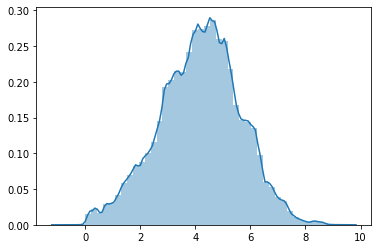

In [53]:
%%time
# X_test = create_X(test_df, target_meter=0)
# gc.collect()

print('开始')
y_test0 = pred(X_test, models0, batch_size=500000)

sns.distplot(y_test0)

del X_test
gc.collect()

In [54]:
# %%time
# X_test = create_X(test_df, target_meter=1)
# gc.collect()

# y_test1 = pred(X_test, models1)
# sns.distplot(y_test1)

# del X_test
# gc.collect()

In [55]:
# %%time
# X_test = create_X(test_df, target_meter=2)
# gc.collect()

# y_test2 = pred(X_test, models2)
# sns.distplot(y_test2)

# del X_test
# gc.collect()

In [56]:
# X_test = create_X(test_df, target_meter=3)
# gc.collect()

# y_test3 = pred(X_test, models3)
# sns.distplot(y_test3)

# del X_test
# gc.collect()

In [57]:
test_df = pd.read_feather(os.path.join(root, 'test.feather'))

In [58]:
# sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = y_test0

# sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
# sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
# sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [59]:
# sample_submission['meter_reading'] = sample_submission['meter_reading'].clip(0,None)

In [60]:
sample_submission

,row_id,meter_reading
0,0,5.112314
1,1,4.195566
2,2,2.167404
3,3,5.609312
4,4,7.149998
...,...,...
41697595,41697595,2.200641
41697596,41697596,1.747437
41697597,41697597,1.449923
41697598,41697598,5.244647


In [63]:
# sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')
output_path = os.path.join('..', 'output', 'as-meter2-no-1099-xgb-meter0-fold1')
sample_submission.to_csv(os.path.join(output_path, 'submission.csv'), index=False)
sample_submission.head()

,row_id,meter_reading
0,0,5.112314
1,1,4.195566
2,2,2.167404
3,3,5.609312
4,4,7.149998


In [62]:
# np.log1p(sample_submission['meter_reading']).hist()